# COVID19 Data Models by State

- comments: false
- author: Ryan Gomez
- toc: true
- categories: [growth, compare, hospitalizations]
- image: images/covid-compare-country-death-hos.png
- permalink: /futureproof-COVID19-States/

In [1]:
#hide_input
# Imports
import os
import pandas as pd
import csv
import kaggle

# other imports
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from copy import copy
import seaborn as sns
from scipy.stats import norm
import matplotlib.dates as mdates
# import matplotlib.colors as mcolors
# import random
# import math
# import time
# from sklearn.linear_model import LinearRegression, BayesianRidge
# from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
# from sklearn.svm import SVR
from datetime import date, datetime
from dateutil.parser import parse
import us
# import operator 
# plt.style.use('fivethirtyeight')
import plotly.graph_objects as go
from plotly.subplots import make_subplots
%matplotlib inline 

c:\programdata\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


# Main Datasets (w/ hospitalised data)

Source: https://covidtracking.com/
Source: https://github.com/CSSEGISandData/COVID-19
Various state data, third party data, and various federal data

In [2]:
#hide_input

all_cases = pd.read_csv('https://covidtracking.com/api/v1/states/daily.csv')

# Delete unecessary rows
for row in ['negative', 'pending', 'hash', 'negativeIncrease', 'totalTestResults', 'totalTestResultsIncrease', 'dateChecked', 'fips', 'inIcuCumulative', 'onVentilatorCumulative', 'total', 'posNeg', 'deathIncrease', 'hospitalizedIncrease', 'positiveIncrease']:
    del all_cases[row]

# TODO missing values
#      Do we get avg or missing values, or predict them?
#      See https://developerzen.com/data-mining-handling-missing-values-the-database-bd2241882e72

for i, row in all_cases.iterrows():
    # Set Dates
    s = str(row['date'])
    all_cases.at[i, 'date'] = date(year=int(s[0:4]), month=int(s[4:6]), day=int(s[6:8]))

# Missing death figures means no death reports yet
# These are set to 0
for i, row in all_cases.iterrows():
    if np.isnan(row['death']):
        all_cases.at[i, 'death'] = 0

## Combine, validate, and verify data sets.

In [3]:
#hide_input

# TODO Replace active cases with JHU and/or regression model (Selma)
all_cases['active'] = all_cases['positive'] - all_cases['recovered'] - all_cases['death']
# change location of 'active' column
cols = list(all_cases)
cols.insert(3, cols.pop(cols.index('active')))
all_cases = all_cases.loc[:, cols]

In [4]:
#hide_input

# Load datasets for US population and Hospital beds per 1000
us_population = pd.read_csv('data/us_population.csv')
hosp_beds = pd.read_csv('data/hospital_beds.csv')
state_abbrev = pd.read_csv('data/us_state_names.csv')

# add state abbreviations to us_population and hospital beds dataframe
for state in state_abbrev['State'].tolist():
    # store state abbreviation in variable
    abbrev = state_abbrev.loc[state_abbrev['State'] == state, 'Abbreviation'].tolist()[0]
    # add abbrev to new column 'Abbreviation' in us_population df
    us_population.loc[us_population['State'] == state, 'Abbreviation'] = abbrev
    # add abbrev to new column in hosp_beds df
    hosp_beds.loc[hosp_beds['Location'] == state, 'Abbreviation'] = abbrev
    
# change order of columns of us_population
cols = list(us_population)
cols.insert(2, cols.pop(cols.index('Abbreviation')))
us_population = us_population.loc[:, cols]

# drop unnecessary columns of us_population
us_population = us_population.drop(columns=['rank', 'Growth', 'Pop2018', 'Pop2010', 'growthSince2010', 'Percent', 'density'])

# drop unnecessary columns of hosp_beds
hosp_beds = hosp_beds.drop(columns=['Location', 'State/Local Government', 'Non-Profit', 'For-Profit'])

# change order of columns of hosp_beds
cols = list(hosp_beds)
cols.insert(0, cols.pop(cols.index('Abbreviation')))
hosp_beds = hosp_beds.loc[:, cols]

In [5]:
#hide_input

# filter out non-existing states like 'AS'
all_cases = all_cases[all_cases['state'].isin(state_abbrev['Abbreviation'].tolist())]

In [6]:
# see what filtered dataframe looks like
all_cases.head(50)

date state  positive    active  hospitalizedCurrently  \
0   2020-06-28    AK     883.0     348.0                   12.0   
1   2020-06-28    AL   35441.0   15656.0                  655.0   
2   2020-06-28    AR   19310.0    5781.0                  278.0   
4   2020-06-28    AZ   73908.0   63394.0                 2691.0   
5   2020-06-28    CA  211243.0       NaN                 5956.0   
6   2020-06-28    CO   32022.0   25906.0                  235.0   
7   2020-06-28    CT   46303.0   33934.0                  103.0   
8   2020-06-28    DC   10248.0    8499.0                  126.0   
9   2020-06-28    DE   11226.0    4054.0                   78.0   
10  2020-06-28    FL  141075.0       NaN                    NaN   
11  2020-06-28    GA   77210.0       NaN                 1236.0   
13  2020-06-28    HI     872.0     140.0                    NaN   
14  2020-06-28    IA   28489.0   10164.0                  118.0   
15  2020-06-28    ID    5319.0    1330.0                    NaN   
16  2020-06-28    IL  142776.0       NaN                 1464.0   
17  2020-06-28    IN   44930.0    8376.0                  617.0   
18  2020-06-28    KS   13538.0   12495.0                    NaN   
19  2020-06-28    KY   15232.0   10944.0                  386.0   
20  2020-06-28    LA   56236.0   13245.0                  715.0   
21  2020-06-28    MA  108667.0       NaN                  748.0   
22  2020-06-28    MD   66777.0   58633.0                  446.0   
23  2020-06-28    ME    3191.0     510.0                   31.0   
24  2020-06-28    MI   69946.0   12689.0                  557.0   
25  2020-06-28    MN   35549.0    3280.0                  288.0   
26  2020-06-28    MO   20575.0       NaN                  412.0   
28  2020-06-28    MS   25892.0    7611.0                  676.0   
29  2020-06-28    MT     863.0     237.0                   11.0   
30  2020-06-28    NC   62142.0   23899.0                  890.0   
31  2020-06-28    ND    3495.0     268.0                   24.0   
32  2020-06-28    NE   18775.0    5455.0                  123.0   
33  2020-06-28    NH    5717.0     949.0                   35.0   
34  2020-06-28    NJ  171182.0  126115.0                 1014.0   
35  2020-06-28    NM   11619.0    5877.0                  122.0   
36  2020-06-28    NV   17160.0   15976.0                  511.0   
37  2020-06-28    NY  392539.0  297694.0                  869.0   
38  2020-06-28    OH   50309.0       NaN                  661.0   
39  2020-06-28    OK   12994.0    3212.0                  329.0   
40  2020-06-28    OR    8341.0    5490.0                  149.0   
41  2020-06-28    PA   85496.0   12231.0                  648.0   
43  2020-06-28    RI   16661.0   14134.0                   91.0   
44  2020-06-28    SC   33320.0   19148.0                  954.0   
45  2020-06-28    SD    6681.0     838.0                   75.0   
46  2020-06-28    TN   40172.0   13429.0                  484.0   
47  2020-06-28    TX  148728.0   66361.0                 5497.0   
48  2020-06-28    UT   21100.0    9002.0                  289.0   
49  2020-06-28    VA   61736.0   51999.0                  818.0   
51  2020-06-28    VT    1202.0     200.0                   15.0   
52  2020-06-28    WA   31404.0       NaN                  304.0   
53  2020-06-28    WI   30707.0    7977.0                  239.0   
54  2020-06-28    WV    2817.0     662.0                   32.0   

    hospitalizedCumulative  inIcuCurrently  onVentilatorCurrently  recovered  \
0                      NaN             NaN                    1.0      521.0   
1                   2703.0             NaN                    NaN    18866.0   
2                   1373.0             NaN                   63.0    13270.0   
4                   4617.0           666.0                  475.0     8926.0   
5                      NaN          1602.0                    NaN        NaN   
6                   5399.0             NaN                    NaN     4442.0   
7                  10268.0      

In [7]:
#hide_input

# Split dataframes by date
df_split_by_date = dict(tuple(all_cases.groupby('date')))

# Split dataframes by state
df_split_by_state = dict(tuple(all_cases.groupby('state')))

In [8]:
#hide_input

# merge dataframes us_population and all_cases
df_merge_uspop = all_cases.merge(us_population, how='left', left_on='state', right_on='Abbreviation')
df_merge_uspop = df_merge_uspop.drop(columns=['Abbreviation'])
df_merge_uspop = df_merge_uspop.rename(columns={'Pop': 'population'})

# change location of 'population' column
cols = list(df_merge_uspop)
cols.insert(2, cols.pop(cols.index('population')))
df_merge_uspop = df_merge_uspop.loc[:, cols]

# merge dataframes hosp_beds and df_merge_uspop
df_merge_hosp = df_merge_uspop.merge(hosp_beds, how='left', left_on='state', right_on='Abbreviation')
df_merge_hosp = df_merge_hosp.drop(columns=['Abbreviation'])
all_cases = df_merge_hosp.rename(columns={'Total': 'bedsPerThousand'})

In [9]:
#hide_input

# Calculate the total beds, and add the column
all_cases['total_beds'] = all_cases['population'] / 1000 * all_cases['bedsPerThousand']

In [10]:
#hide_input

# change abbreviations to state names
all_cases = all_cases.rename(columns={'state': 'abbrev'})
all_cases = all_cases.rename(columns={'State': 'state'})

In [11]:
#hide_input

# change location of 'state' column
cols = list(all_cases)
cols.insert(1, cols.pop(cols.index('state')))
all_cases = all_cases.loc[:, cols]

In [12]:
all_cases.head(50)

date                 state abbrev  population  positive    active  \
0   2020-06-28                Alaska     AK      734002     883.0     348.0   
1   2020-06-28               Alabama     AL     4908621   35441.0   15656.0   
2   2020-06-28              Arkansas     AR     3038999   19310.0    5781.0   
3   2020-06-28               Arizona     AZ     7378494   73908.0   63394.0   
4   2020-06-28            California     CA    39937489  211243.0       NaN   
5   2020-06-28              Colorado     CO     5845526   32022.0   25906.0   
6   2020-06-28           Connecticut     CT     3563077   46303.0   33934.0   
7   2020-06-28  District of Columbia     DC      720687   10248.0    8499.0   
8   2020-06-28              Delaware     DE      982895   11226.0    4054.0   
9   2020-06-28               Florida     FL    21992985  141075.0       NaN   
10  2020-06-28               Georgia     GA    10736059   77210.0       NaN   
11  2020-06-28                Hawaii     HI     1412687     872.0     140.0   
12  2020-06-28                  Iowa     IA     3179849   28489.0   10164.0   
13  2020-06-28                 Idaho     ID     1826156    5319.0    1330.0   
14  2020-06-28              Illinois     IL    12659682  142776.0       NaN   
15  2020-06-28               Indiana     IN     6745354   44930.0    8376.0   
16  2020-06-28                Kansas     KS     2910357   13538.0   12495.0   
17  2020-06-28              Kentucky     KY     4499692   15232.0   10944.0   
18  2020-06-28             Louisiana     LA     4645184   56236.0   13245.0   
19  2020-06-28         Massachusetts     MA     6976597  108667.0       NaN   
20  2020-06-28              Maryland     MD     6083116   66777.0   58633.0   
21  2020-06-28                 Maine     ME     1345790    3191.0     510.0   
22  2020-06-28              Michigan     MI    10045029   69946.0   12689.0   
23  2020-06-28             Minnesota     MN     5700671   35549.0    3280.0   
24  2020-06-28              Missouri     MO     6169270   20575.0       NaN   
25  2020-06-28           Mississippi     MS     2989260   25892.0    7611.0   
26  2020-06-28               Montana     MT     1086759     863.0     237.0   
27  2020-06-28        North Carolina     NC    10611862   62142.0   23899.0   
28  2020-06-28          North Dakota     ND      761723    3495.0     268.0   
29  2020-06-28              Nebraska     NE     1952570   18775.0    5455.0   
30  2020-06-28         New Hampshire     NH     1371246    5717.0     949.0   
31  2020-06-28            New Jersey     NJ     8936574  171182.0  126115.0   
32  2020-06-28            New Mexico     NM     2096640   11619.0    5877.0   
33  2020-06-28                Nevada     NV     3139658   17160.0   15976.0   
34  2020-06-28              New York     NY    19440469  392539.0  297694.0   
35  2020-06-28                  Ohio     OH    11747694   50309.0       NaN   
36  2020-06-28              Oklahoma     OK     3954821   12994.0    3212.0   
37  2020-06-28                Oregon     OR     4301089    8341.0    5490.0   
38  2020-06-28          Pennsylvania     PA    12820878   85496.0   12231.0   
39  2020-06-28          Rhode Island     RI     1056161   16661.0   14134.0   
40  2020-06-28        South Carolina     SC     5210095   33320.0   19148.0   
41  2020-06-28          South Dakota     SD      903027    6681.0     838.0   
42  2020-06-28             Tennessee     TN     6897576   40172.0   13429.0   
43  2020-06-28                 Texas     TX    29472295  148728.0   66361.0   
44  2020-06-28                  Utah     UT     3282115   21100.0    9002.0   
45  2020-06-28              Virginia     VA     8626207   61736.0   51999.0   
46  2020-06-28               Vermont     VT      628061    1202.0     200.0   
47  2020-06-28            Washington     WA     7797095   31404.0       NaN   
48  2020-06-28             Wisconsin     WI     5851754   30707.0    7977.0   
49  2020-06-28         West Virginia     WV     1778070    2

- Load and clean JHU data
- Merge JHU dataset with main dataset

In [13]:
#hide_input

# This cell takes some time, as it needs to connect to Kaggle Servers to retrieve data
kaggle.api.authenticate()
kaggle.api.dataset_download_files('benhamner/jhucovid19', path='./kaggle/input/jhucovid19/', unzip=True)

In [14]:
#hide_input

# Get Time-Series Data of cases as Pandas DataFrame
dir_jhu = './kaggle/input/jhucovid19/csse_covid_19_data/csse_covid_19_daily_reports'

df_list = []
for dirname, _, files in os.walk(dir_jhu):
    for file in files:
        if 'gitignore' not in file and 'README' not in file:
            full_dir = os.path.join(dirname, file)
            df_list.append(pd.read_csv(full_dir))
            
jhu_df = pd.concat(df_list, axis=0, ignore_index=True, sort=True)

# convert Last Update columns to datetime format
jhu_df.loc[:, 'Last Update'] = pd.to_datetime(jhu_df['Last Update']).apply(lambda x: x.date())
jhu_df.loc[:, 'Last_Update'] = pd.to_datetime(jhu_df['Last_Update']).apply(lambda x: x.date())

# Combine Last Update with Last_Update
jhu_df['LastUpdate'] = jhu_df['Last_Update'].combine_first(jhu_df['Last Update'])

# Combine Country/Region with Country_Region
jhu_df['CountryRegion'] = jhu_df['Country/Region'].combine_first(jhu_df['Country_Region'])

# Retrieve only US data
jhu_df = jhu_df[jhu_df['CountryRegion']=='US']

# Combine Province/State with Province_State
jhu_df['ProvinceState'] = jhu_df['Province/State'].combine_first(jhu_df['Province_State'])

# Drop unnecessary columns
jhu_df = jhu_df.drop(['Admin2', 'Lat', 'Latitude', 'Long_', 'Longitude', 'Combined_Key', 'Country/Region',
                      'Country_Region', 'Province/State', 'Province_State',
                      'Last Update', 'Last_Update', 'FIPS'], axis=1)

# Change column order
cols = list(jhu_df)
cols.insert(0, cols.pop(cols.index('CountryRegion')))
cols.insert(1, cols.pop(cols.index('ProvinceState')))
cols.insert(2, cols.pop(cols.index('LastUpdate')))
jhu_df = jhu_df.loc[:, cols]

# Change region to known US states
state_abbrs_dict = {}
for state in us.states.STATES:
    state_abbrs_dict[state.abbr] = state.name

def toState(input_state, mapping):
    abbreviation = input_state.rstrip()[-2:]
    try:
        return_value = mapping[abbreviation]
    except KeyError:
        return_value = input_state
    return return_value

jhu_df['ProvinceState'] = jhu_df['ProvinceState'].apply(lambda x: toState(x, state_abbrs_dict) if x != 'Washington, D.C.' else 'District of Columbia')

# Filter out unknown states
jhu_df = jhu_df[jhu_df['ProvinceState'].isin(all_cases.state.unique().tolist())]

# Merge-sum rows with same date and State
jhu_df = jhu_df.groupby(['LastUpdate', 'ProvinceState']).agg(
    {
        'Active': sum,
        'Confirmed': sum,
        'Deaths': sum,
        'Recovered': sum
    }
).reset_index()

jhu_df.tail(50)

LastUpdate         ProvinceState    Active  Confirmed   Deaths  \
5145  2020-06-19                Alaska     695.0      707.0     12.0   
5146  2020-06-19               Arizona   42162.0    43445.0   1283.0   
5147  2020-06-19              Arkansas   13720.0    13928.0    208.0   
5148  2020-06-19            California  161731.0   167086.0   5355.0   
5149  2020-06-19              Colorado   28248.0    29886.0   1638.0   
5150  2020-06-19           Connecticut   41214.0    45440.0   4226.0   
5151  2020-06-19              Delaware   10068.0    10499.0    431.0   
5152  2020-06-19  District of Columbia    9376.0     9903.0    527.0   
5153  2020-06-19               Florida   82865.0    85926.0   3061.0   
5154  2020-06-19               Georgia   58307.0    60912.0   2605.0   
5155  2020-06-19                Hawaii     745.0      762.0     17.0   
5156  2020-06-19                 Idaho    3654.0     3743.0     89.0   
5157  2020-06-19              Illinois  128241.0   134778.0   6537.0   
5158  2020-06-19               Indiana   38947.0    41438.0   2491.0   
5159  2020-06-19                  Iowa   24181.0    24861.0    680.0   
5160  2020-06-19                Kansas   11502.0    11753.0    251.0   
5161  2020-06-19              Kentucky   12677.0    13197.0    520.0   
5162  2020-06-19             Louisiana   45572.0    48634.0   3062.0   
5163  2020-06-19                 Maine    2776.0     2878.0    102.0   
5164  2020-06-19              Maryland   60213.0    63229.0   3016.0   
5165  2020-06-19         Massachusetts   98653.0   106422.0   7769.0   
5166  2020-06-19              Michigan   60737.0    66798.0   6061.0   
5167  2020-06-19             Minnesota   30299.0    31675.0   1376.0   
5168  2020-06-19           Mississippi   19703.0    20641.0    938.0   
5169  2020-06-19              Missouri   16426.0    17371.0    945.0   
5170  2020-06-19               Montana     635.0      655.0     20.0   
5171  2020-06-19              Nebraska   17175.0    17414.0    239.0   
5172  2020-06-19                Nevada   11694.0    12169.0    475.0   
5173  2020-06-19         New Hampshire    5119.0     5450.0    331.0   
5174  2020-06-19            New Jersey  155238.0   168107.0  12869.0   
5175  2020-06-19            New Mexico    9697.0    10153.0    456.0   
5176  2020-06-19              New York  354786.0   385760.0  30974.0   
5177  2020-06-19        North Carolina   46972.0    48168.0   1196.0   
5178  2020-06-19          North Dakota    3118.0     3193.0     75.0   
5179  2020-06-19                  Ohio   40489.0    43122.0   2633.0   
5180  2020-06-19              Oklahoma    8989.0     9355.0    366.0   
5181  2020-06-19                Oregon    6179.0     6366.0    187.0   
5182  2020-06-19          Pennsylvania   78322.0    84683.0   6361.0   
5183  2020-06-19          Rhode Island   15384.0    16269.0    885.0   
5184  2020-06-19        South Carolina   20912.0    21533.0    621.0   
5185  2020-06-19          South Dakota    6031.0     6109.0     78.0   
5186  2020-06-19             Tennessee   32262.0    32770.0    508.0   
5187  2020-06-19                 Texas   99130.0   101259.0   2129.0   
5188  2020-06-19                  Utah   15687.0    15839.0    152.0   
5189  2020-06-19               Vermont    1079.0     1135.0     56.0   
5190  2020-06-19              Virginia   54652.0    56238.0   1586.0   
5191  2020-06-19            Washington   25947.0    27192.0   1245.0   
5192  2020-06-19         West Virginia    2330.0     2418.0     88.0   
5193  2020-06-19             Wisconsin   23157.0    23876.0    719.0   
5194  2020-06-19               Wyoming    1126.0     1144.0     18.0   

      Recovered  
5145        0.0  
5146        0.0  
5147        0.0  
5148        0.0  
5149        0.0  
5150        0.0  
5151        0.0  
5152        0.0  
5153        0.0  
5154        0.0  
5155        0.0  
5156        0.0  
5157        0.0  
5158        0.0  
5159        0.0  
5160        0.0  
5161        0.0  
5162     

In [15]:
#hide_input

# Now that we have the JHU dataset relatively cleaned
# we can go ahead and merge its data with our main dataset

for i, row in all_cases.iterrows():
    last_update = all_cases.at[i, 'date']
    state = all_cases.at[i, 'state']
    matching_row = jhu_df[jhu_df['ProvinceState'] == state]
    matching_row = matching_row[matching_row['LastUpdate'] == last_update].reset_index()

    if len(matching_row.values) > 0:
        #all_cases.at[i, 'positive'] = matching_row['Confirmed'].values[0]
        all_cases.at[i, 'active'] = matching_row['Active'].values[0]
        #all_cases.at[i, 'recovered'] = matching_row['Recovered'].values[0]   --- JHU was inconsistent, therefore removed
        #all_cases.at[i, 'death'] = matching_row['Deaths'].values[0]

    # Replace unknown recovery numbers with 0
    if np.isnan(row['recovered']):
        all_cases.at[i, 'recovered'] = 0

    if all_cases.at[i, 'active'] == 0 or np.isnan(row['active']):
        positive = all_cases.at[i, 'positive']
        recovered = all_cases.at[i, 'recovered']
        dead = all_cases.at[i, 'death']
        all_cases.at[i, 'active'] = positive - recovered - dead

all_cases.tail()

date       state abbrev  population  positive  active  \
5927  2020-01-26  Washington     WA     7797095       2.0     2.0   
5928  2020-01-25  Washington     WA     7797095       2.0     2.0   
5929  2020-01-24  Washington     WA     7797095       2.0     2.0   
5930  2020-01-23  Washington     WA     7797095       2.0     2.0   
5931  2020-01-22  Washington     WA     7797095       2.0     2.0   

      hospitalizedCurrently  hospitalizedCumulative  inIcuCurrently  \
5927                    NaN                     NaN             NaN   
5928                    NaN                     NaN             NaN   
5929                    NaN                     NaN             NaN   
5930                    NaN                     NaN             NaN   
5931                    NaN                     NaN             NaN   

      onVentilatorCurrently  ...  negativeTestsViral positiveCasesViral  \
5927                    NaN  ...                 NaN                NaN   
5928                    NaN  ...                 NaN                NaN   
5929                    NaN  ...                 NaN                NaN   
5930                    NaN  ...                 NaN                NaN   
5931                    NaN  ...                 NaN                NaN   

     commercialScore negativeRegularScore negativeScore  positiveScore  score  \
5927               0                    0             0              0      0   
5928               0                    0             0              0      0   
5929               0                    0             0              0      0   
5930               0                    0             0              0      0   
5931               0                    0             0              0      0   

      grade  bedsPerThousand  total_beds  
5927    NaN              1.7  13255.0615  
5928    NaN              1.7  13255.0615  
5929    NaN              1.7  13255.0615  
5930    NaN              1.7  13255.0615  
5931    NaN              1.7  13255.0615  

[5 rows x 29 columns]

In [16]:
#hide_input
# Save formatted dataset offline in case of disaster
dataset_file = 'results/all_cases.csv'
all_cases.to_csv(dataset_file)

In [17]:
#hide_input

# convert date to datetime format
all_cases['date'] = pd.to_datetime(all_cases['date'])

# An Exploratory data analysis of the US dataset
# Basic triad of the dataset: validating data types and data integrity of each row


In [18]:
#hide_input

dataset_file = 'results/all_cases.csv'
covid_df = pd.read_csv(dataset_file, index_col=0) 
# convert date to datetime format
covid_df['date'] = pd.to_datetime(covid_df['date'])
covid_df.info()
# set float format to 3 decimals
pd.set_option('display.float_format', lambda x: '%.3f' % x)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5932 entries, 0 to 5931
Data columns (total 29 columns):
date                      5932 non-null datetime64[ns]
state                     5932 non-null object
abbrev                    5932 non-null object
population                5932 non-null int64
positive                  5932 non-null float64
active                    5932 non-null float64
hospitalizedCurrently     3645 non-null float64
hospitalizedCumulative    3234 non-null float64
inIcuCurrently            1883 non-null float64
onVentilatorCurrently     1675 non-null float64
recovered                 5932 non-null float64
dataQualityGrade          4998 non-null object
lastUpdateEt              5577 non-null object
dateModified              5577 non-null object
checkTimeEt               5577 non-null object
death                     5932 non-null float64
hospitalized              3234 non-null float64
totalTestsViral           1592 non-null float64
positiveTestsViral        535 

In [19]:
covid_df.head(50)

date                 state abbrev  population   positive     active  \
0  2020-06-28                Alaska     AK      734002    883.000    348.000   
1  2020-06-28               Alabama     AL     4908621  35441.000  15656.000   
2  2020-06-28              Arkansas     AR     3038999  19310.000   5781.000   
3  2020-06-28               Arizona     AZ     7378494  73908.000  63394.000   
4  2020-06-28            California     CA    39937489 211243.000 205338.000   
5  2020-06-28              Colorado     CO     5845526  32022.000  25906.000   
6  2020-06-28           Connecticut     CT     3563077  46303.000  33934.000   
7  2020-06-28  District of Columbia     DC      720687  10248.000   8499.000   
8  2020-06-28              Delaware     DE      982895  11226.000   4054.000   
9  2020-06-28               Florida     FL    21992985 141075.000 137557.000   
10 2020-06-28               Georgia     GA    10736059  77210.000  74432.000   
11 2020-06-28                Hawaii     HI     1412687    872.000    140.000   
12 2020-06-28                  Iowa     IA     3179849  28489.000  10164.000   
13 2020-06-28                 Idaho     ID     1826156   5319.000   1330.000   
14 2020-06-28              Illinois     IL    12659682 142776.000 135687.000   
15 2020-06-28               Indiana     IN     6745354  44930.000   8376.000   
16 2020-06-28                Kansas     KS     2910357  13538.000  12495.000   
17 2020-06-28              Kentucky     KY     4499692  15232.000  10944.000   
18 2020-06-28             Louisiana     LA     4645184  56236.000  13245.000   
19 2020-06-28         Massachusetts     MA     6976597 108667.000 100607.000   
20 2020-06-28              Maryland     MD     6083116  66777.000  58633.000   
21 2020-06-28                 Maine     ME     1345790   3191.000    510.000   
22 2020-06-28              Michigan     MI    10045029  69946.000  12689.000   
23 2020-06-28             Minnesota     MN     5700671  35549.000   3280.000   
24 2020-06-28              Missouri     MO     6169270  20575.000  19578.000   
25 2020-06-28           Mississippi     MS     2989260  25892.000   7611.000   
26 2020-06-28               Montana     MT     1086759    863.000    237.000   
27 2020-06-28        North Carolina     NC    10611862  62142.000  23899.000   
28 2020-06-28          North Dakota     ND      761723   3495.000    268.000   
29 2020-06-28              Nebraska     NE     1952570  18775.000   5455.000   
30 2020-06-28         New Hampshire     NH     1371246   5717.000    949.000   
31 2020-06-28            New Jersey     NJ     8936574 171182.000 126115.000   
32 2020-06-28            New Mexico     NM     2096640  11619.000   5877.000   
33 2020-06-28                Nevada     NV     3139658  17160.000  15976.000   
34 2020-06-28              New York     NY    19440469 392539.000 297694.000   
35 2020-06-28                  Ohio     OH    11747694  50309.000  47502.000   
36 2020-06-28              Oklahoma     OK     3954821  12994.000   3212.000   
37 2020-06-28                Oregon     OR     4301089   8341.000   5490.000   
38 2020-06-28          Pennsylvania     PA    12820878  85496.000  12231.000   
39 2020-06-28          Rhode Island     RI     1056161  16661.000  14134.000   
40 2020-06-28        South Carolina     SC     5210095  33320.000  19148.000   
41 2020-06-28          South Dakota     SD      903027   6681.000    838.000   
42 2020-06-28             Tennessee     TN     6897576  40172.000  13429.000   
43 2020-06-28                 Texas     TX    29472295 148728.000  66361.000   
44 2020-06-28                  Utah     UT     3282115  21100.000   9002.000   
45 2020-06-28              Virginia     VA     8626207  61736.000  51999.000   
46 2020-06-28               Vermont     VT      628061   1202.000    200.000   
47 2020-06-28            Washington     WA     7797095  31404.000  30094.000   
48 2020-06-28             Wisconsin     WI     5851754  30707.000   7977.000   
49 2020-0

The NaN values may indicate that there were no to few Covid-19 patients at these date points.
We further analyse the statistical values of the dataset columns to ensure data integrity and accuracy. 

In [20]:
#hide_input

covid_df.describe()
# TODO rounding up the numbers

population   positive     active  hospitalizedCurrently  \
count     5932.000   5932.000   5932.000               3645.000   
mean   6542964.221  21163.607  18746.564               1023.799   
std    7387050.444  46807.026  42033.172               1927.101   
min     567025.000      0.000      0.000                  1.000   
25%    1778070.000    640.000    555.000                121.000   
50%    4499692.000   5122.000   4543.000                402.000   
75%    7797095.000  20840.750  17541.250               1032.000   
max   39937489.000 392539.000 356899.000              18825.000   

       hospitalizedCumulative  inIcuCurrently  onVentilatorCurrently  \
count                3234.000        1883.000               1675.000   
mean                 4369.803         441.040                224.801   
std                 12949.481         692.449                328.899   
min                     0.000           2.000                  0.000   
25%                   223.000          82.000                 35.500   
50%                   973.000         181.000                 94.000   
75%                  3255.250         482.000                249.000   
max                 89995.000        5225.000               2425.000   

       recovered     death  hospitalized  ...  negativeTestsViral  \
count   5932.000  5932.000      3234.000  ...             535.000   
mean    4474.004  1101.755      4369.803  ...          293835.318   
std    11042.022  2921.727     12949.481  ...          389283.058   
min        0.000     0.000         0.000  ...              17.000   
25%        0.000    13.000       223.000  ...           50018.000   
50%      218.000   147.000       973.000  ...          140972.000   
75%     3140.500   782.250      3255.250  ...          360303.000   
max    79974.000 24835.000     89995.000  ...         2070179.000   

       positiveCasesViral  commercialScore  negativeRegularScore  \
count            3108.000         5932.000              5932.000   
mean            32231.603            0.000                 0.000   
std             56691.350            0.000                 0.000   
min                 0.000            0.000                 0.000   
25%              5033.000            0.000                 0.000   
50%             13770.500            0.000                 0.000   
75%             35463.250            0.000                 0.000   
max            392539.000            0.000                 0.000   

       negativeScore  positiveScore    score  grade  bedsPerThousand  \
count       5932.000       5932.000 5932.000  0.000         5932.000   
mean           0.000          0.000    0.000    nan            2.626   
std            0.000          0.000    0.000    nan            0.744   
min            0.000          0.000    0.000    nan            1.600   
25%            0.000          0.000    0.000    nan            2.100   
50%            0.000          0.000    0.000    nan            2.500   
75%            0.000          0.000    0.000    nan            3.100   
max            0.000          0.000    0.000    nan            4.800   

       total_beds  
count    5932.000  
mean    15806.395  
std     16159.661  
min      1318.928  
25%      3773.952  
50%     11557.920  
75%     19124.737  
max     71887.480  

[8 rows x 22 columns]

In [21]:
#hide_input

# drop unnecessary columns
covid_cleaned = covid_df.drop(['hospitalized', 'bedsPerThousand'], axis=1)
covid_100k = covid_cleaned.copy()
# list of columns to transform to per 100k
columns_list = ['positive', 'active', 'recovered', 'death', 'hospitalizedCurrently', 'hospitalizedCumulative', 'inIcuCurrently', 'onVentilatorCurrently', 'total_beds']
# add columns per 100k
for column in columns_list:
    if column == 'total_beds':
        covid_100k['BedsPer100k'.format(column)] = (covid_cleaned.loc[:, column] / covid_cleaned.loc[:, 'population']) * 100000
    else:
        covid_100k['{}_100k'.format(column)] = (covid_cleaned.loc[:, column] / covid_cleaned.loc[:, 'population']) * 100000

covid_100k = covid_100k.drop(columns_list, axis=1)

In [22]:
#hide_input

covid_100k['date'] = pd.to_datetime(covid_100k['date'])
start_date = '2020-04-18'
end_date = '2020-06-19'
mask = (covid_100k['date'] > start_date) & (covid_100k['date'] <= end_date)
covid_100k_last_month = covid_100k.loc[mask]

In [23]:
#hide_input

covid_100k_last_month_part1 =  covid_100k_last_month.groupby('date').sum().loc[:, ['positive_100k','active_100k','recovered_100k','death_100k','hospitalizedCumulative_100k']].diff(periods=1, axis=0)

covid_100k_last_month_part2 = covid_100k_last_month.groupby('date').sum().loc[:, ['inIcuCurrently_100k','onVentilatorCurrently_100k','BedsPer100k']]

final_100k_last_month = covid_100k_last_month_part1.merge(covid_100k_last_month_part2, left_index=True, right_index=True)

In [24]:
final_100k_last_month.head()

positive_100k  active_100k  recovered_100k  death_100k  \
date                                                                 
2020-04-19            nan          nan             nan         nan   
2020-04-20        413.759      391.692          35.481      25.728   
2020-04-21        387.394      360.446          65.218      30.520   
2020-04-22        428.601      989.954         412.625      28.780   
2020-04-23        452.031    -2213.482          72.921      26.282   

            hospitalizedCumulative_100k  inIcuCurrently_100k  \
date                                                           
2020-04-19                          nan              153.528   
2020-04-20                       22.652              156.581   
2020-04-21                       31.446              166.081   
2020-04-22                       36.181              167.561   
2020-04-23                       28.842              166.277   

            onVentilatorCurrently_100k  BedsPer100k  
date                                                 
2020-04-19                      80.717    13440.000  
2020-04-20                      79.710    13440.000  
2020-04-21                      78.603    13440.000  
2020-04-22                      78.032    13440.000  
2020-04-23                      94.521    13440.000

In [25]:
final_100k_last_month.describe()

positive_100k  active_100k  recovered_100k  death_100k  \
count         61.000       61.000          61.000      61.000   
mean         358.759      336.008         170.212      17.931   
std           65.620      442.921         105.723       7.283   
min          245.203    -2213.482          35.481       4.880   
25%          308.315      292.339         107.989      12.184   
50%          344.558      332.717         147.227      17.253   
75%          405.031      370.778         211.312      23.811   
max          544.349     2291.210         626.665      33.917   

       hospitalizedCumulative_100k  inIcuCurrently_100k  \
count                       61.000               62.000   
mean                        34.329              113.658   
std                         42.821               26.916   
min                        -93.926               70.613   
25%                         21.638               94.079   
50%                         25.122              111.563   
75%                         29.823              126.991   
max                        246.371              167.561   

       onVentilatorCurrently_100k  BedsPer100k  
count                      62.000       62.000  
mean                       62.620    13440.000  
std                        13.514        0.000  
min                        39.353    13440.000  
25%                        53.461    13440.000  
50%                        62.120    13440.000  
75%                        74.683    13440.000  
max                        94.521    13440.000

In [26]:
#hide_input

# save description cleaned dataset to csv
describe_file = 'results/final_100k_last_month.csv'
final_100k_last_month.describe().to_csv(describe_file)

## Graphical Exploratory Analysis

Plotting histograms, scatterplots and boxplots to assess the distribution of the entire US dataset. 

In [27]:
#hide_input

# Omitting the categorical (states/abbreviations) and time columns 
# There must be an easier way for you, but this was the easiest way I could think of
covid_cleaned['date'] = pd.to_datetime(covid_cleaned['date'])
# mask data for last month
start_date = '2020-04-18'
end_date = '2020-05-19'
mask = (covid_cleaned['date'] > start_date) & (covid_cleaned['date'] <= end_date)
covid_cleaned_last_month = covid_cleaned.loc[mask]
plot_df = covid_cleaned_last_month[['population', 'active', 'recovered', 'death', 'hospitalizedCurrently', 'inIcuCurrently', 'onVentilatorCurrently', 'total_beds']]
plot_df_last_month = covid_100k_last_month[['population', 'active_100k', 'recovered_100k', 'death_100k', 'hospitalizedCurrently_100k', 'inIcuCurrently_100k', 'onVentilatorCurrently_100k', 'BedsPer100k']]

In [28]:
#hide_input

timeseries_usa_df = covid_100k.loc[:, ['date', 'positive_100k', 'active_100k', 'recovered_100k', 'death_100k', 'hospitalizedCurrently_100k', 'inIcuCurrently_100k', 'onVentilatorCurrently_100k', 'BedsPer100k']].groupby('date').sum().reset_index()
# timeseries_usa_df['log_positive'] = np.log(timeseries_usa_df['positive_100k'])
# timeseries_usa_df['log_active'] = np.log(timeseries_usa_df['active_100k'])
# timeseries_usa_df['log_recovered'] = np.log(timeseries_usa_df['recovered_100k'])
# timeseries_usa_df['log_death'] = np.log(timeseries_usa_df['death_100k'])

In [29]:
timeseries_usa_df.tail()

date  positive_100k  active_100k  recovered_100k  death_100k  \
154 2020-06-24      33315.285    19401.954       12359.391    1553.940   
155 2020-06-25      33812.912    19730.969       12498.864    1583.079   
156 2020-06-26      34335.924    20098.997       12643.998    1592.929   
157 2020-06-27      34829.638    20417.559       12812.241    1599.839   
158 2020-06-28      35334.565    20809.528       12921.408    1603.630   

     hospitalizedCurrently_100k  inIcuCurrently_100k  \
154                     408.570               68.612   
155                     414.087               67.864   
156                     404.115               67.051   
157                     407.257               68.533   
158                     402.011               65.968   

     onVentilatorCurrently_100k  BedsPer100k  
154                      36.820    13440.000  
155                      36.962    13440.000  
156                      34.318    13440.000  
157                      35.118    13440.000  
158                      33.930    13440.000

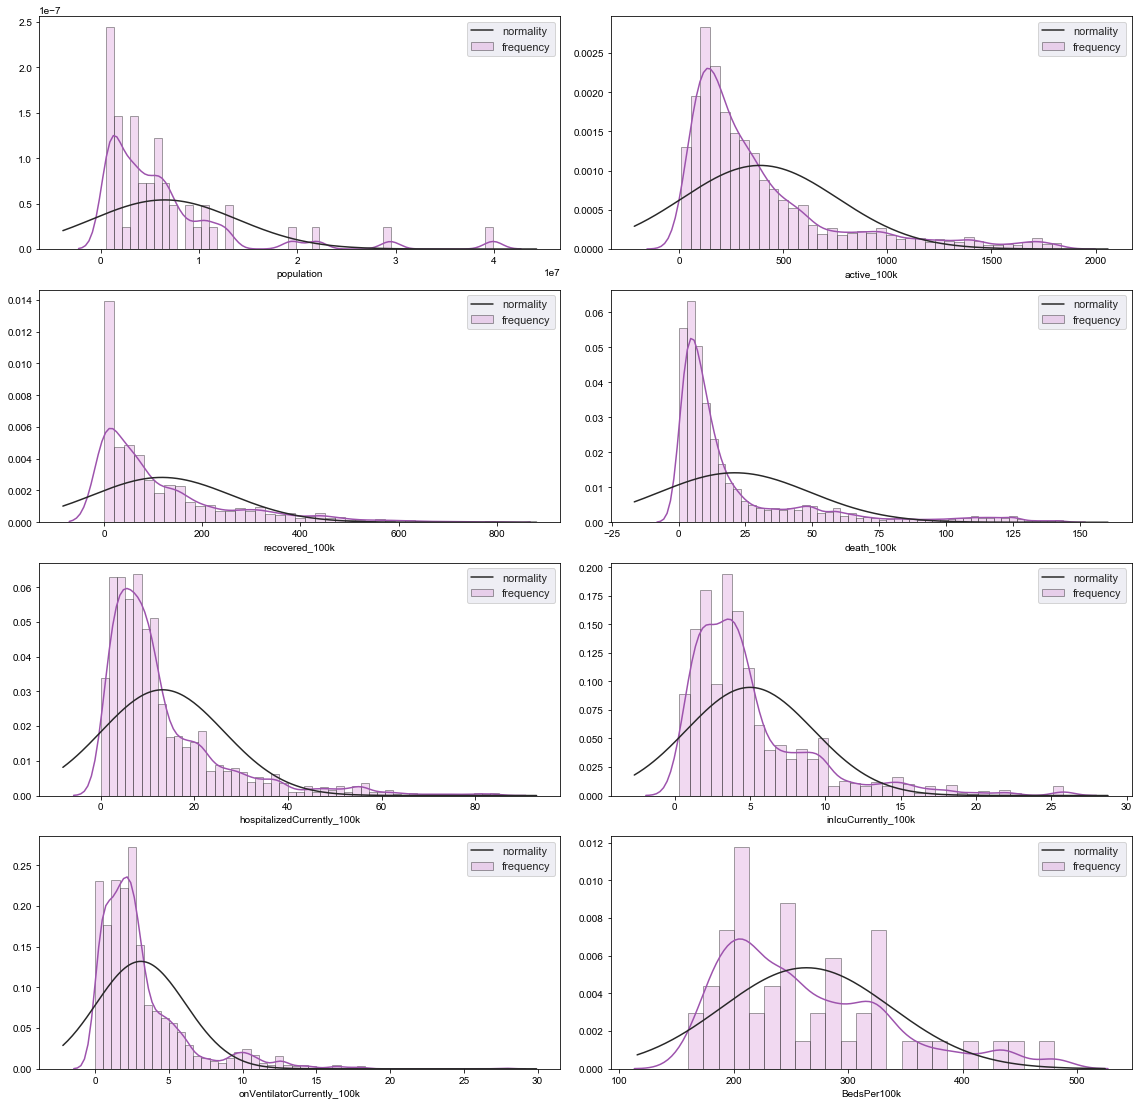

In [30]:
#hide_input

# get data from last day
# plot_df_last_date = plot_df.loc[covid_df['date'] == '2020-05-18'] 

# Plotting histograms to gain insight of the distribution shape, skewness and scale
fig, axs = plt.subplots(4,2,figsize = (16, 16))
sns.set()
for i, column in enumerate(plot_df_last_month.columns):
    if (i + 1) % 2 == 0:
        ax = axs[(i//2), 1]
    else:
        ax = axs[(i//2), 0]
    sns.distplot(plot_df_last_month[column], fit=norm, fit_kws=dict(label='normality'), hist_kws=dict(color='plum', edgecolor='k', linewidth=1, label='frequency'), ax=ax, color='#9d53ad')
    ax.legend(loc='upper right')
plt.tight_layout()
fig.subplots_adjust(top=0.95)

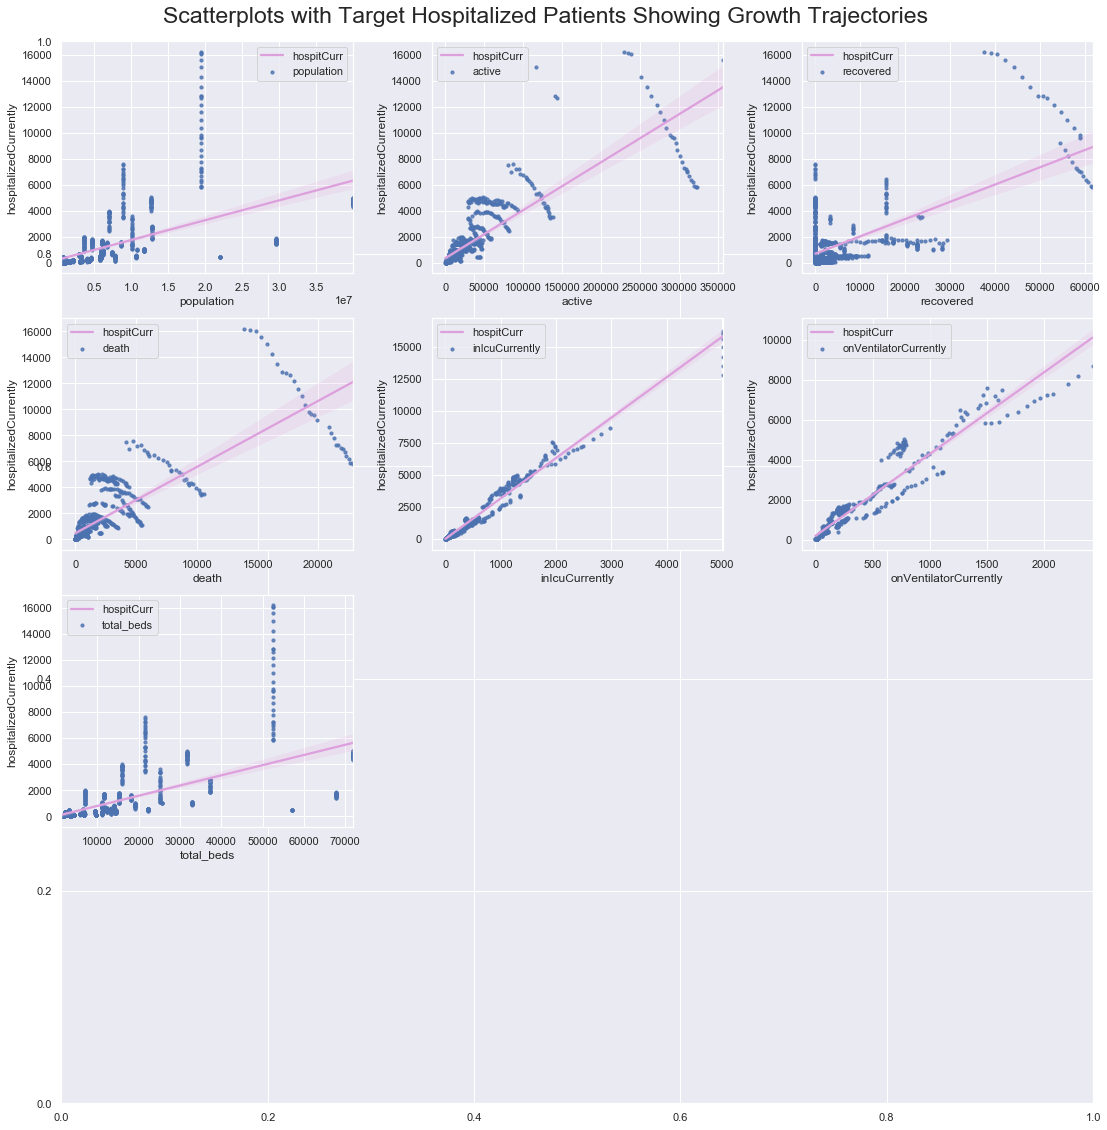

In [31]:
#hide_input

# Looking at linearity and variance with scatterplots
# Removing the target variable and saving it in another df
target = plot_df.hospitalizedCurrently
indep_var = plot_df.drop(columns=['hospitalizedCurrently'])

fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(indep_var.columns):
    ax=fig.add_subplot(4, 3, i+1) 
    sns.regplot(x=indep_var[col], y=target, data=indep_var, label=col, scatter_kws={'s':10}, line_kws={"color": "plum", 'label': 'hospitCurr'})
    plt.suptitle('Scatterplots with Target Hospitalized Patients Showing Growth Trajectories', fontsize=23)
    plt.legend()
plt.tight_layout()
fig.subplots_adjust(top=0.95)

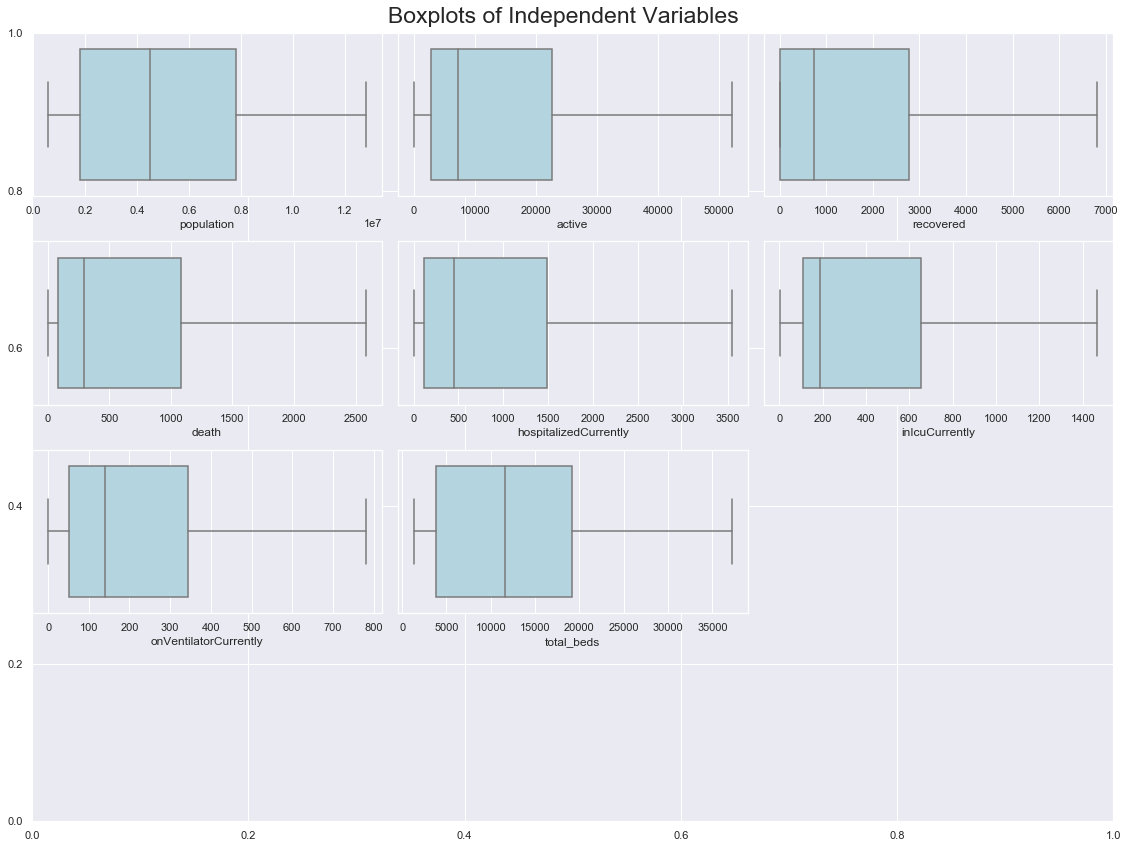

In [32]:
#hide_input

# Assessing the normality of the distribution with a boxplot
# Boxplot with removed outliers
fig, ax = plt.subplots(figsize = (16, 12))
for i, col in enumerate(plot_df.columns):
    ax=fig.add_subplot(4, 3, i+1) 
    sns.boxplot(x=plot_df[col], data=plot_df, color='lightblue', showfliers=False)
    plt.suptitle('Boxplots of Independent Variables', fontsize=23)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

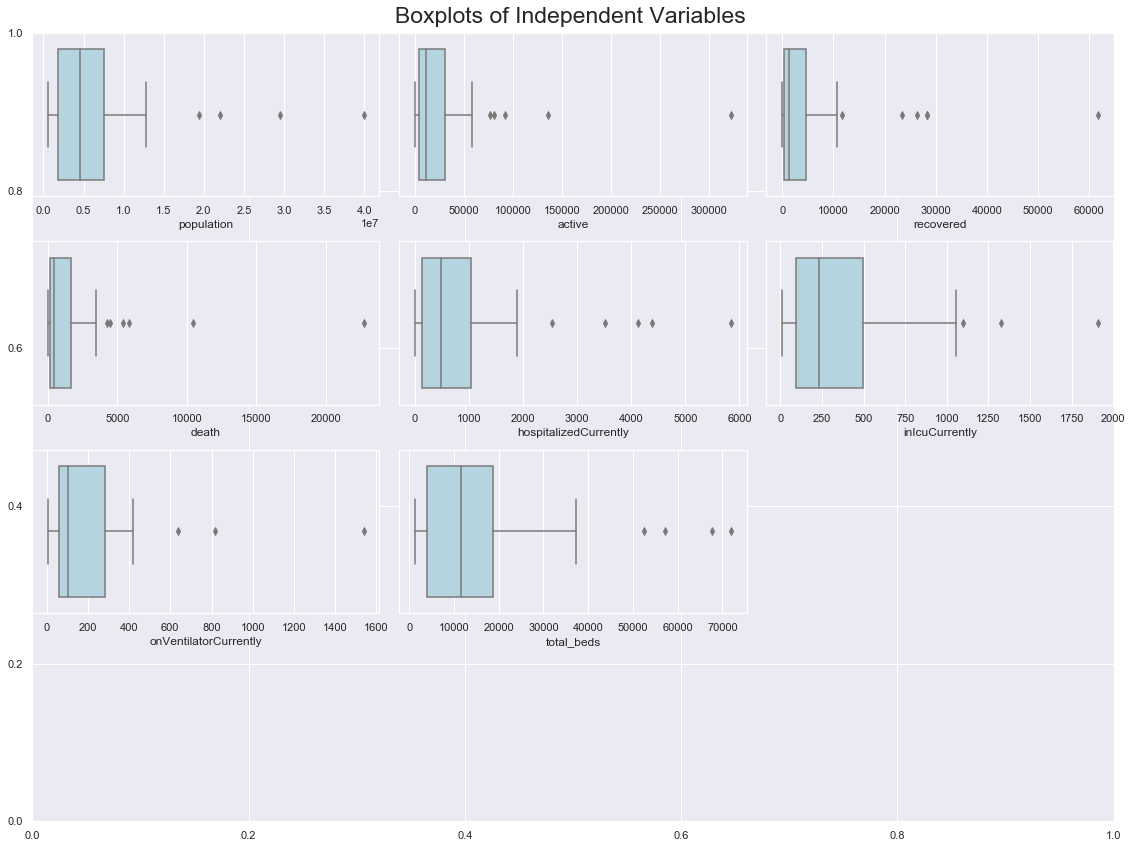

In [33]:
#hide_input

# get data from last day
plot_df_last_date = plot_df.loc[covid_df['date'] == '2020-05-18'] 

fig, ax = plt.subplots(figsize = (16, 12))
for i, col in enumerate(plot_df_last_date.columns):
    ax=fig.add_subplot(4, 3, i+1) 
    sns.boxplot(x=plot_df_last_date[col], data=plot_df, color='lightblue', showfliers=True)
    plt.suptitle('Boxplots of Independent Variables', fontsize=23)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

## Analysis of Hospitalizations by State



### New York:

C:\Users\Doctor Gomez\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_converter.py:129: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



Text(0, 0.5, 'No. Patients')

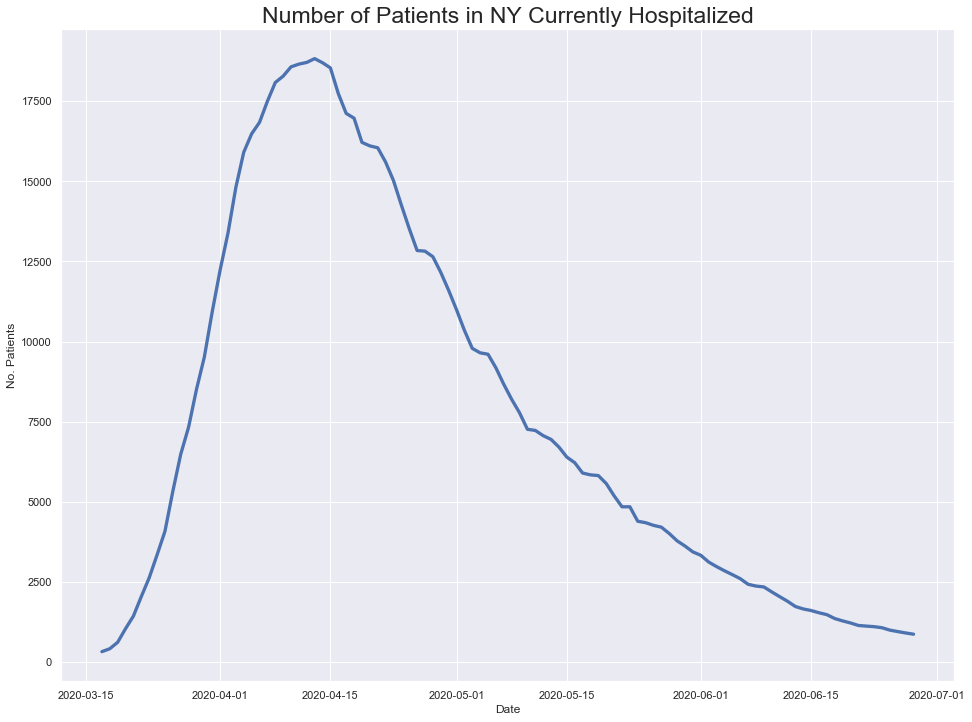

In [34]:
#hide_input
# Split covid_df into subset with only NY values
new_york = covid_df.loc[covid_df['abbrev'] == 'NY'] 
fig, ax = plt.subplots(figsize = (16, 12))
# Timeseries plt
plt.plot(new_york.date, new_york.hospitalizedCurrently, linewidth=3.3)
plt.title('Number of Patients in NY Currently Hospitalized', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

In [35]:
#hide_input
# Omit the categorical and date cols 
new_york = new_york[['positive', 'active', 'hospitalizedCurrently', 'hospitalizedCumulative', 'inIcuCurrently', 'recovered', 'death', 'hospitalized']]

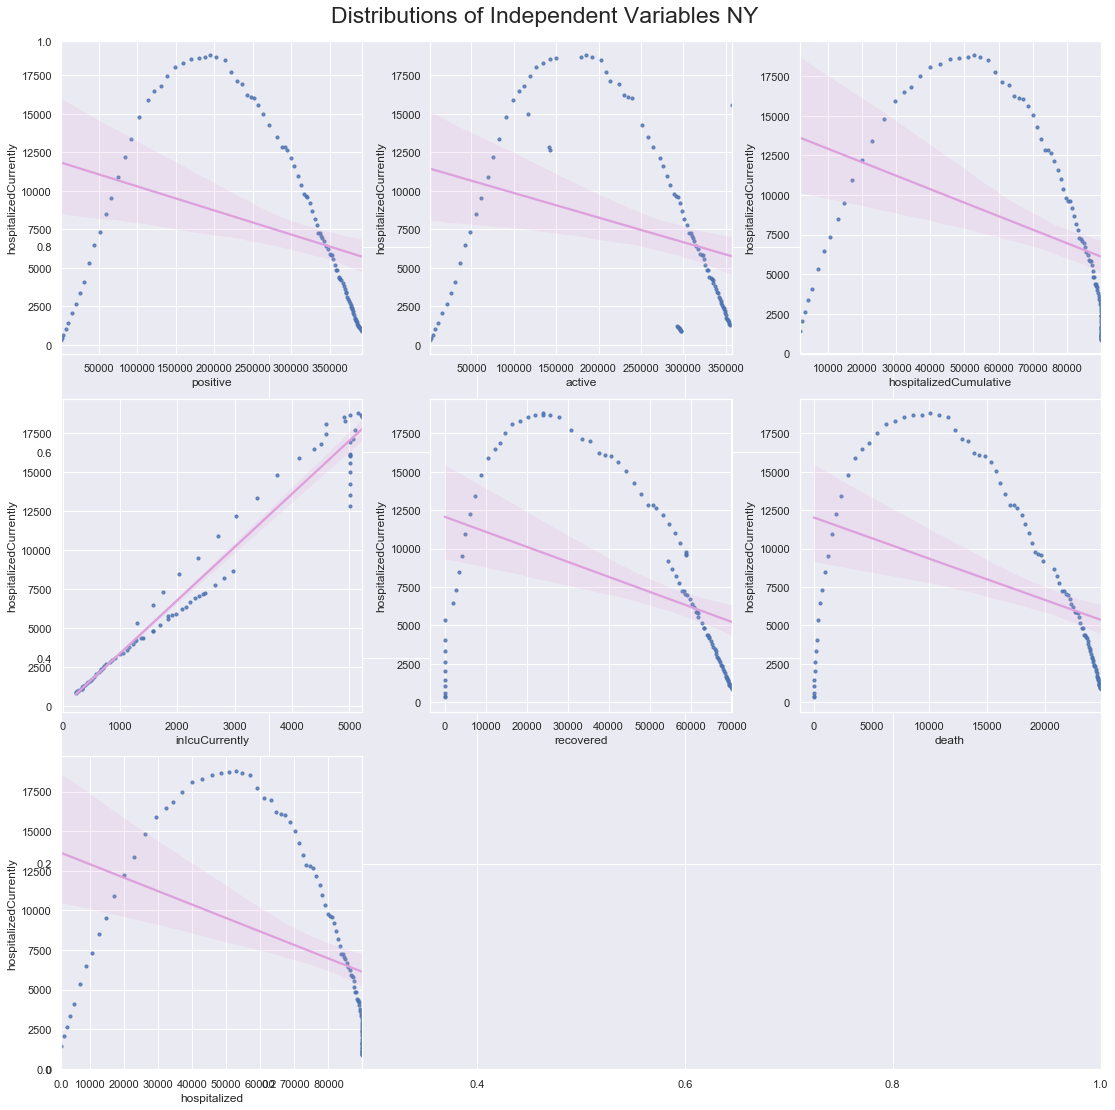

In [36]:
#hide_input
# Scatter plots NY
# Split dependent var from independent variables
target_ny = new_york.hospitalizedCurrently
indep_var_ny = new_york.drop(columns=['hospitalizedCurrently'])

fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(indep_var_ny.columns):
    ax=fig.add_subplot(3, 3, i+1) 
    sns.regplot(x=indep_var_ny[col], y=target_ny, data=indep_var_ny, label=col, scatter_kws={'s':10}, line_kws={"color": "plum"})
    plt.suptitle('Distributions of Independent Variables NY', fontsize=23)
plt.tight_layout()
fig.subplots_adjust(top=0.95)


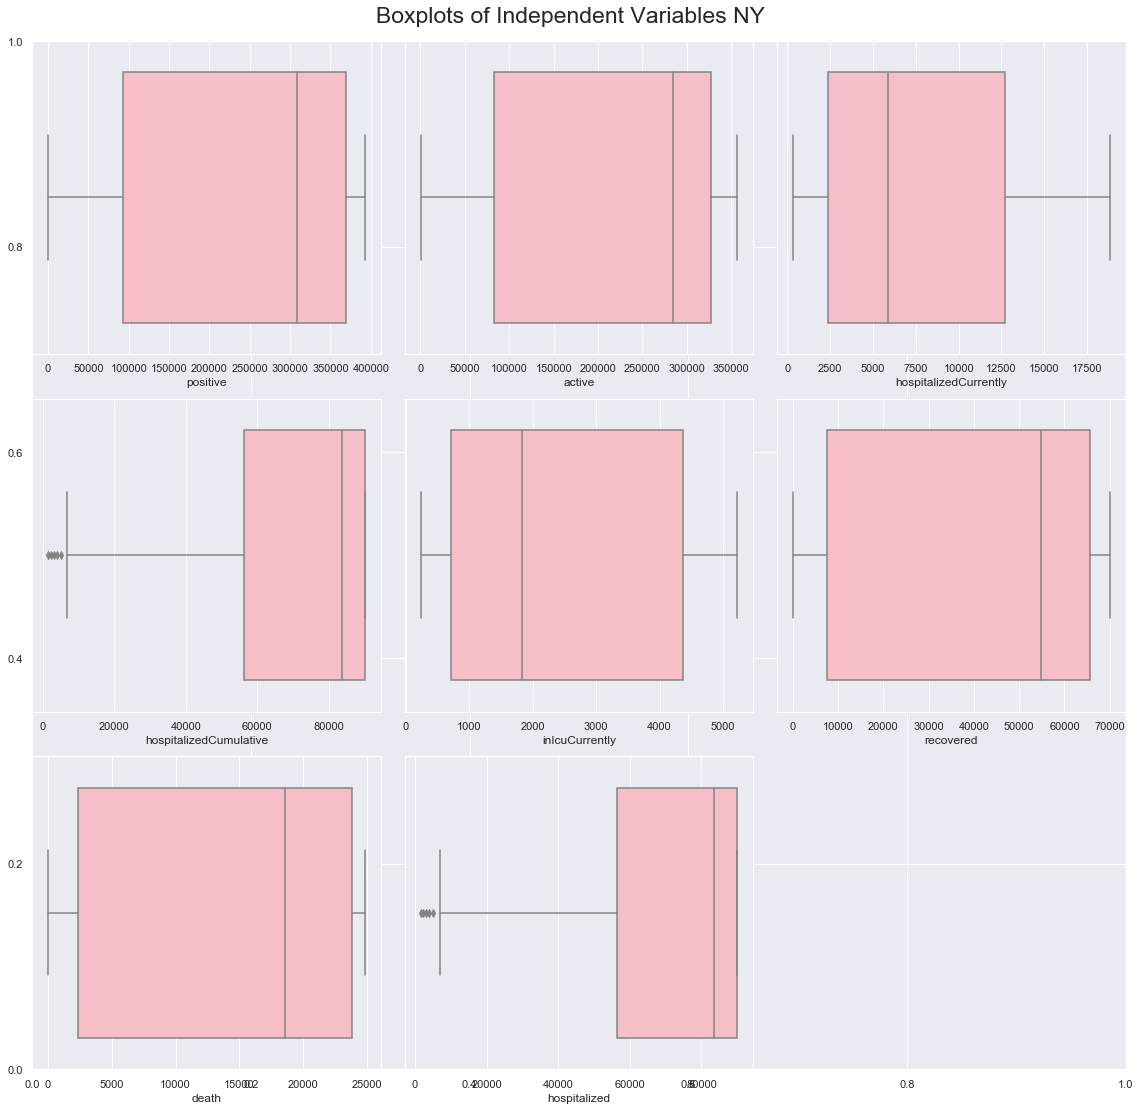

In [37]:
#hide_input
# Boxplot of NY
fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(new_york.columns):
    ax=fig.add_subplot(3, 3, i+1) 
    sns.boxplot(x=new_york[col], data=new_york, color='lightpink', showfliers=True)
    plt.suptitle('Boxplots of Independent Variables NY', fontsize=23)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

### Alabama:

In [38]:
#hide_input
bama = covid_df.loc[(covid_df['abbrev'] == 'AL') & (covid_df['state']== 'Alabama')] 


Text(0, 0.5, 'No. Patients')

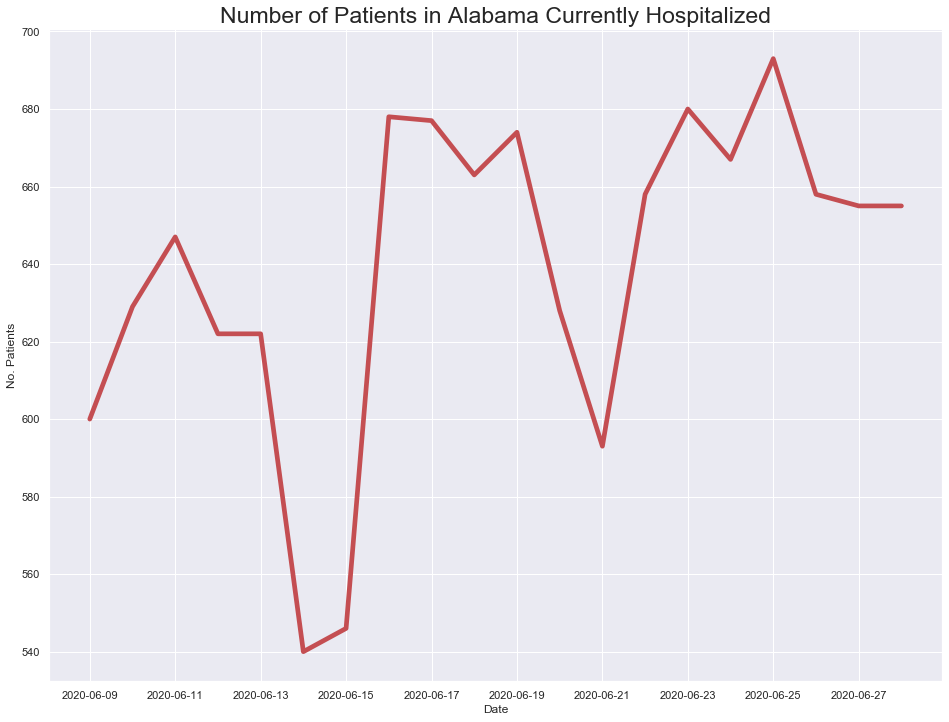

In [39]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(bama.date, bama.hospitalizedCurrently, linewidth=4.7, color='r')
plt.title('Number of Patients in Alabama Currently Hospitalized', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, 'No. Patients')

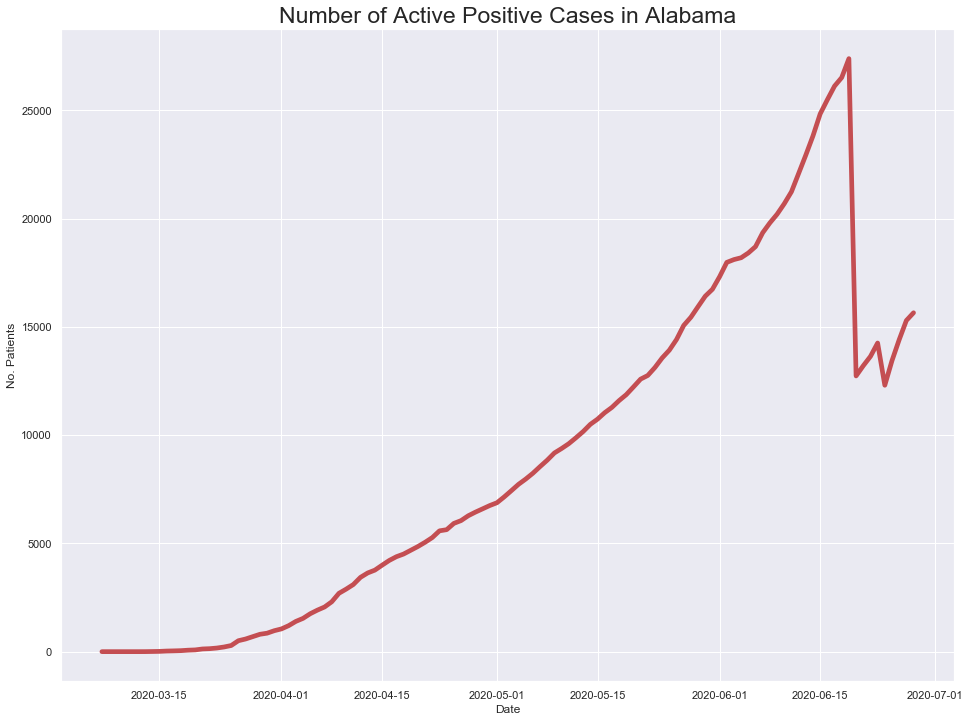

In [40]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(bama.date, bama.active, linewidth=4.7, color='r')
plt.title('Number of Active Positive Cases in Alabama', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, 'No. Patients')

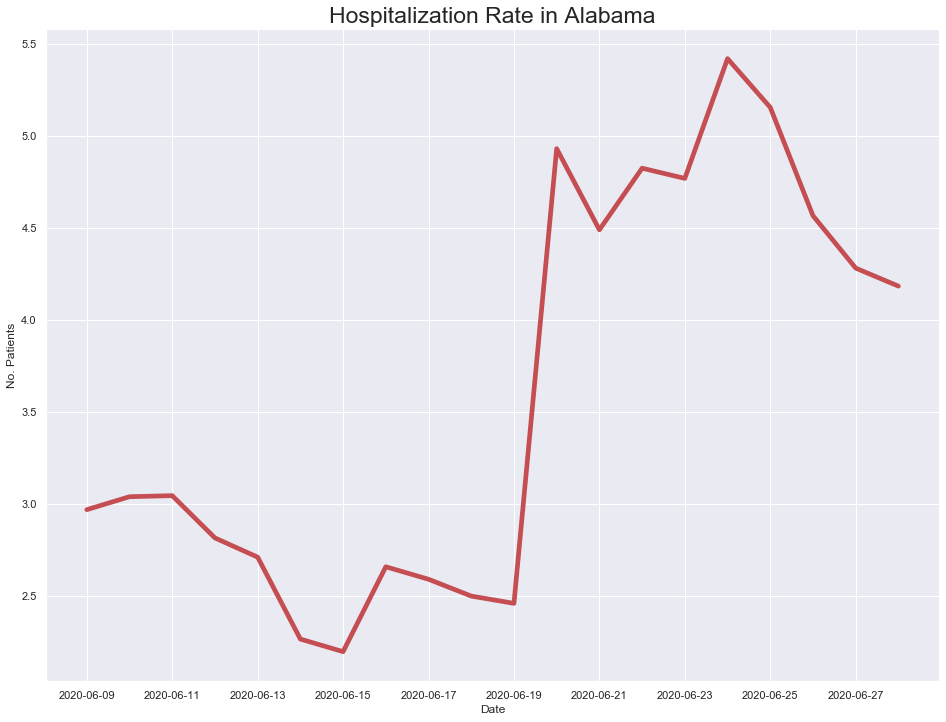

In [41]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(bama.date, bama.hospitalizedCurrently/bama.active*100, linewidth=4.7, color='r')
plt.title('Hospitalization Rate in Alabama', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

In [42]:
#hide_input
# Checking which cols have NaN values
bama[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death', 'hospitalized']]
bama.head()

# Omit the NaN cols
bama = bama[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death']]

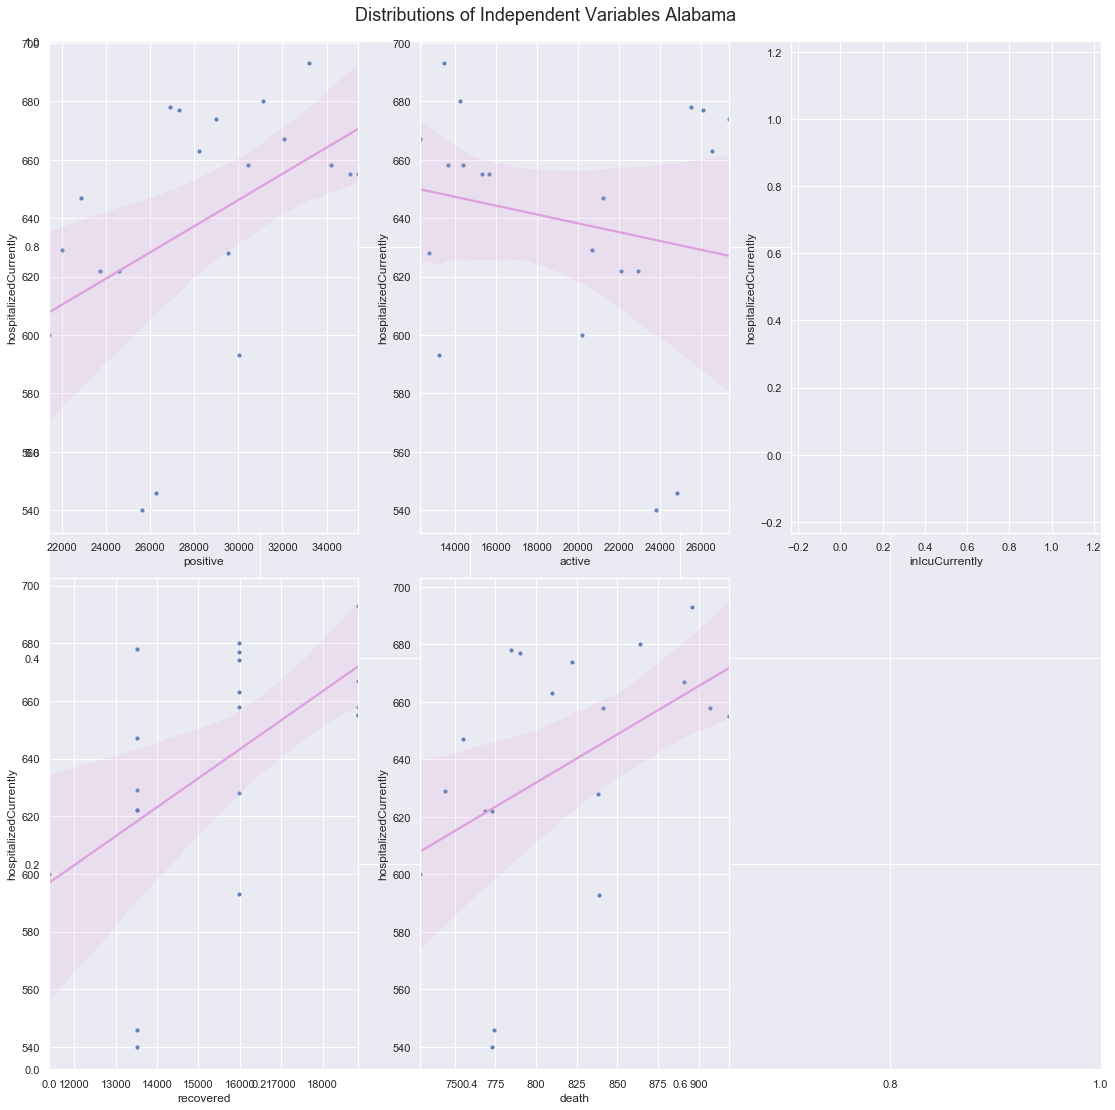

In [43]:
#hide_input
# Scatter plots AL
# Split dependent var from independent variables
target_al = bama.hospitalizedCurrently
indep_var_al = bama.drop(columns=['hospitalizedCurrently'])

fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(indep_var_al.columns):
    ax=fig.add_subplot(2, 3, i+1) 
    sns.regplot(x=indep_var_al[col], y=target_al, data=indep_var_al, label=col, scatter_kws={'s':10}, line_kws={"color": "plum"})
    plt.suptitle('Distributions of Independent Variables Alabama', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

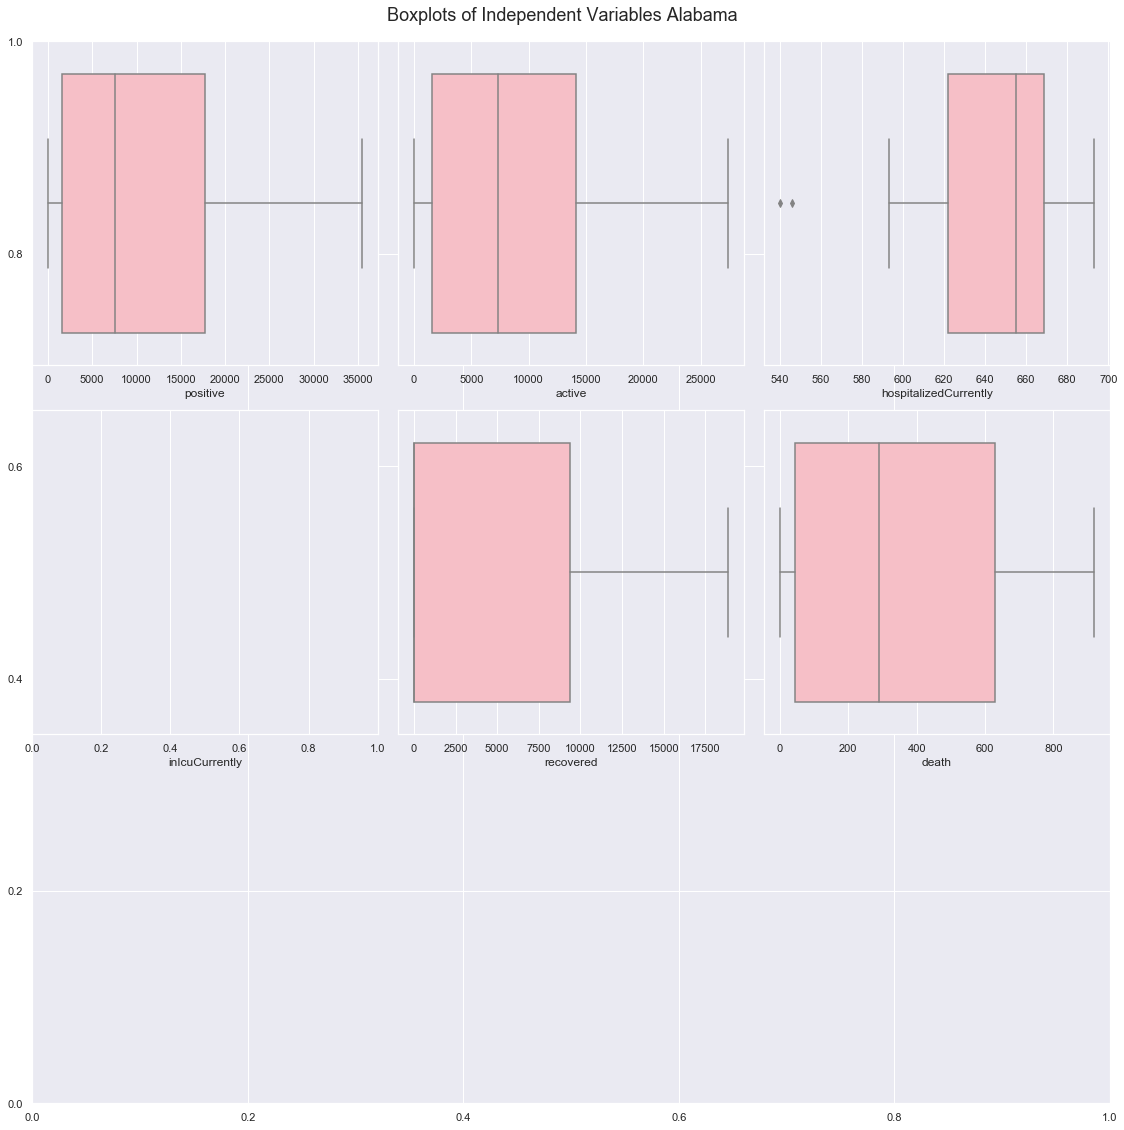

In [44]:
#hide_input
# Boxplot of AL
fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(bama.columns):
    ax=fig.add_subplot(3, 3, i+1) 
    sns.boxplot(x=bama[col], data=bama, color='lightpink', showfliers=True)
    plt.suptitle('Boxplots of Independent Variables Alabama', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

In [45]:
#hide_input
###endalabama

### Arizona:

In [46]:
#hide_input
arizona = covid_df.loc[(covid_df['abbrev'] == 'AZ') & (covid_df['state']== 'Arizona')] 


Text(0, 0.5, 'No. Patients')

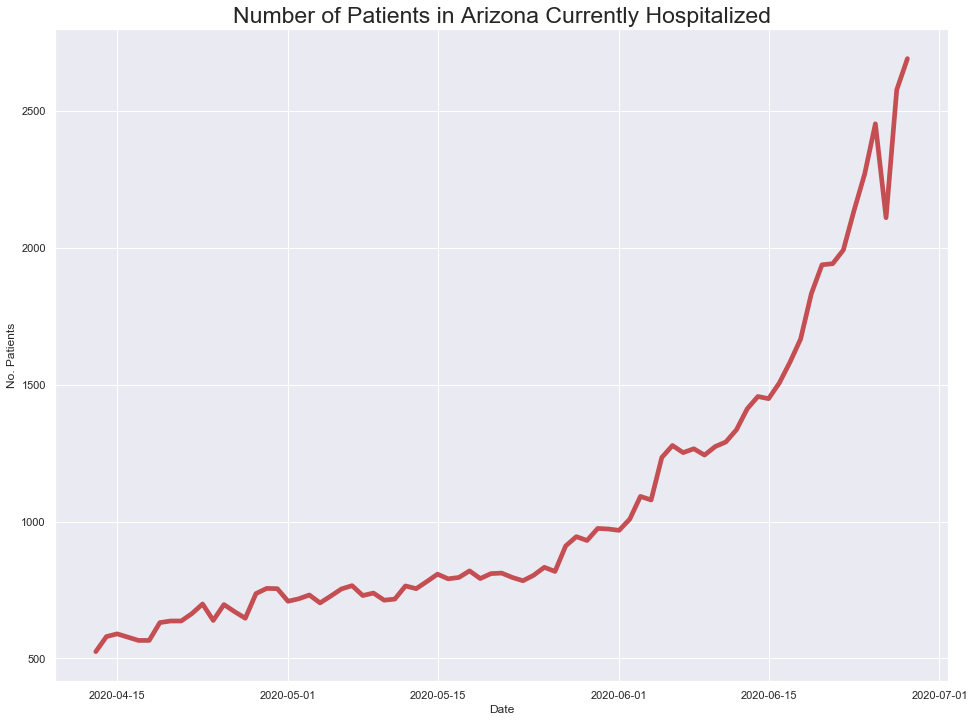

In [47]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(arizona.date, arizona.hospitalizedCurrently, linewidth=4.7, color='r')
plt.title('Number of Patients in Arizona Currently Hospitalized', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, 'No. Patients')

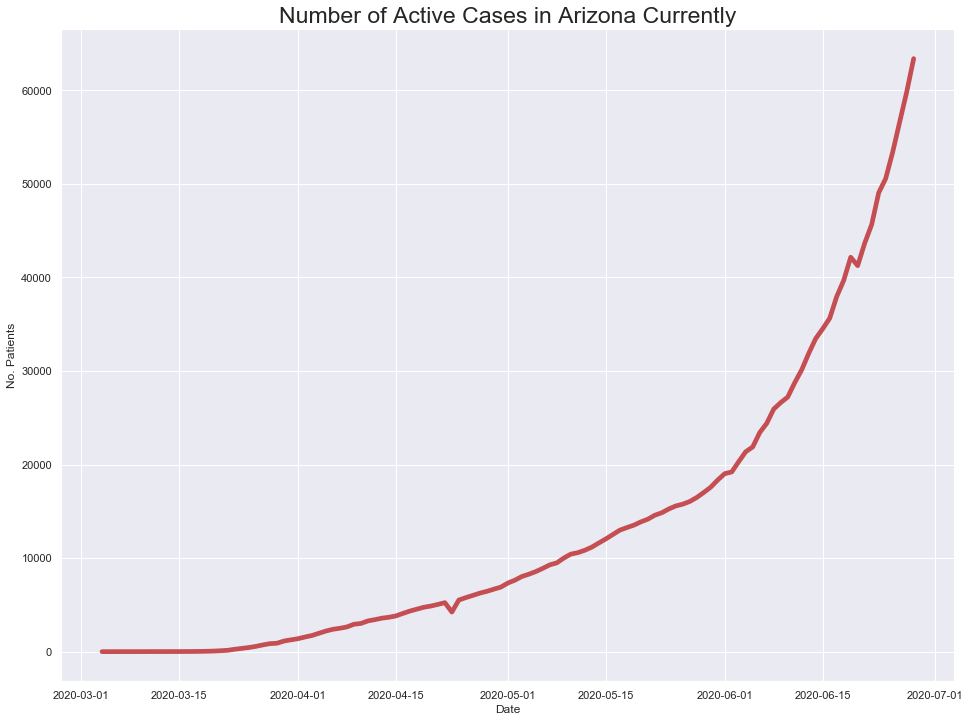

In [48]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(arizona.date, arizona.active, linewidth=4.7, color='r')
plt.title('Number of Active Cases in Arizona Currently', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, 'No. Patients')

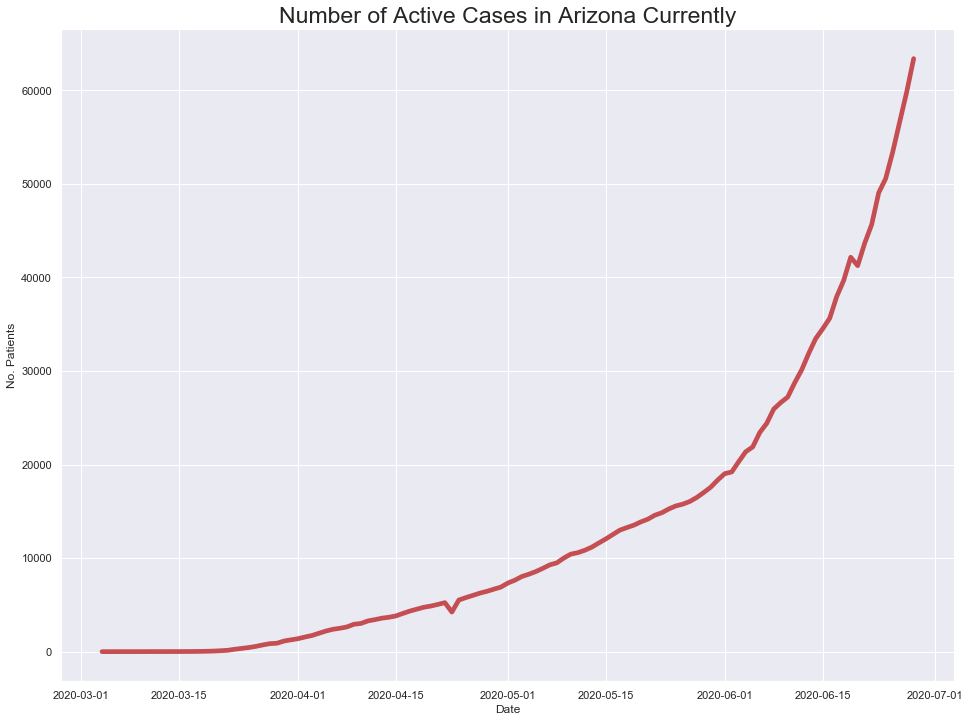

In [49]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(arizona.date, arizona.active, linewidth=4.7, color='r')
plt.title('Number of Active Cases in Arizona Currently', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, '% Positive Cases in Hospital')

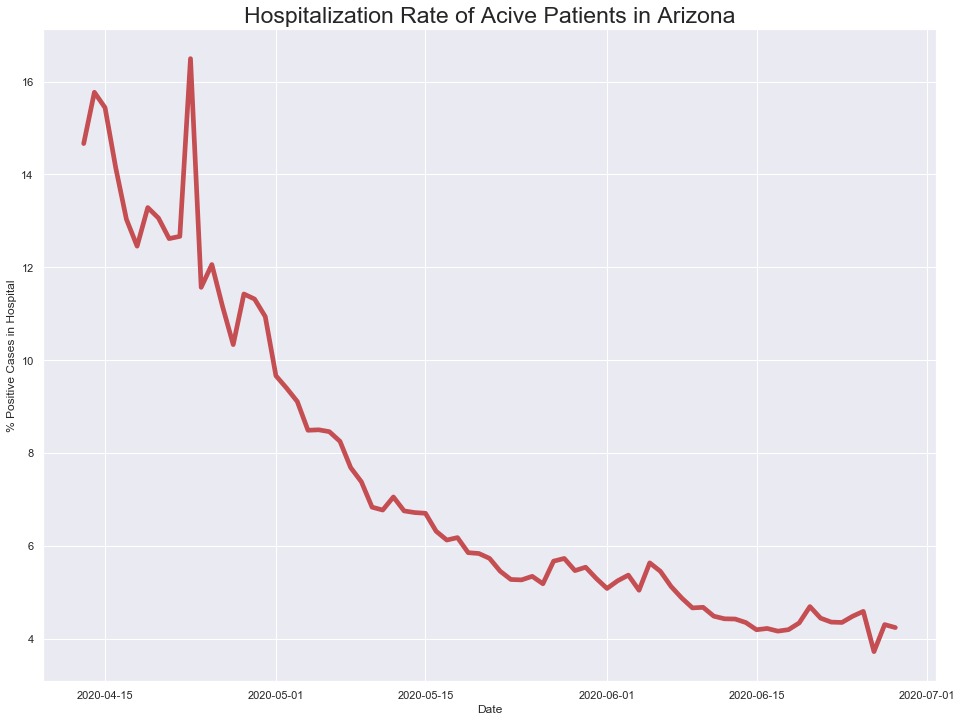

In [50]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(arizona.date, arizona.hospitalizedCurrently/arizona.active*100, linewidth=4.7, color='r')
plt.title('Hospitalization Rate of Acive Patients in Arizona', fontsize=23)
plt.xlabel('Date')
plt.ylabel('% Positive Cases in Hospital')

Text(0, 0.5, 'No. Patients')

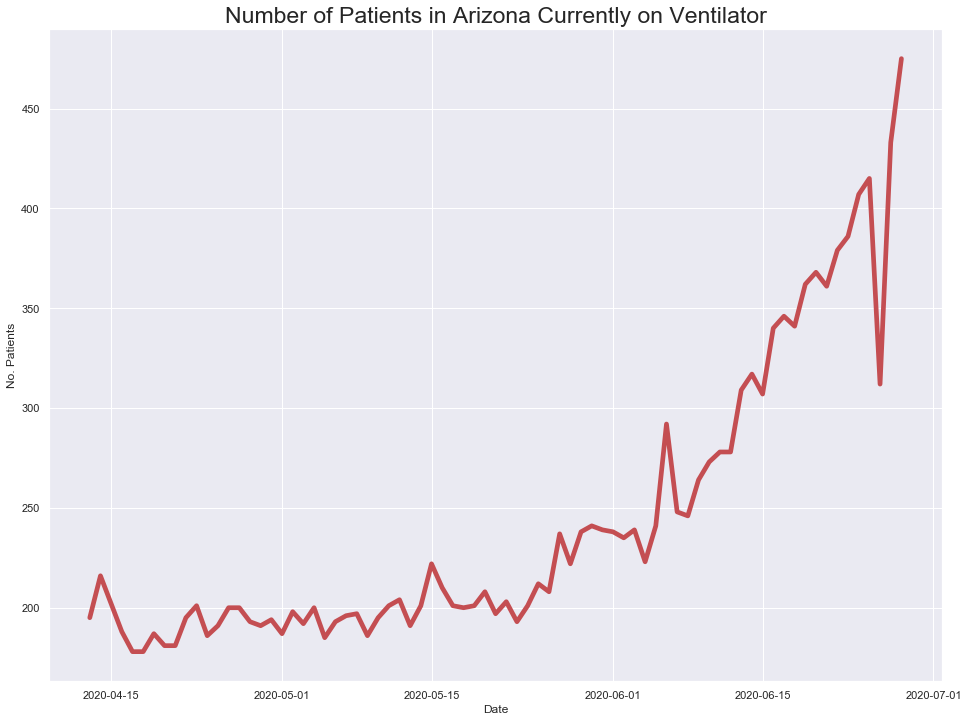

In [51]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(arizona.date, arizona.onVentilatorCurrently, linewidth=4.7, color='r')
plt.title('Number of Patients in Arizona Currently on Ventilator', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

In [52]:
#hide_input
# Checking which cols have NaN values
arizona[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death', 'hospitalized']]
arizona.head()

# Omit the NaN cols
arizona = arizona[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death']]

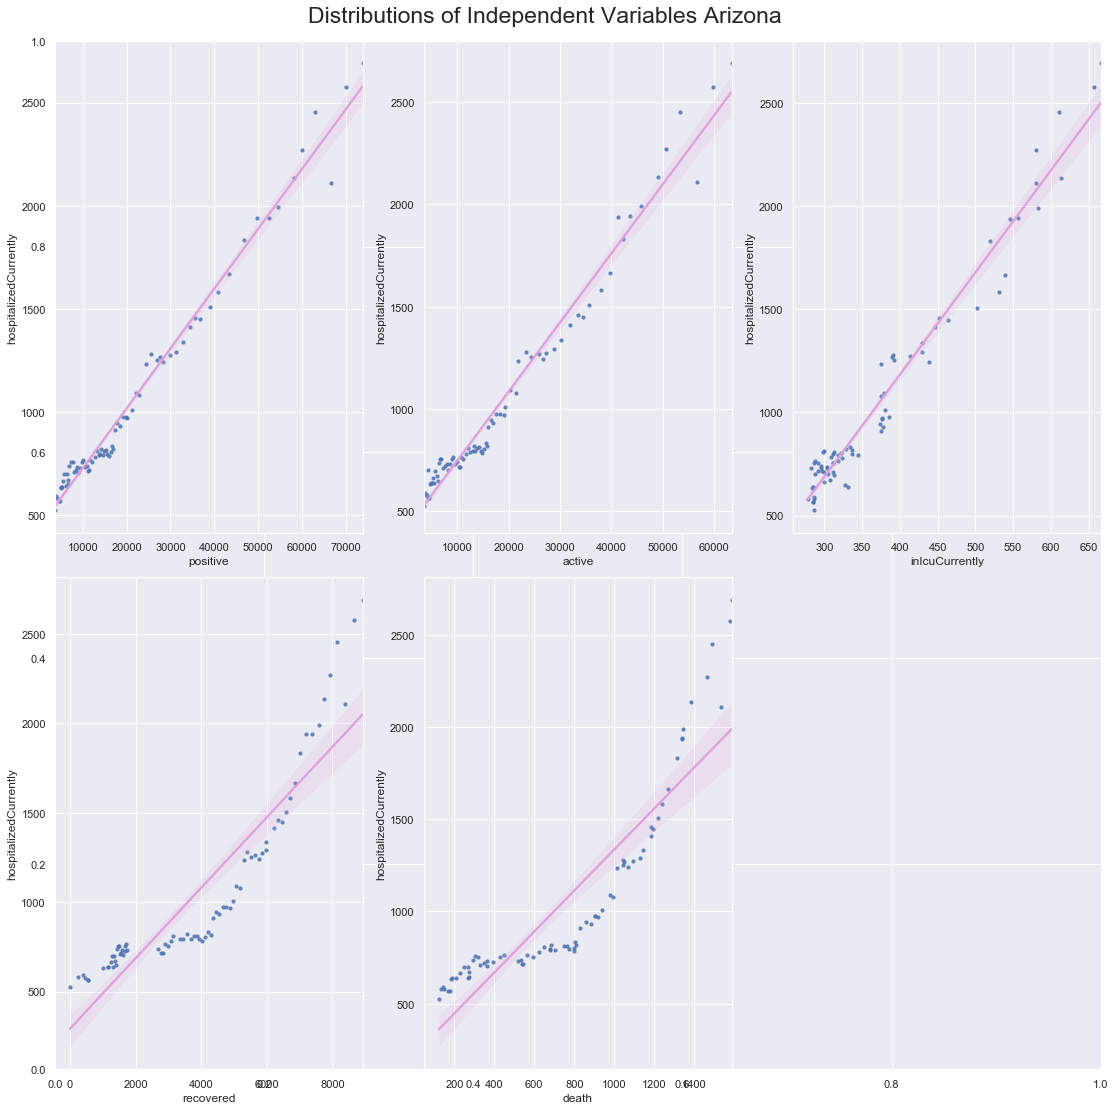

In [53]:
#hide_input
# Scatter plots AZ
# Split dependent var from independent variables
target_az = arizona.hospitalizedCurrently
indep_var_az = arizona.drop(columns=['hospitalizedCurrently'])

fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(indep_var_az.columns):
    ax=fig.add_subplot(2, 3, i+1) 
    sns.regplot(x=indep_var_az[col], y=target_az, data=indep_var_az, label=col, scatter_kws={'s':10}, line_kws={"color": "plum"})
    plt.suptitle('Distributions of Independent Variables Arizona', fontsize=23)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

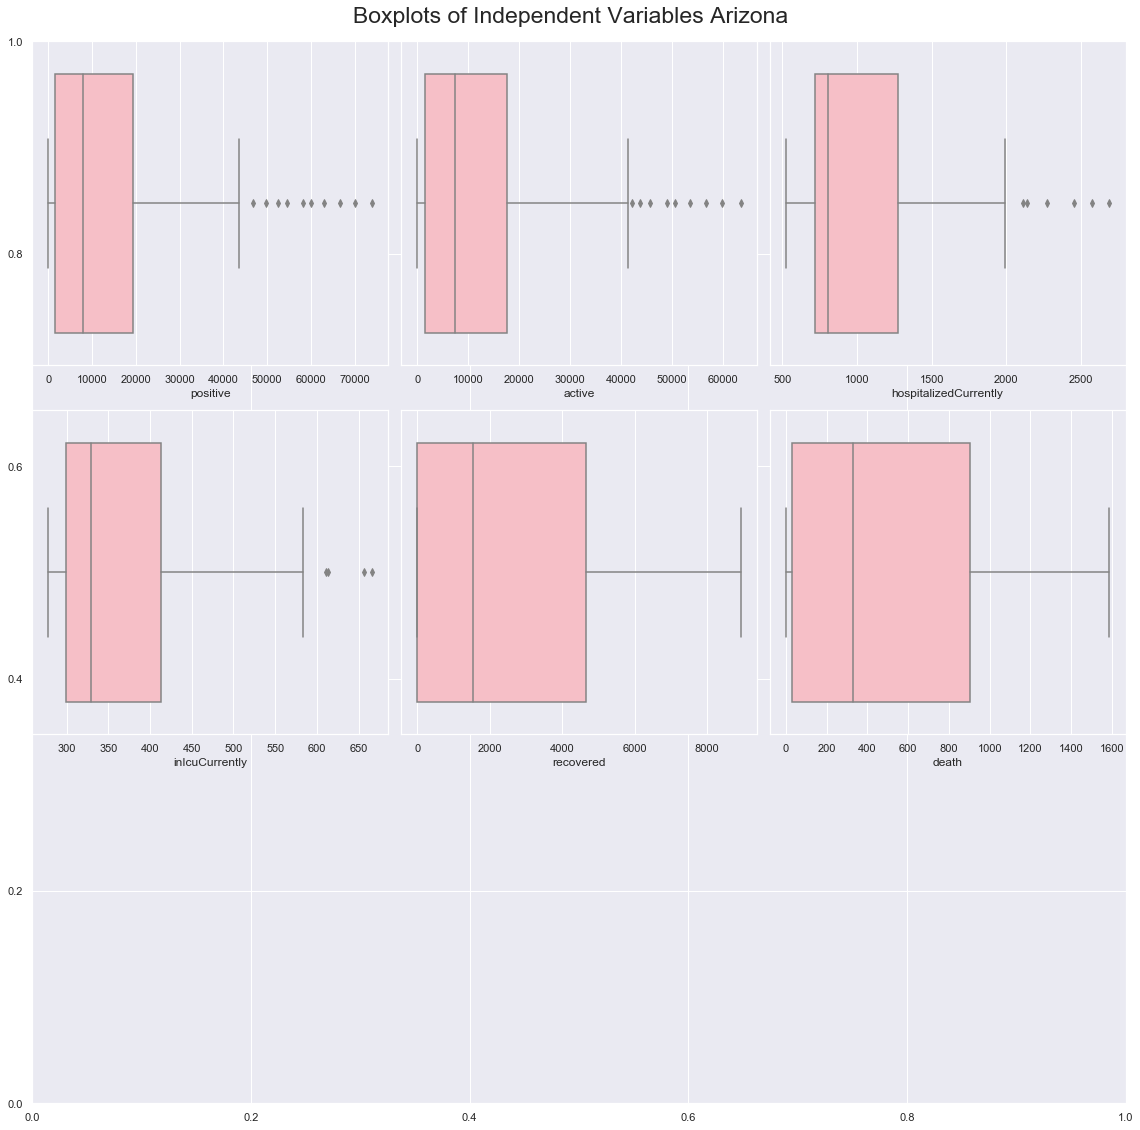

In [54]:
#hide_input
# Boxplot of AZ
fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(arizona.columns):
    ax=fig.add_subplot(3, 3, i+1) 
    sns.boxplot(x=arizona[col], data=arizona, color='lightpink', showfliers=True)
    plt.suptitle('Boxplots of Independent Variables Arizona', fontsize=23)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

In [55]:
#hide_input
###endarizona

### Arkansas:

In [56]:
#hide_input
arkansas = covid_df.loc[(covid_df['abbrev'] == 'AR') & (covid_df['state']== 'Arkansas')] 


Text(0, 0.5, 'No. Patients')

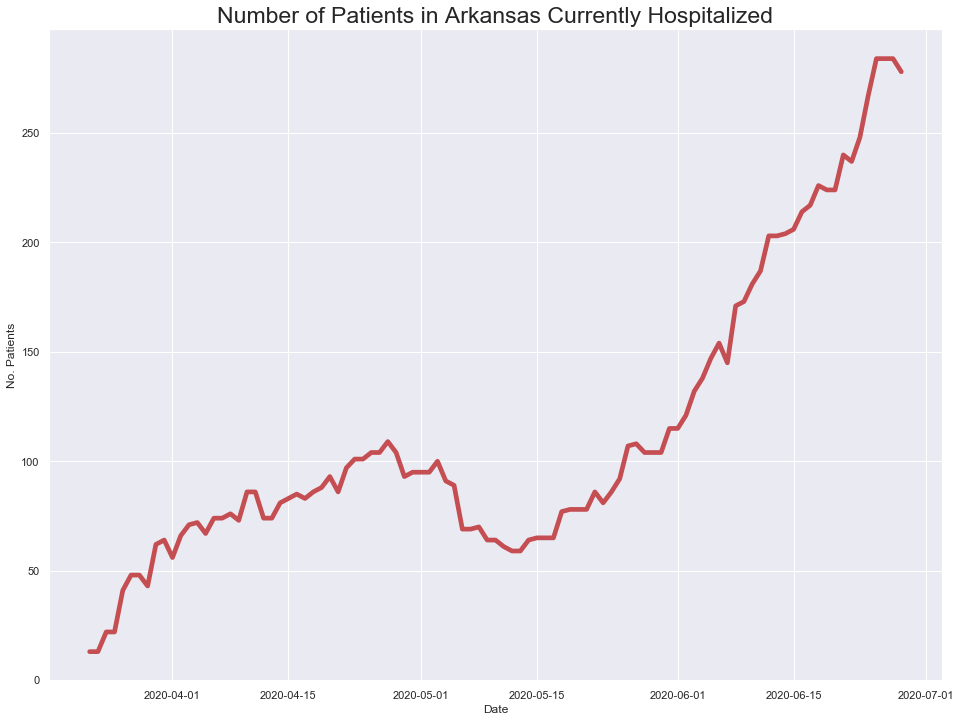

In [57]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(arkansas.date, arkansas.hospitalizedCurrently, linewidth=4.7, color='r')
plt.title('Number of Patients in Arkansas Currently Hospitalized', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, 'No. Patients')

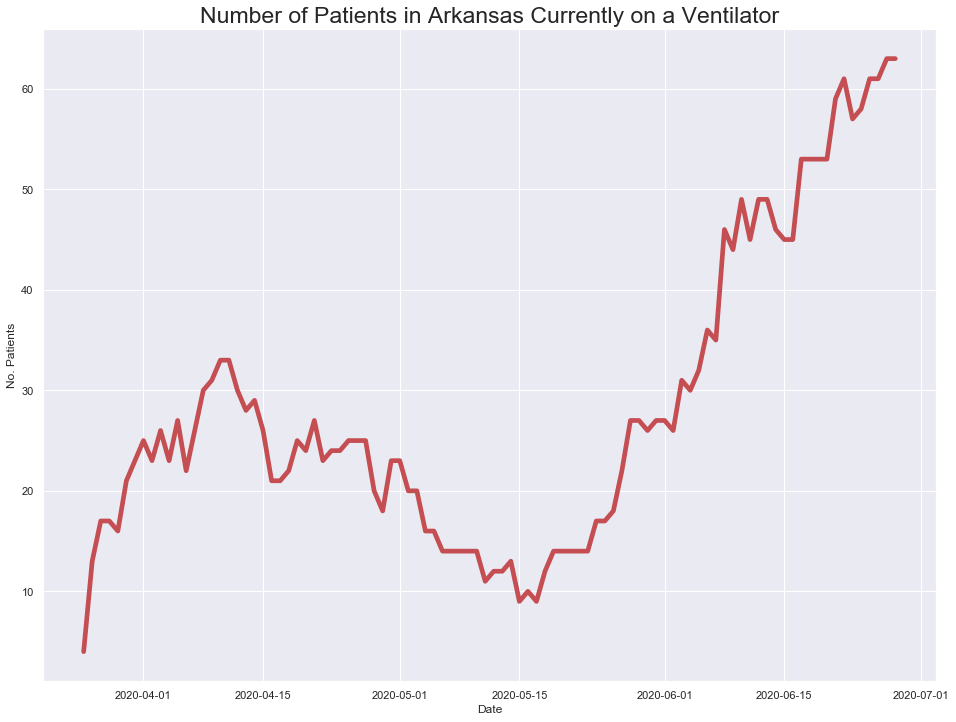

In [58]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(arkansas.date, arkansas.onVentilatorCurrently, linewidth=4.7, color='r')
plt.title('Number of Patients in Arkansas Currently on a Ventilator', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, 'No. Patients')

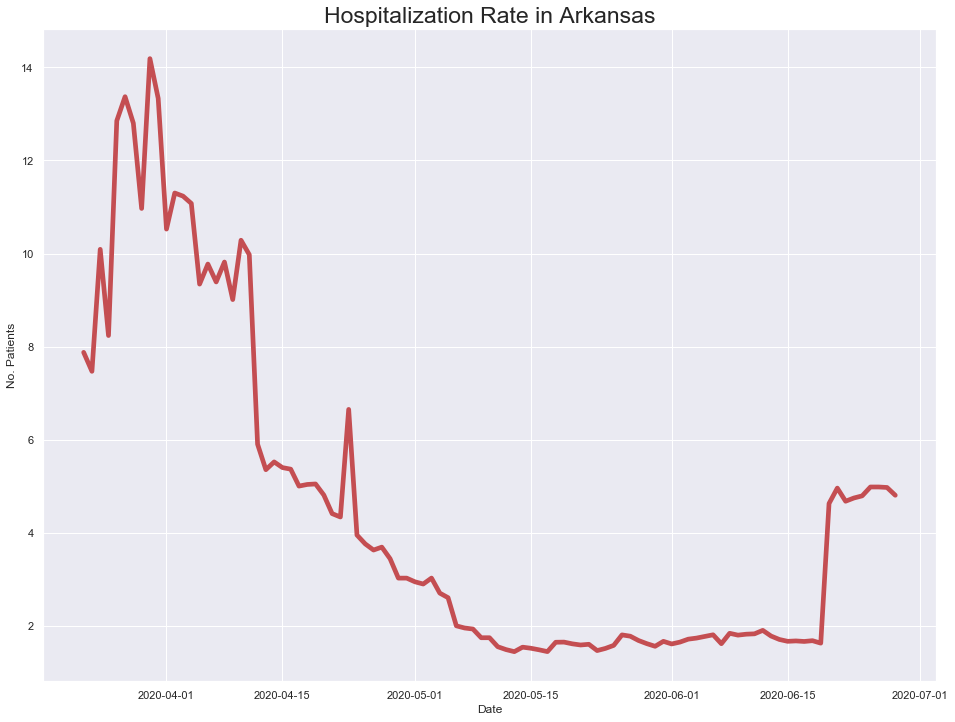

In [59]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(arkansas.date, arkansas.hospitalizedCurrently/arkansas.active*100, linewidth=4.7, color='r')
plt.title('Hospitalization Rate in Arkansas', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

In [60]:
#hide_input
# Checking which cols have NaN values
arkansas[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death', 'hospitalized']]
arkansas.head()

# Omit the NaN cols
arkansas = arkansas[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death']]

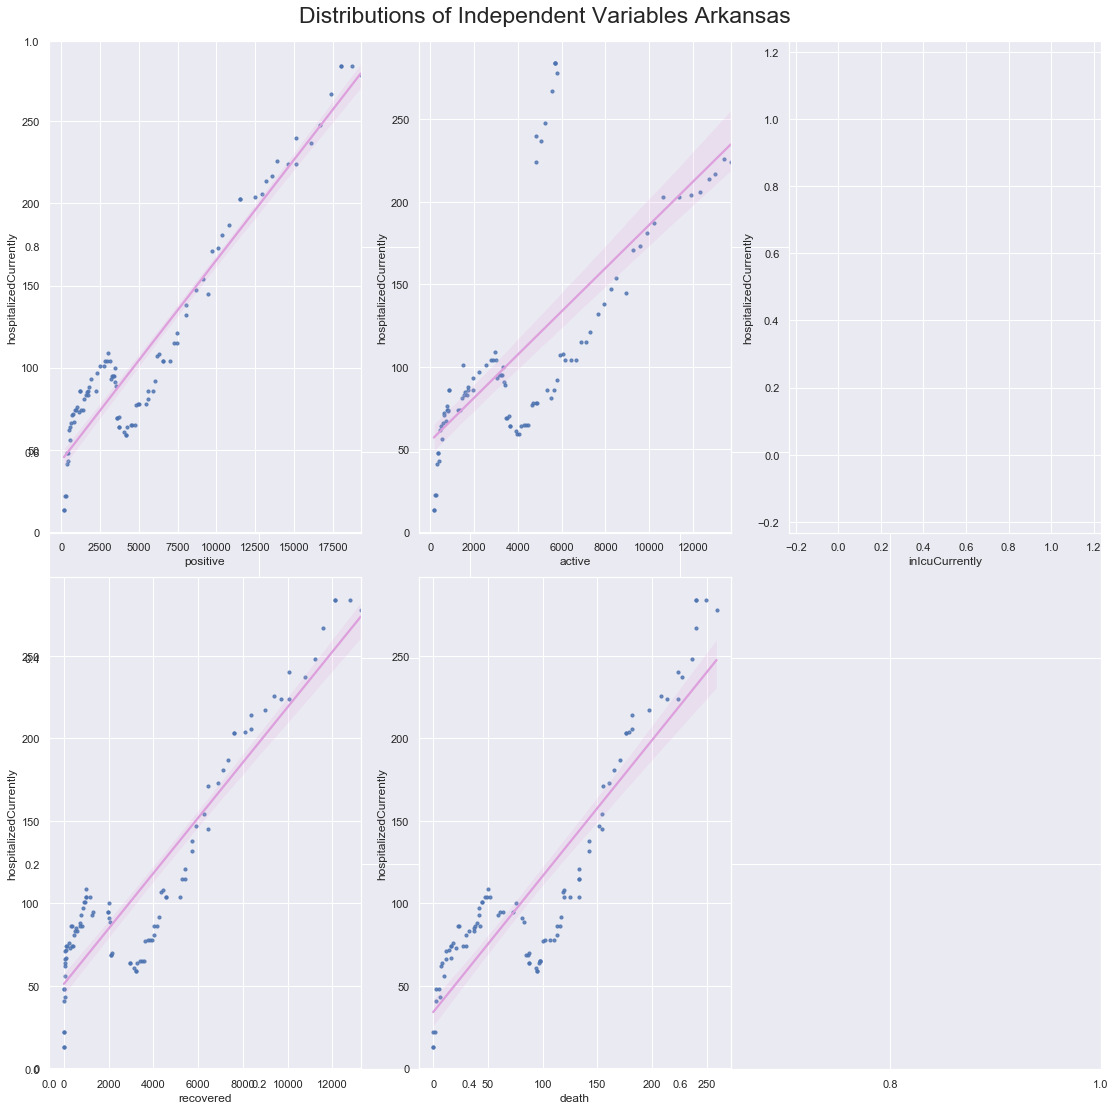

In [61]:
#hide_input
# Scatter plots AK
# Split dependent var from independent variables
target_ak = arkansas.hospitalizedCurrently
indep_var_ak = arkansas.drop(columns=['hospitalizedCurrently'])

fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(indep_var_ak.columns):
    ax=fig.add_subplot(2, 3, i+1) 
    sns.regplot(x=indep_var_ak[col], y=target_ak, data=indep_var_ak, label=col, scatter_kws={'s':10}, line_kws={"color": "plum"})
    plt.suptitle('Distributions of Independent Variables Arkansas', fontsize=23)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

In [62]:
#hide_input
###endarkansas

### California:

In [63]:
#hide_input
cali = covid_df.loc[(covid_df['abbrev'] == 'CA') & (covid_df['state']== 'California')] 


Text(0, 0.5, 'No. Patients')

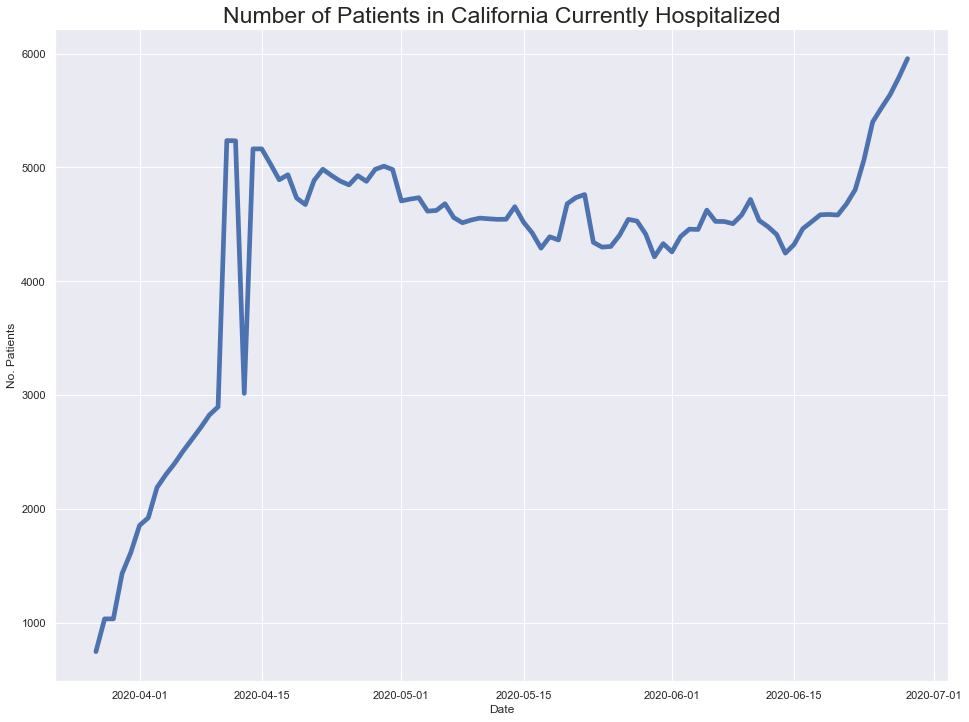

In [64]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(cali.date, cali.hospitalizedCurrently, linewidth=4.7)
plt.title('Number of Patients in California Currently Hospitalized', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, 'No. Patients')

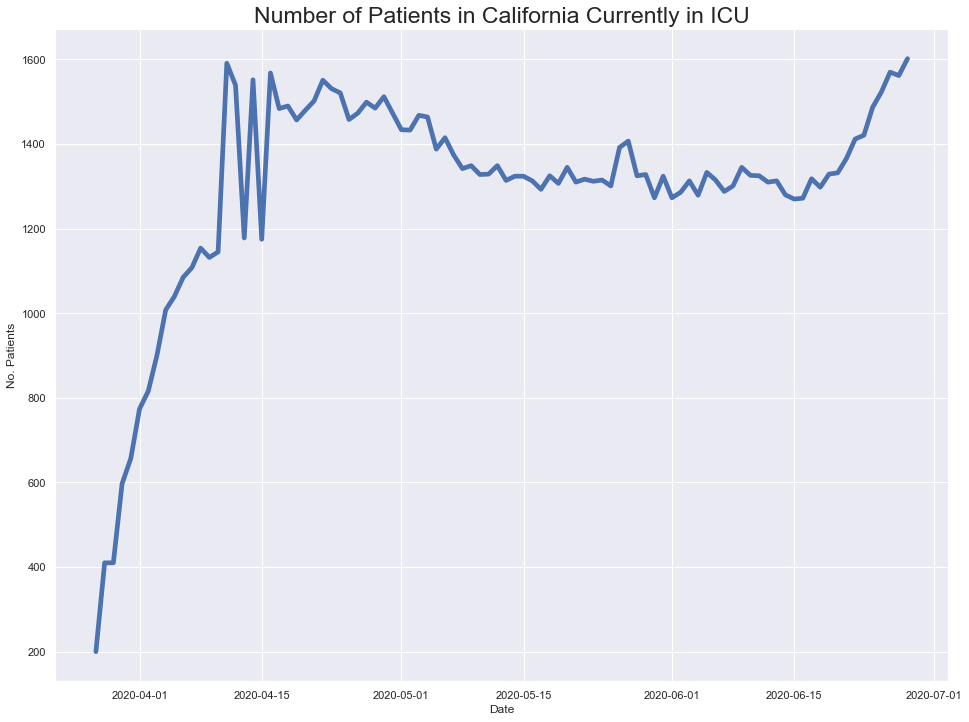

In [65]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(cali.date, cali.inIcuCurrently, linewidth=4.7)
plt.title('Number of Patients in California Currently in ICU', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, 'No. Patients')

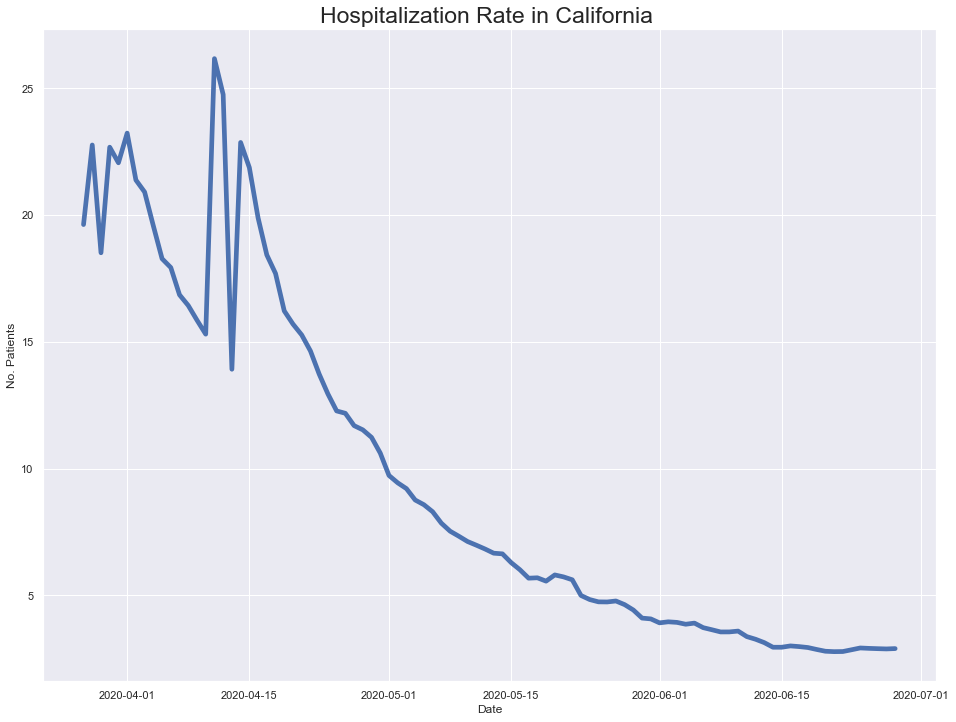

In [66]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(cali.date, cali.hospitalizedCurrently/cali.active*100, linewidth=4.7)
plt.title('Hospitalization Rate in California ', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, 'No. Patients')

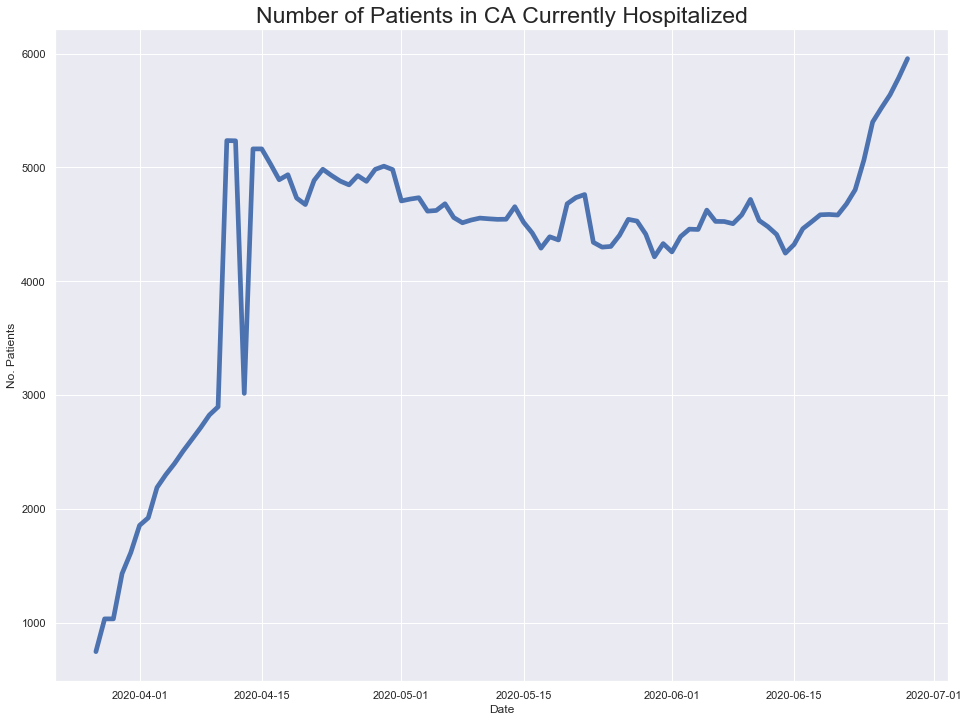

In [67]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(cali.date, cali.hospitalizedCurrently, linewidth=4.7)
plt.title('Number of Patients in CA Currently Hospitalized', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

In [68]:
#hide_input
# Checking which cols have NaN values
cali[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death', 'hospitalized']]
cali.head()

# Omit the NaN cols
cali = cali[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death']]

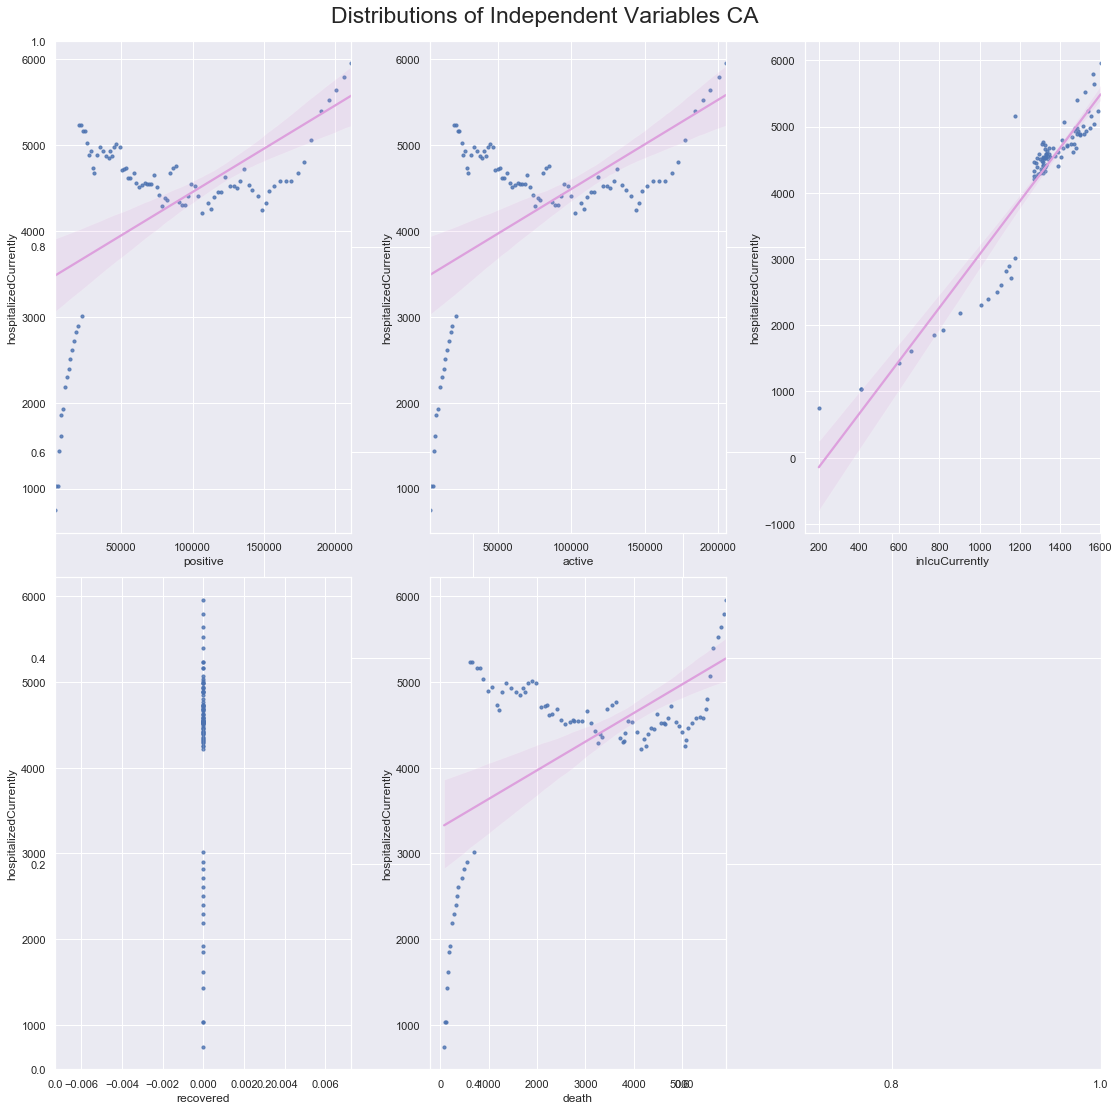

In [69]:
#hide_input
# Scatter plots CA
# Split dependent var from independent variables
target_ca = cali.hospitalizedCurrently
indep_var_ca = cali.drop(columns=['hospitalizedCurrently'])

fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(indep_var_ca.columns):
    ax=fig.add_subplot(2, 3, i+1) 
    sns.regplot(x=indep_var_ca[col], y=target_ca, data=indep_var_ca, label=col, scatter_kws={'s':10}, line_kws={"color": "plum"})
    plt.suptitle('Distributions of Independent Variables CA', fontsize=23)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

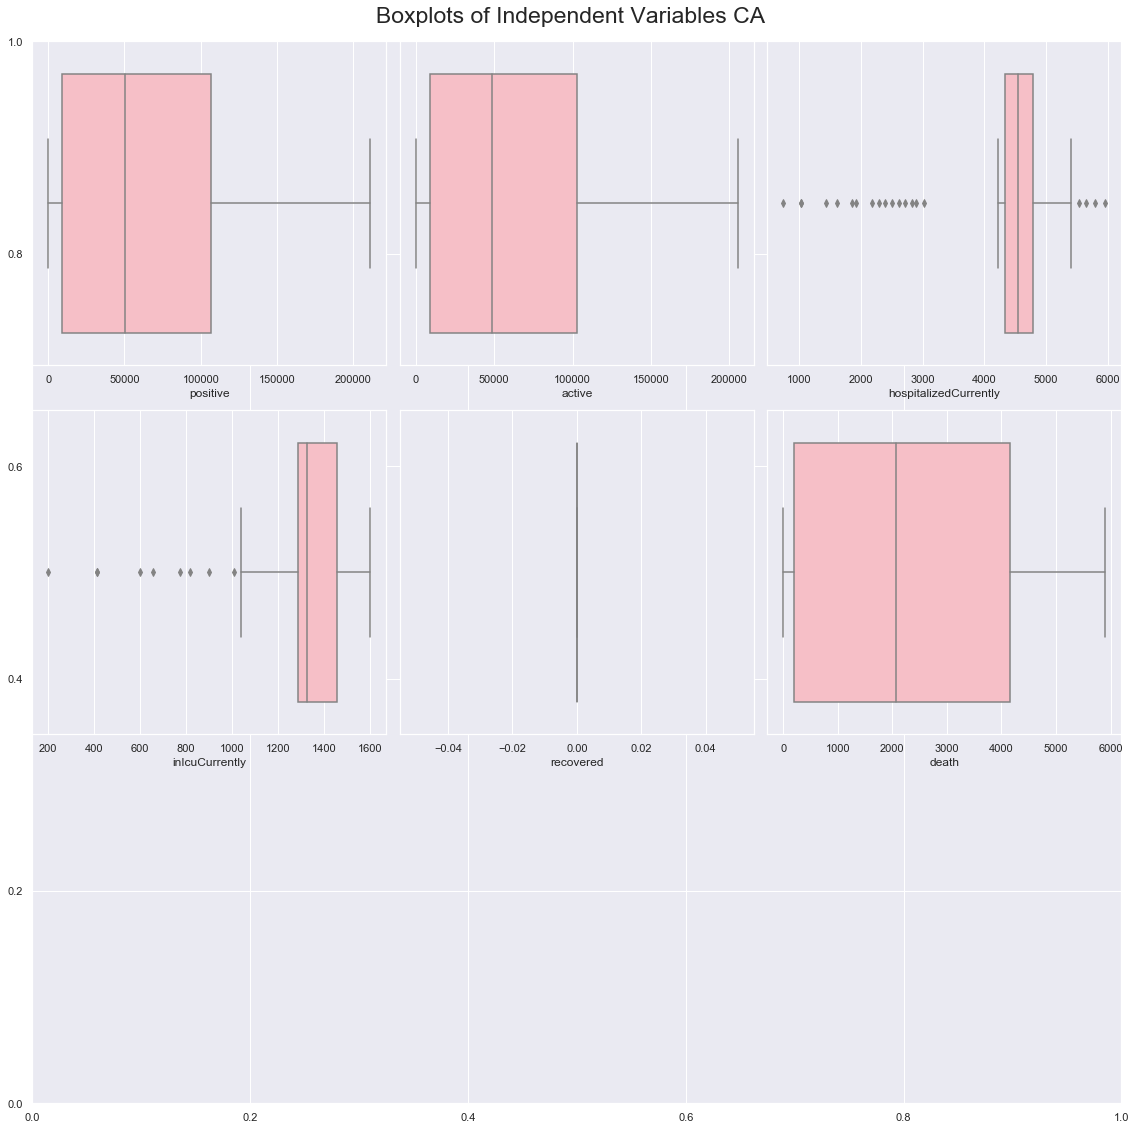

In [70]:
#hide_input
# Boxplot of CA
fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(cali.columns):
    ax=fig.add_subplot(3, 3, i+1) 
    sns.boxplot(x=cali[col], data=cali, color='lightpink', showfliers=True)
    plt.suptitle('Boxplots of Independent Variables CA', fontsize=23)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

In [71]:
#hide_input
###endcali

### Colorado:

In [72]:
#hide_input
colorado = covid_df.loc[(covid_df['abbrev'] == 'CO') & (covid_df['state']== 'Colorado')] 


Text(0, 0.5, 'No. Patients')

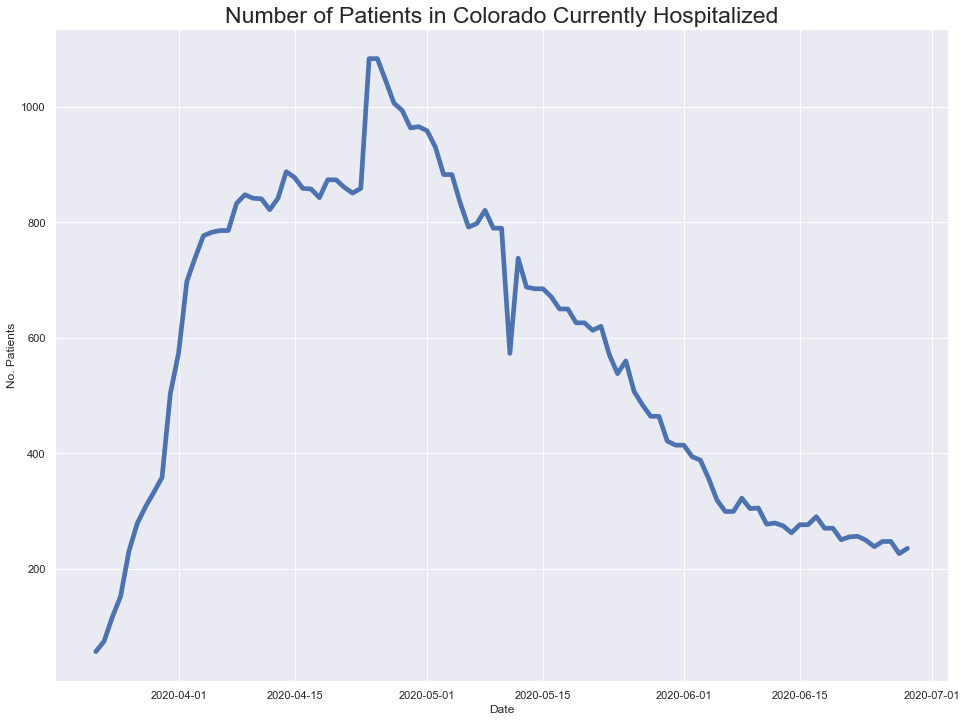

In [73]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(colorado.date, colorado.hospitalizedCurrently, linewidth=4.7)
plt.title('Number of Patients in Colorado Currently Hospitalized', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, 'No. Killed')

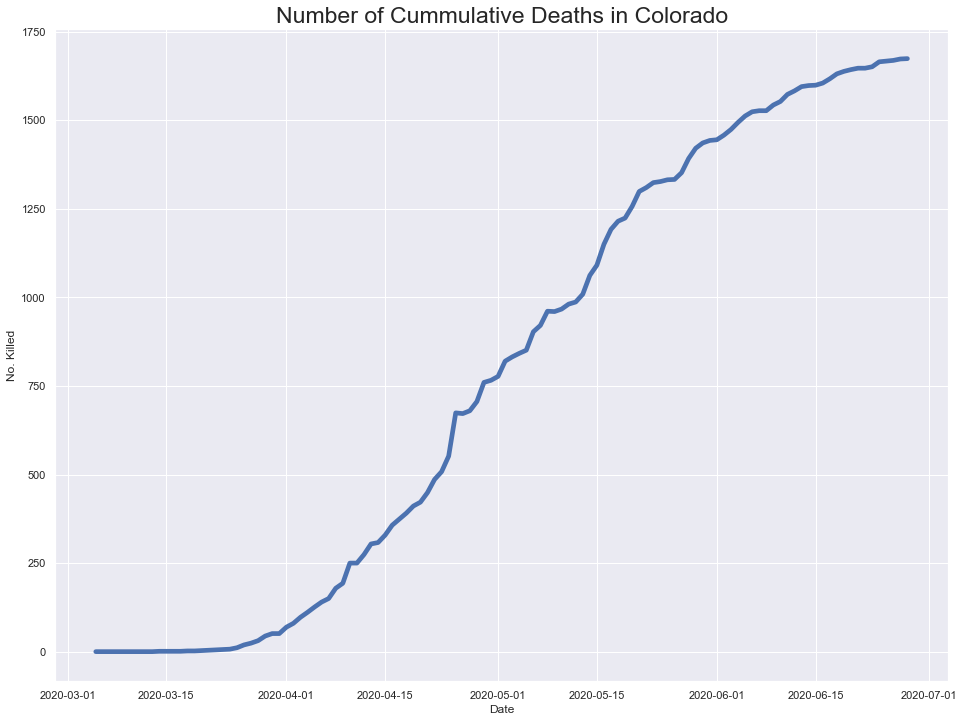

In [74]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(colorado.date, colorado.death, linewidth=4.7)
plt.title('Number of Cummulative Deaths in Colorado', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Killed')

Text(0, 0.5, 'No. Killed')

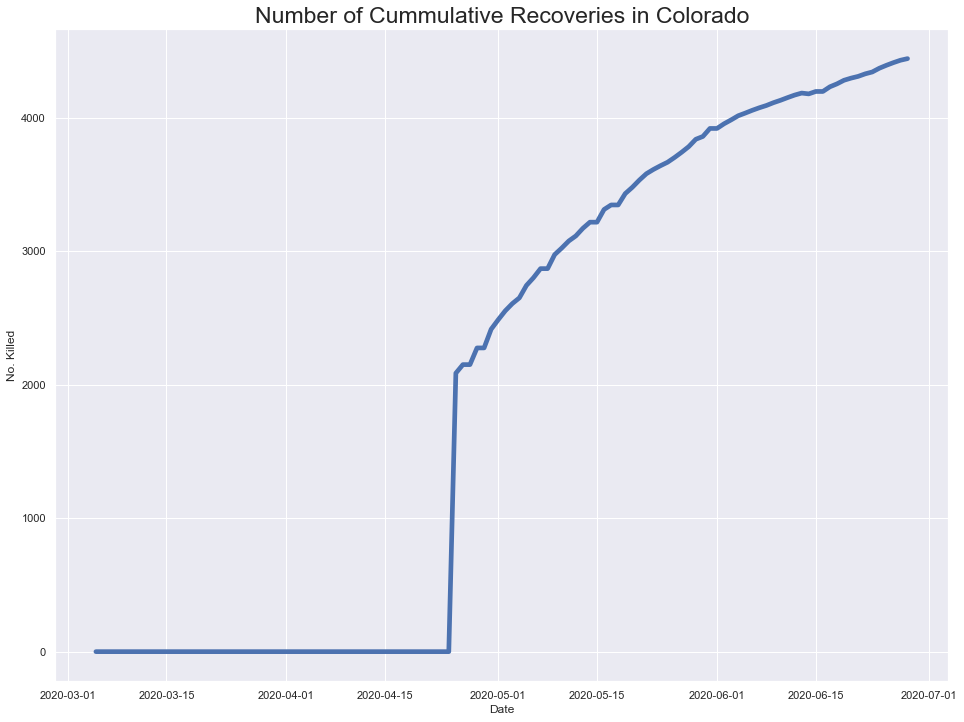

In [75]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(colorado.date, colorado.recovered, linewidth=4.7)
plt.title('Number of Cummulative Recoveries in Colorado', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Killed')

In [76]:
#hide_input
# Checking which cols have NaN values
colorado[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death', 'hospitalized']]
colorado.head()

# Omit the NaN cols
colorado = colorado[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death']]

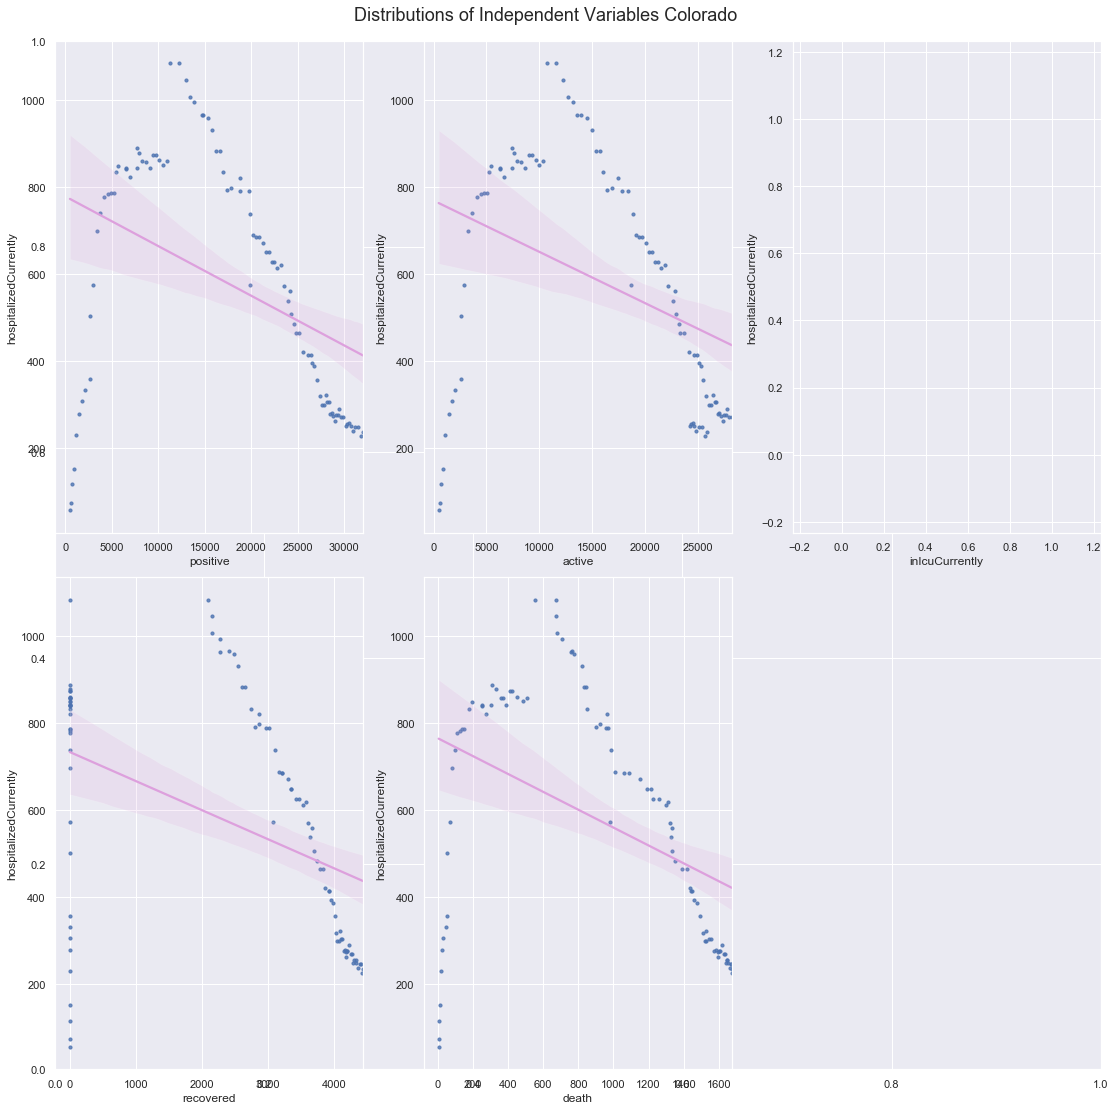

In [77]:
#hide_input
# Scatter plots AL
# Split dependent var from independent variables
target_co = colorado.hospitalizedCurrently
indep_var_co = colorado.drop(columns=['hospitalizedCurrently'])

fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(indep_var_co.columns):
    ax=fig.add_subplot(2, 3, i+1) 
    sns.regplot(x=indep_var_co[col], y=target_co, data=indep_var_co, label=col, scatter_kws={'s':10}, line_kws={"color": "plum"})
    plt.suptitle('Distributions of Independent Variables Colorado', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

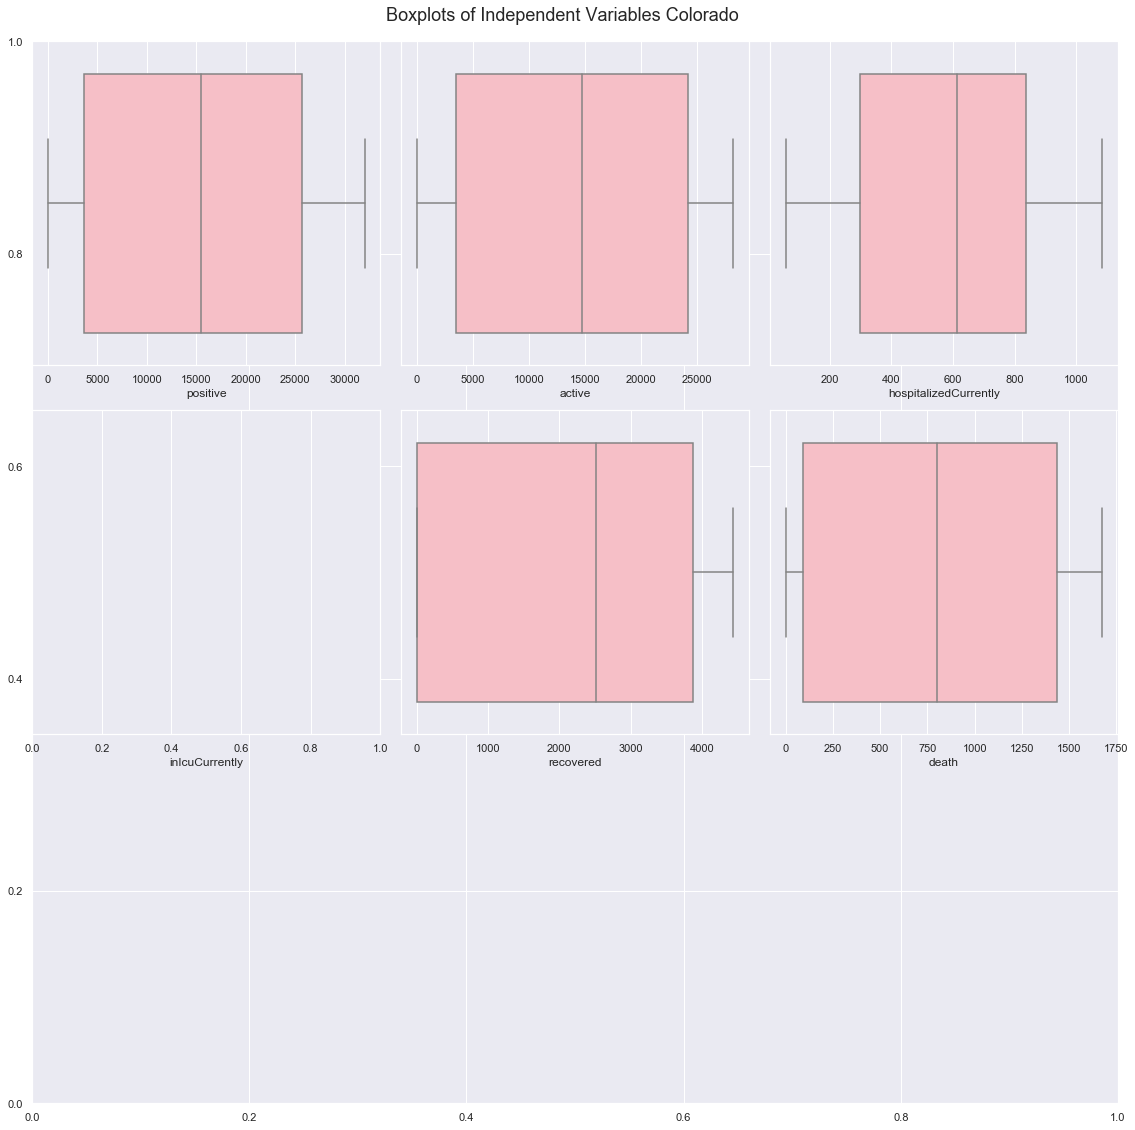

In [78]:
#hide_input
# Boxplot of CO
fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(colorado.columns):
    ax=fig.add_subplot(3, 3, i+1) 
    sns.boxplot(x=colorado[col], data=colorado, color='lightpink', showfliers=True)
    plt.suptitle('Boxplots of Independent Variables Colorado', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

In [79]:
#hide_input
###endcolorado

### Connecticut:

In [80]:
#hide_input
conn = covid_df.loc[(covid_df['abbrev'] == 'CT') & (covid_df['state']== 'Connecticut')] 


Text(0, 0.5, 'No. Patients')

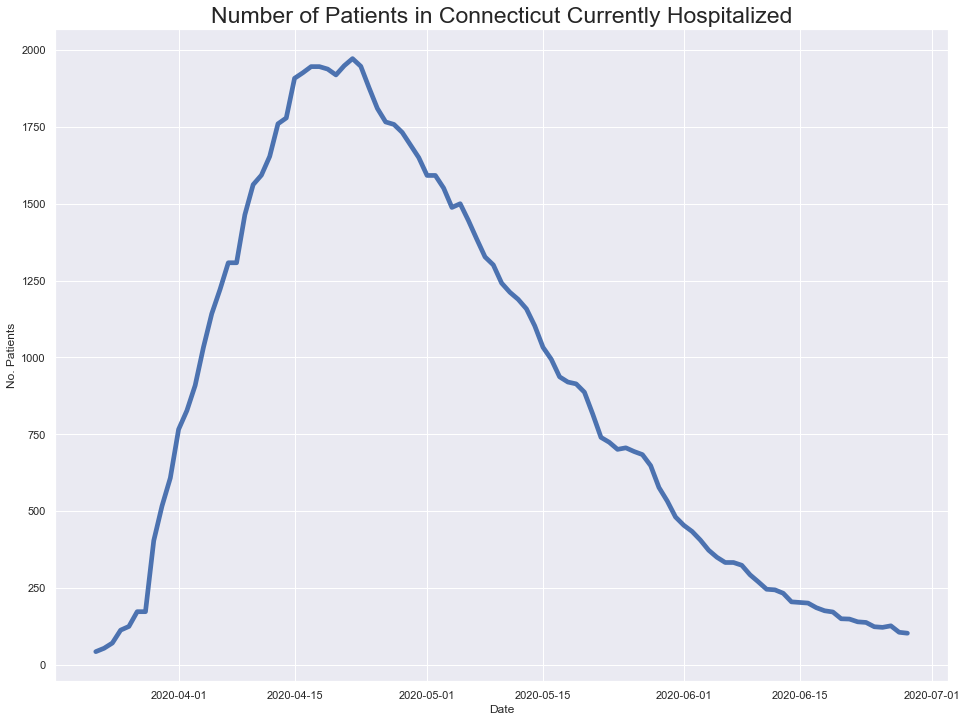

In [81]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(conn.date, conn.hospitalizedCurrently, linewidth=4.7)
plt.title('Number of Patients in Connecticut Currently Hospitalized', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, 'No. Killed')

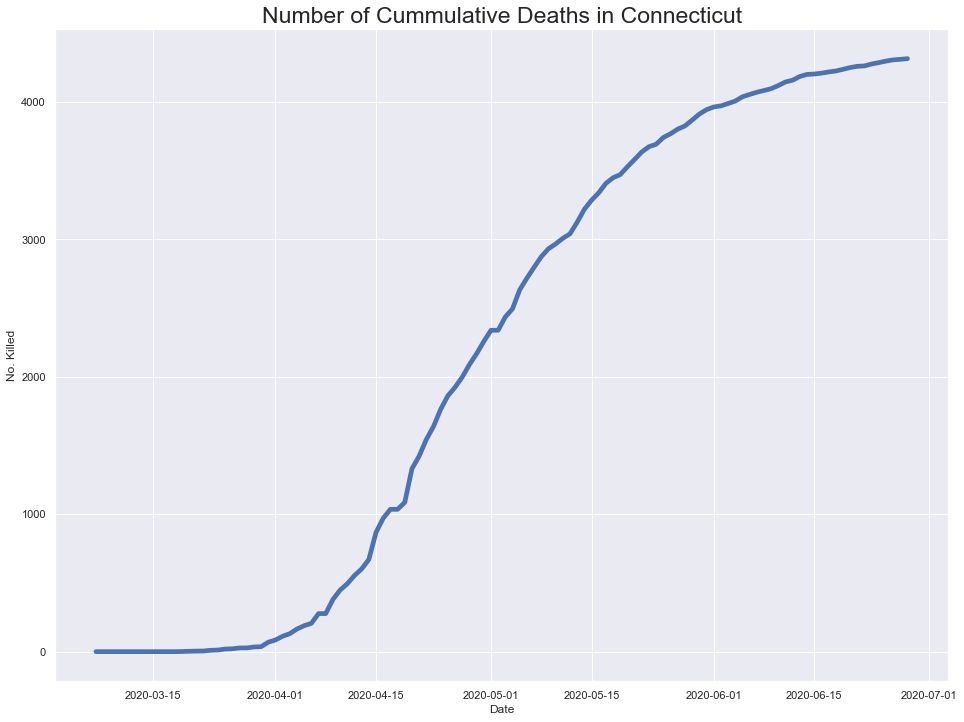

In [82]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(conn.date, conn.death, linewidth=4.7)
plt.title('Number of Cummulative Deaths in Connecticut', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Killed')

Text(0, 0.5, 'No. Killed')

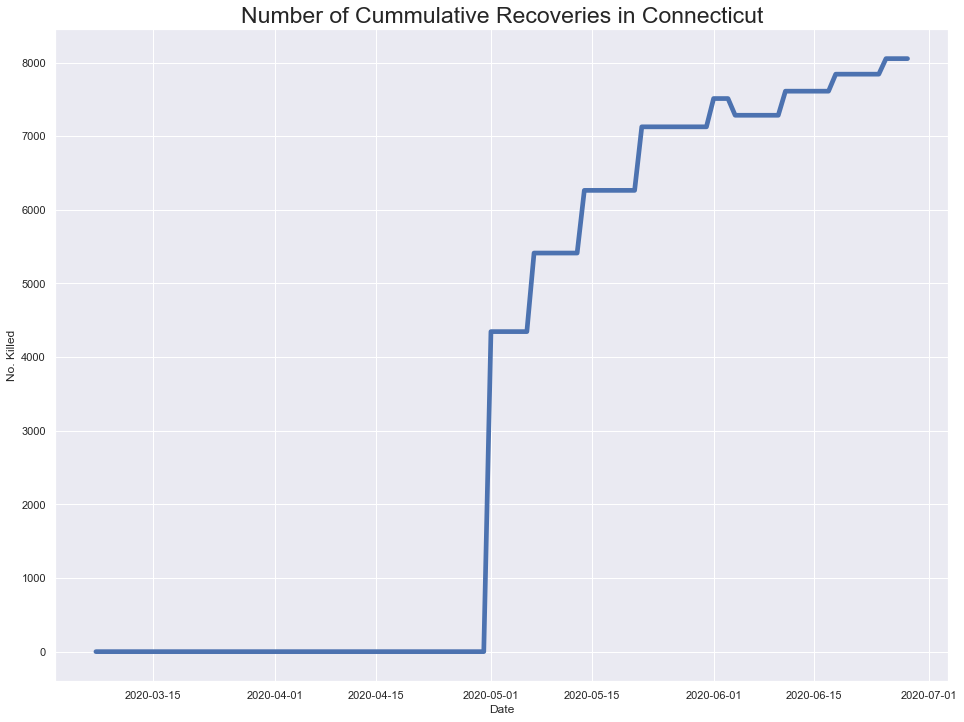

In [83]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(conn.date, conn.recovered, linewidth=4.7)
plt.title('Number of Cummulative Recoveries in Connecticut', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Killed')

In [84]:
#hide_input
# Checking which cols have NaN values
conn[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death', 'hospitalized']]
conn.head()

# Omit the NaN cols
conn = conn[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death']]

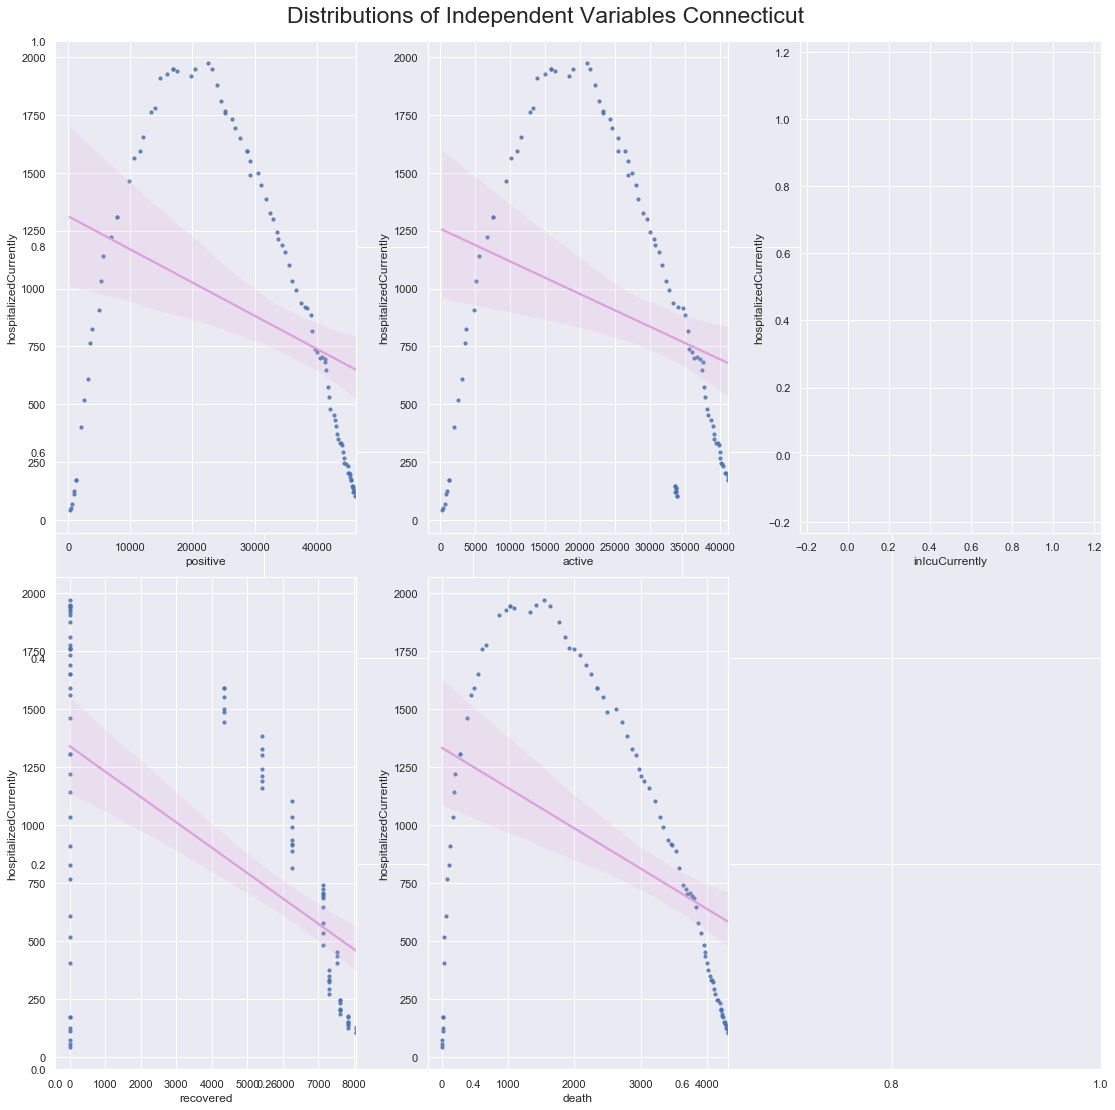

In [85]:
#hide_input
# Scatter plots CT
# Split dependent var from independent variables
target_ct = conn.hospitalizedCurrently
indep_var_ct = conn.drop(columns=['hospitalizedCurrently'])

fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(indep_var_al.columns):
    ax=fig.add_subplot(2, 3, i+1) 
    sns.regplot(x=indep_var_ct[col], y=target_ct, data=indep_var_ct, label=col, scatter_kws={'s':10}, line_kws={"color": "plum"})
    plt.suptitle('Distributions of Independent Variables Connecticut', fontsize=23)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

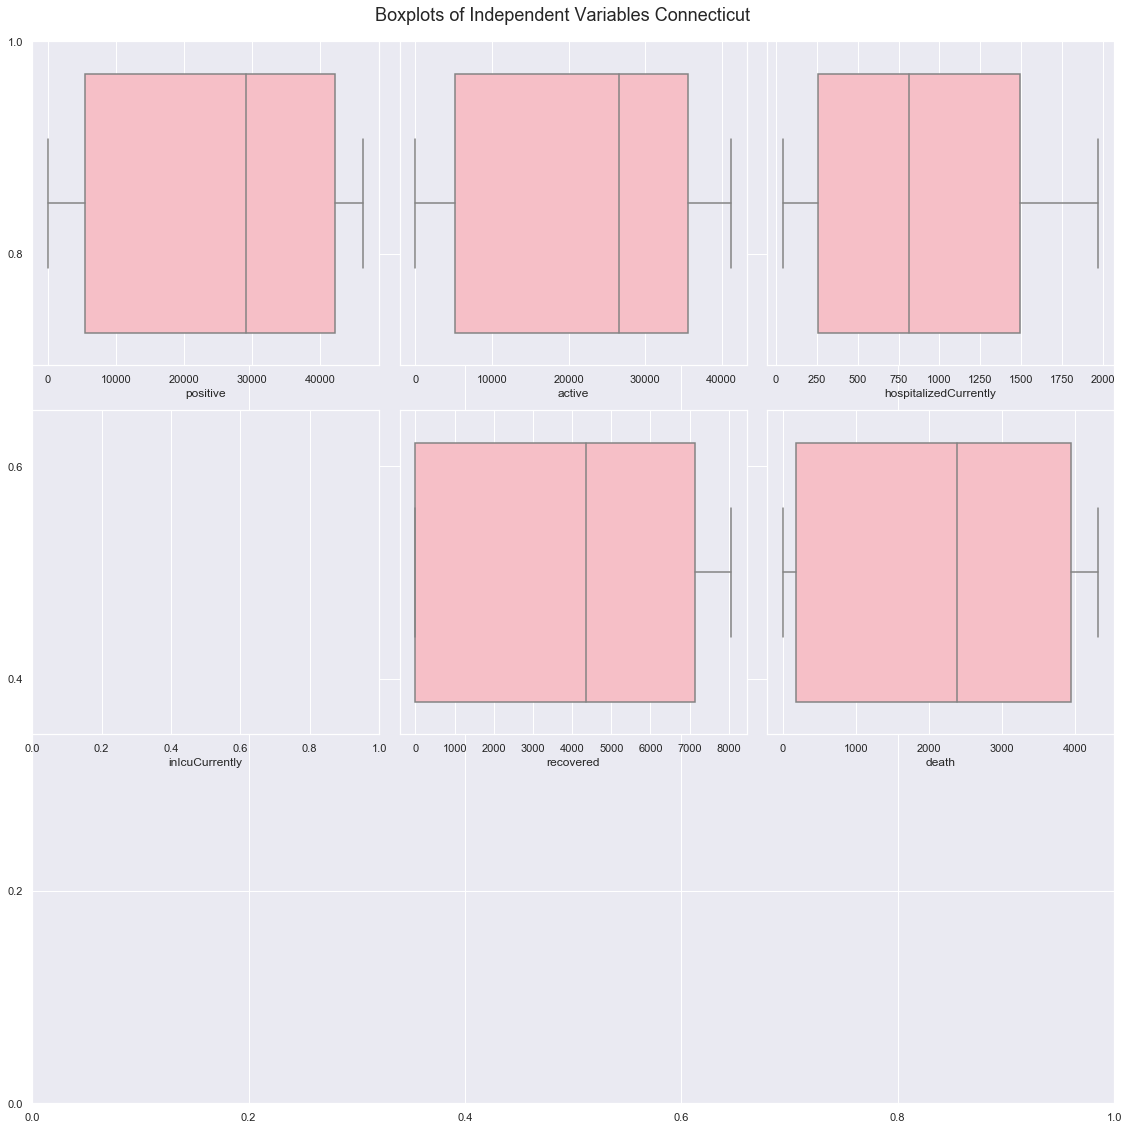

In [86]:
#hide_input
# Boxplot of CT
fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(bama.columns):
    ax=fig.add_subplot(3, 3, i+1) 
    sns.boxplot(x=conn[col], data=conn, color='lightpink', showfliers=True)
    plt.suptitle('Boxplots of Independent Variables Connecticut', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

In [87]:
#hide_input
###endconnecticut

### Delaware:

In [88]:
#hide_input
delaware = covid_df.loc[(covid_df['abbrev'] == 'DE') & (covid_df['state']== 'Delaware')] 


Text(0, 0.5, 'No. Patients')

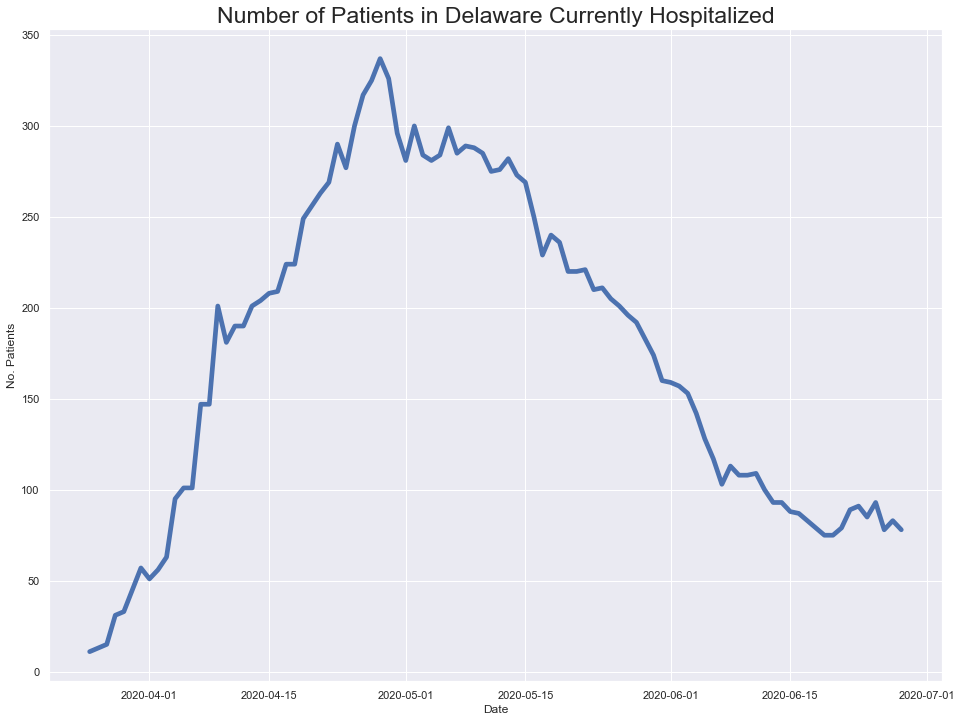

In [89]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(delaware.date, delaware.hospitalizedCurrently, linewidth=4.7)
plt.title('Number of Patients in Delaware Currently Hospitalized', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, 'No. Killed')

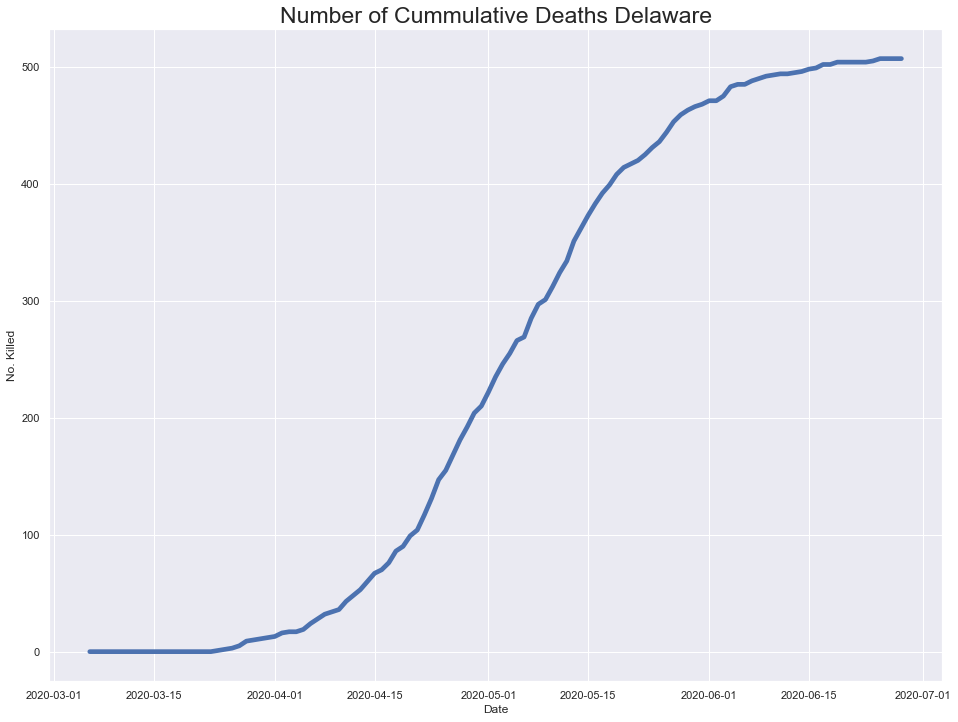

In [90]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(delaware.date, delaware.death, linewidth=4.7)
plt.title('Number of Cummulative Deaths Delaware', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Killed')

In [91]:
#hide_input
# Checking which cols have NaN values
delaware[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death', 'hospitalized']]
delaware.head()

# Omit the NaN cols
delaware = delaware[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death']]

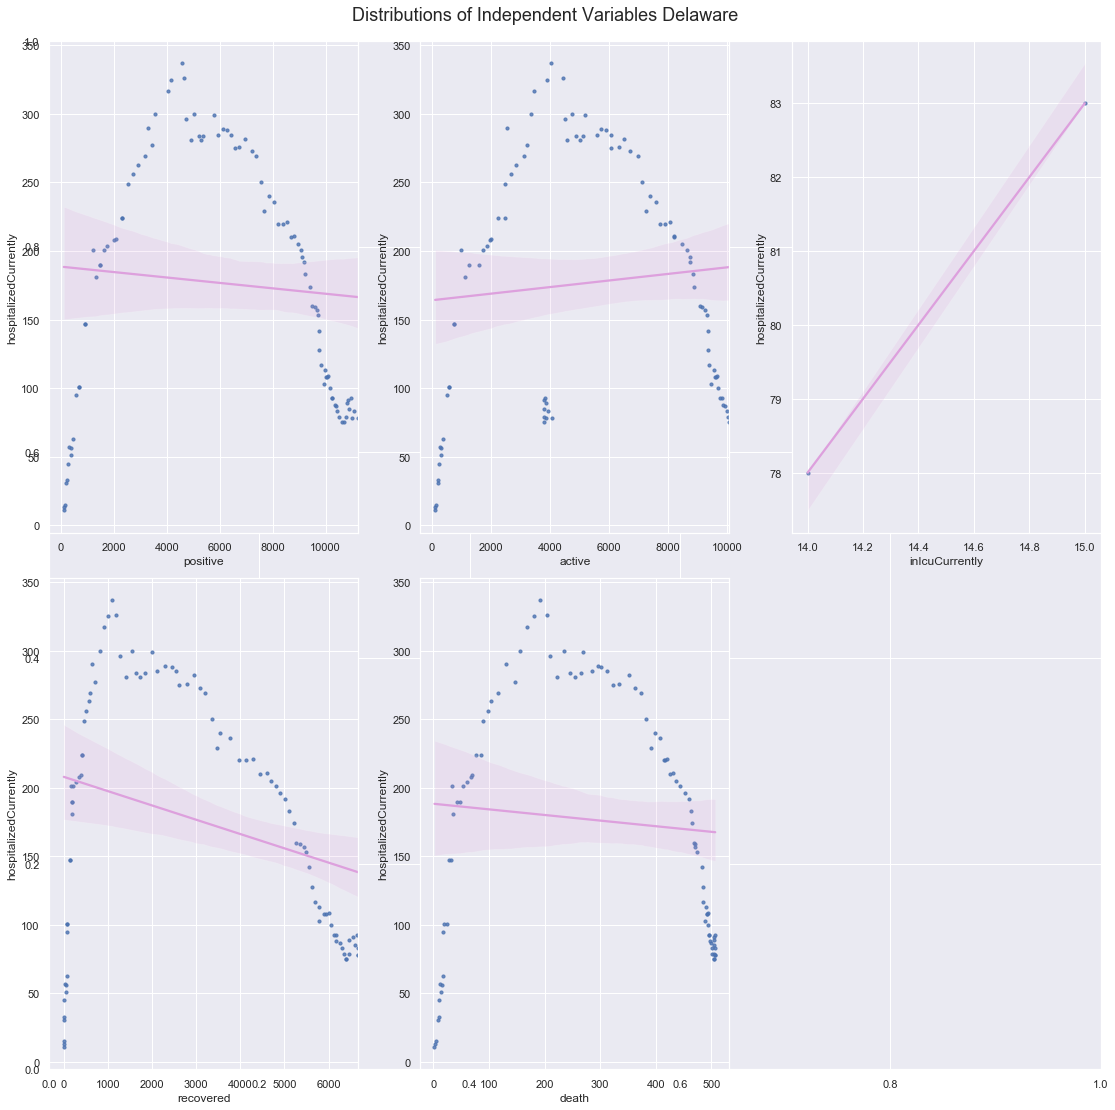

In [92]:
#hide_input
# Scatter plots DE
# Split dependent var from independent variables
target_de = delaware.hospitalizedCurrently
indep_var_de = delaware.drop(columns=['hospitalizedCurrently'])

fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(indep_var_al.columns):
    ax=fig.add_subplot(2, 3, i+1) 
    sns.regplot(x=indep_var_de[col], y=target_de, data=indep_var_de, label=col, scatter_kws={'s':10}, line_kws={"color": "plum"})
    plt.suptitle('Distributions of Independent Variables Delaware', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

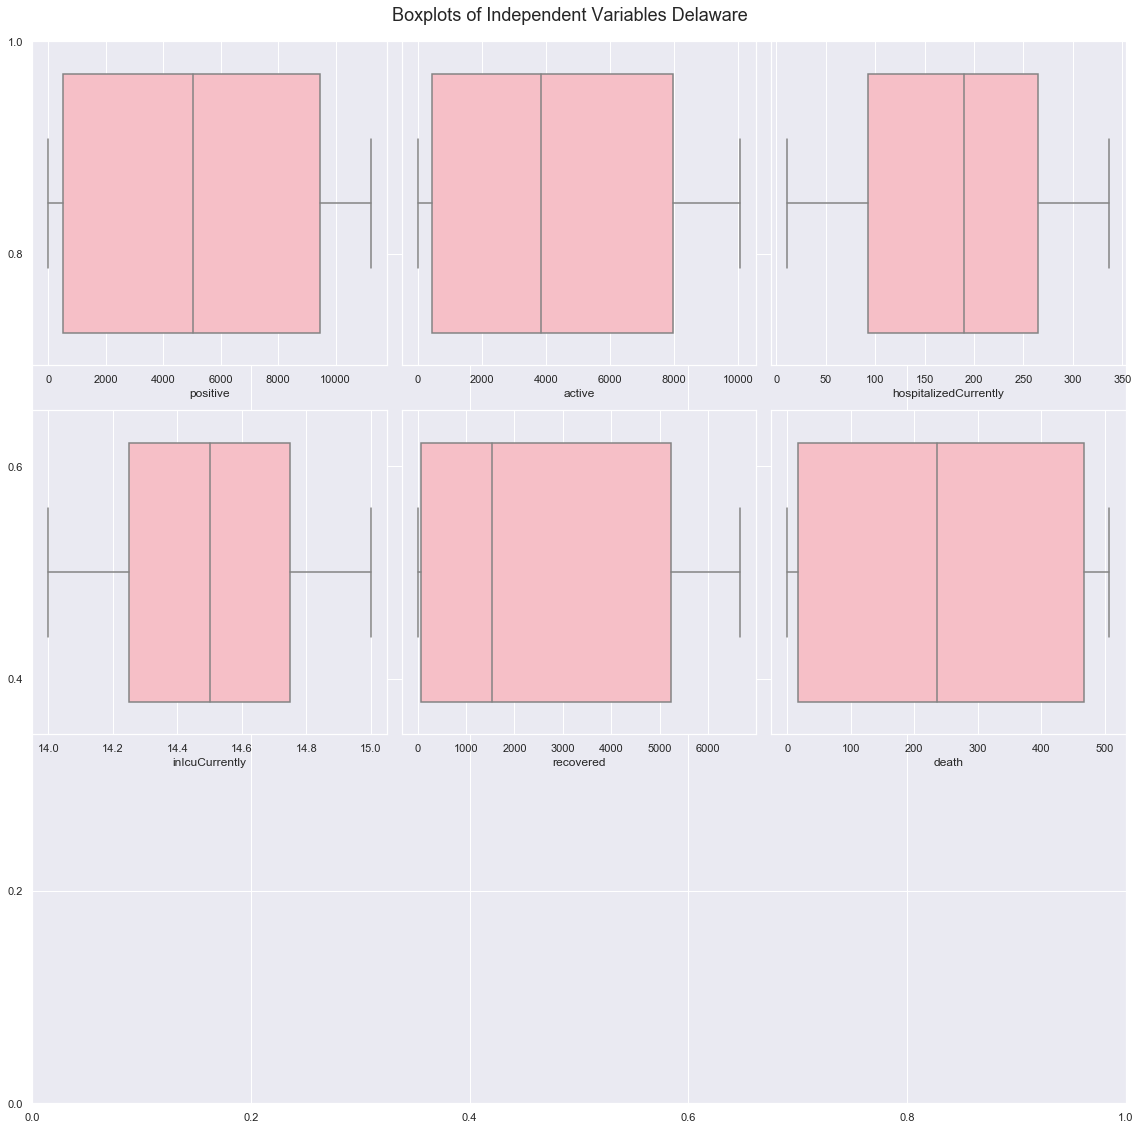

In [93]:
#hide_input
# Boxplot of DE
fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(delaware.columns):
    ax=fig.add_subplot(3, 3, i+1) 
    sns.boxplot(x=delaware[col], data=delaware, color='lightpink', showfliers=True)
    plt.suptitle('Boxplots of Independent Variables Delaware', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

In [94]:
#hide_input
###enddelaware

### Florida:

In [95]:
#hide_input
#hide_input
fl = covid_df.loc[(covid_df['abbrev'] == 'FL') & (covid_df['state']== 'Florida')] 


Text(0, 0.5, 'No. Patients')

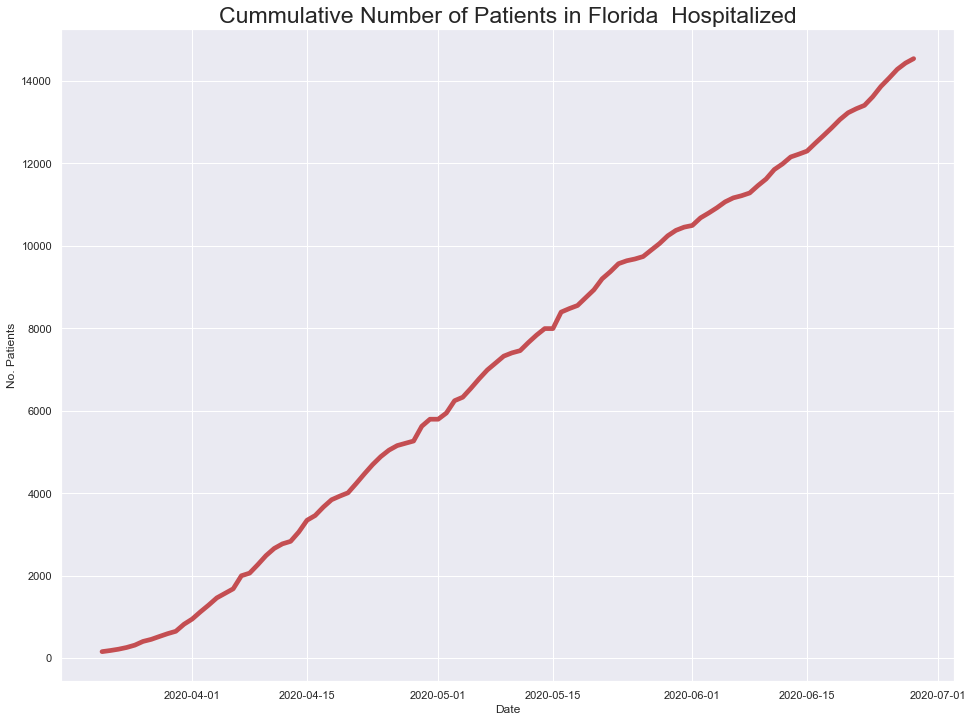

In [96]:
#hide_input
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(fl.date, fl.hospitalizedCumulative, linewidth=4.7, color='r')
plt.title('Cummulative Number of Patients in Florida  Hospitalized', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, 'No. Patients')

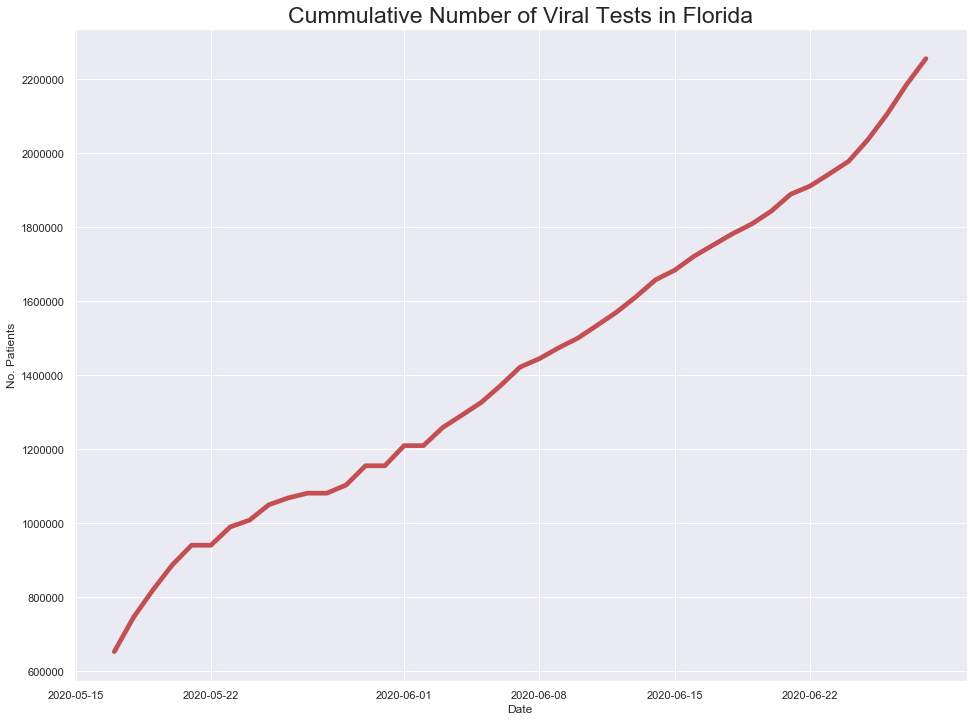

In [97]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(fl.date, fl.totalTestsViral, linewidth=4.7, color='r')
plt.title('Cummulative Number of Viral Tests in Florida', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, 'No. Patients')

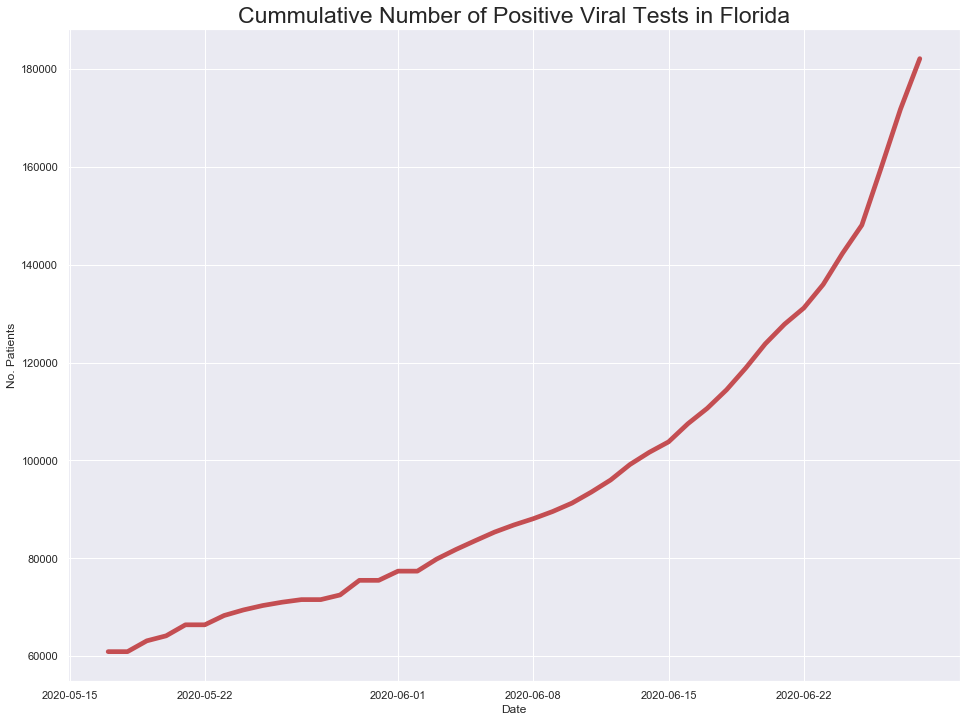

In [98]:
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(fl.date, fl.positiveTestsViral, linewidth=4.7, color='r')
plt.title('Cummulative Number of Positive Viral Tests in Florida', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, '% Infected')

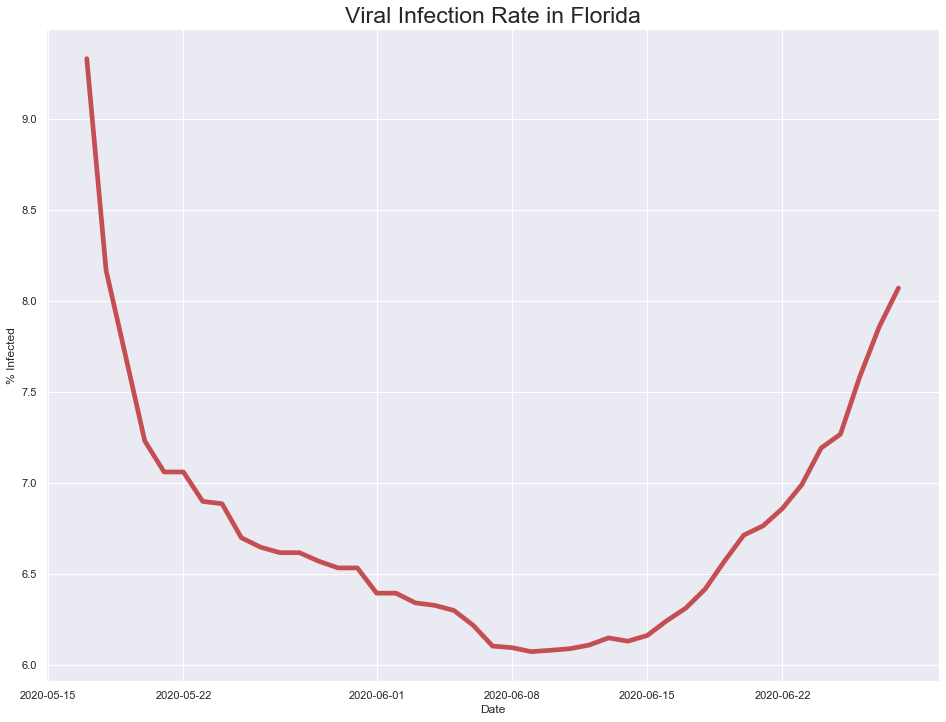

In [99]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(fl.date, fl.positiveTestsViral/fl.totalTestsViral*100, linewidth=4.7, color='r')
plt.title('Viral Infection Rate in Florida', fontsize=23)
plt.xlabel('Date')
plt.ylabel('% Infected')

In [100]:
#hide_input
###endflorida

### Georgia:

In [101]:
#hide_input
georgia = covid_df.loc[(covid_df['abbrev'] == 'GA') & (covid_df['state']== 'Georgia')] 


Text(0, 0.5, 'No. Patients')

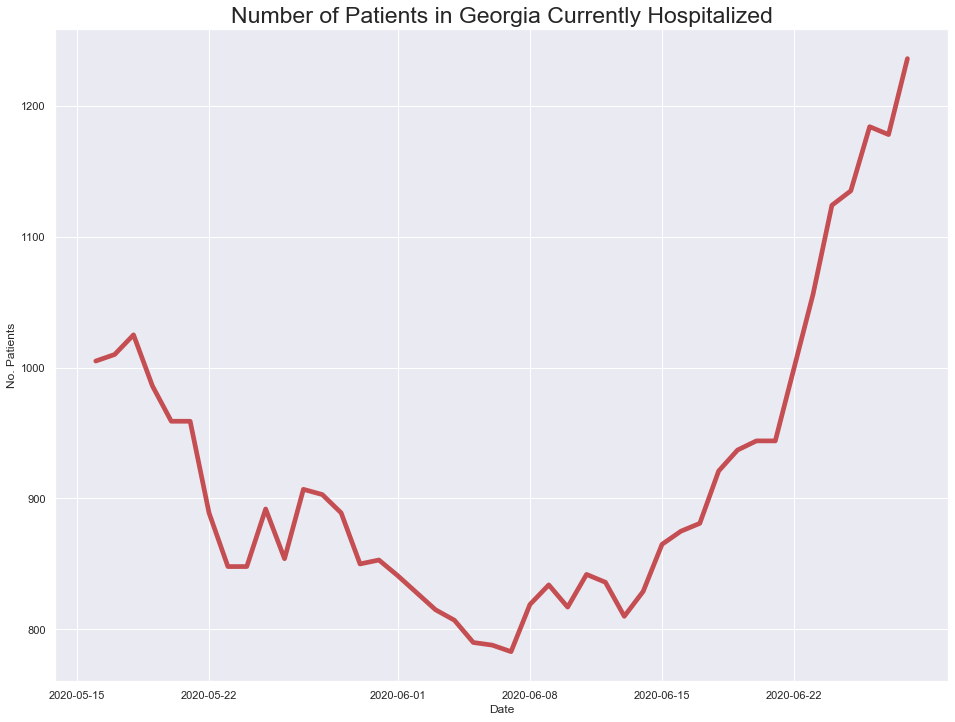

In [102]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(georgia.date, georgia.hospitalizedCurrently, linewidth=4.7, color='r')
plt.title('Number of Patients in Georgia Currently Hospitalized', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, 'No. Patients')

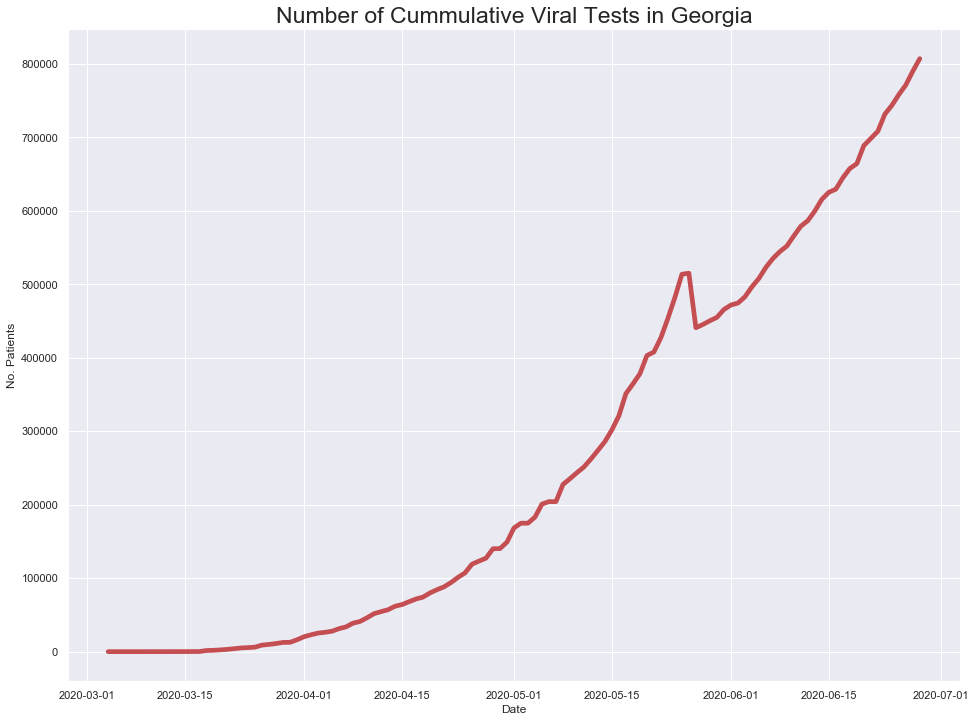

In [103]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(georgia.date, georgia.totalTestsViral, linewidth=4.7, color='r')
plt.title('Number of Cummulative Viral Tests in Georgia', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, 'No. Patients')

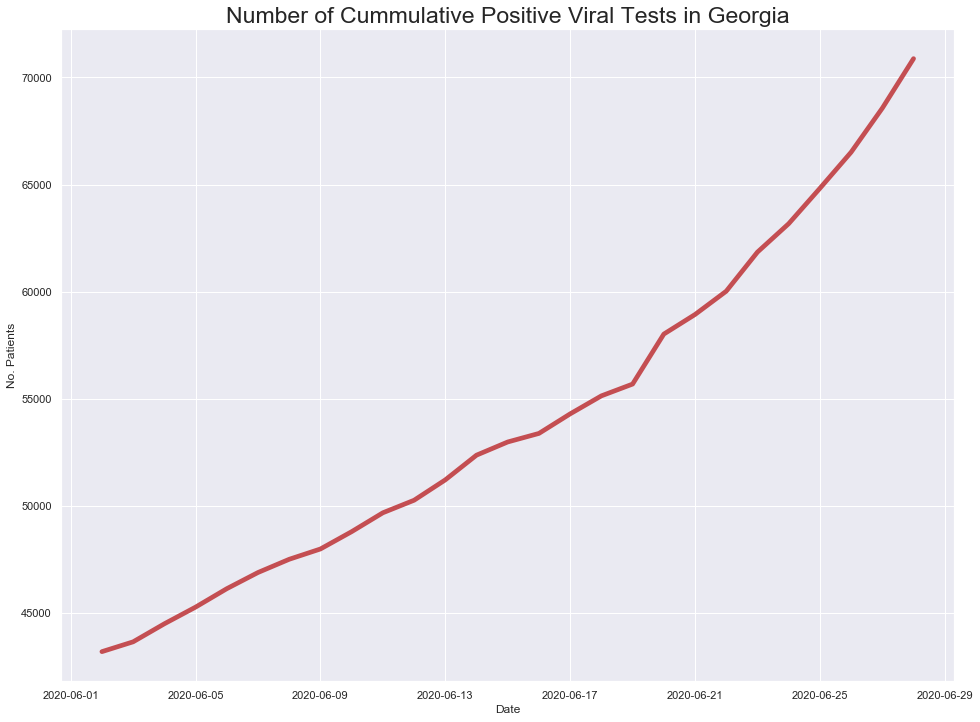

In [104]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(georgia.date, georgia.positiveTestsViral, linewidth=4.7, color='r')
plt.title('Number of Cummulative Positive Viral Tests in Georgia', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, '% Infection Rate')

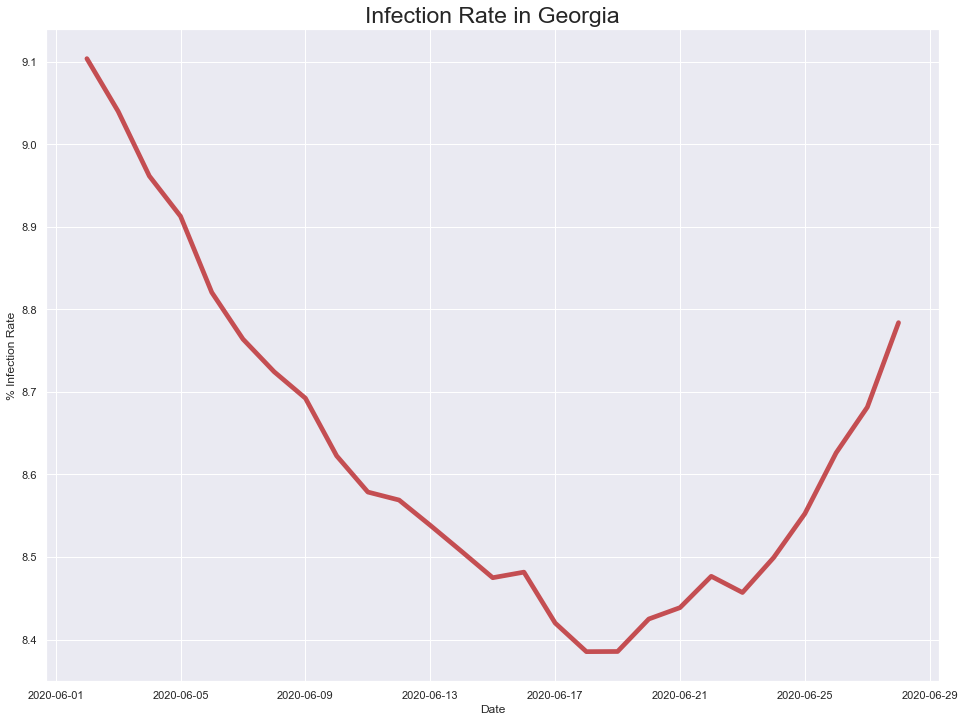

In [105]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(georgia.date, georgia.positiveTestsViral/georgia.totalTestsViral*100, linewidth=4.7, color='r')
plt.title('Infection Rate in Georgia', fontsize=23)
plt.xlabel('Date')
plt.ylabel('% Infection Rate')

In [106]:
#hide_input
# Checking which cols have NaN values
georgia[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death', 'hospitalized']]
georgia.head()

# Omit the NaN cols
georgia = georgia[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death']]

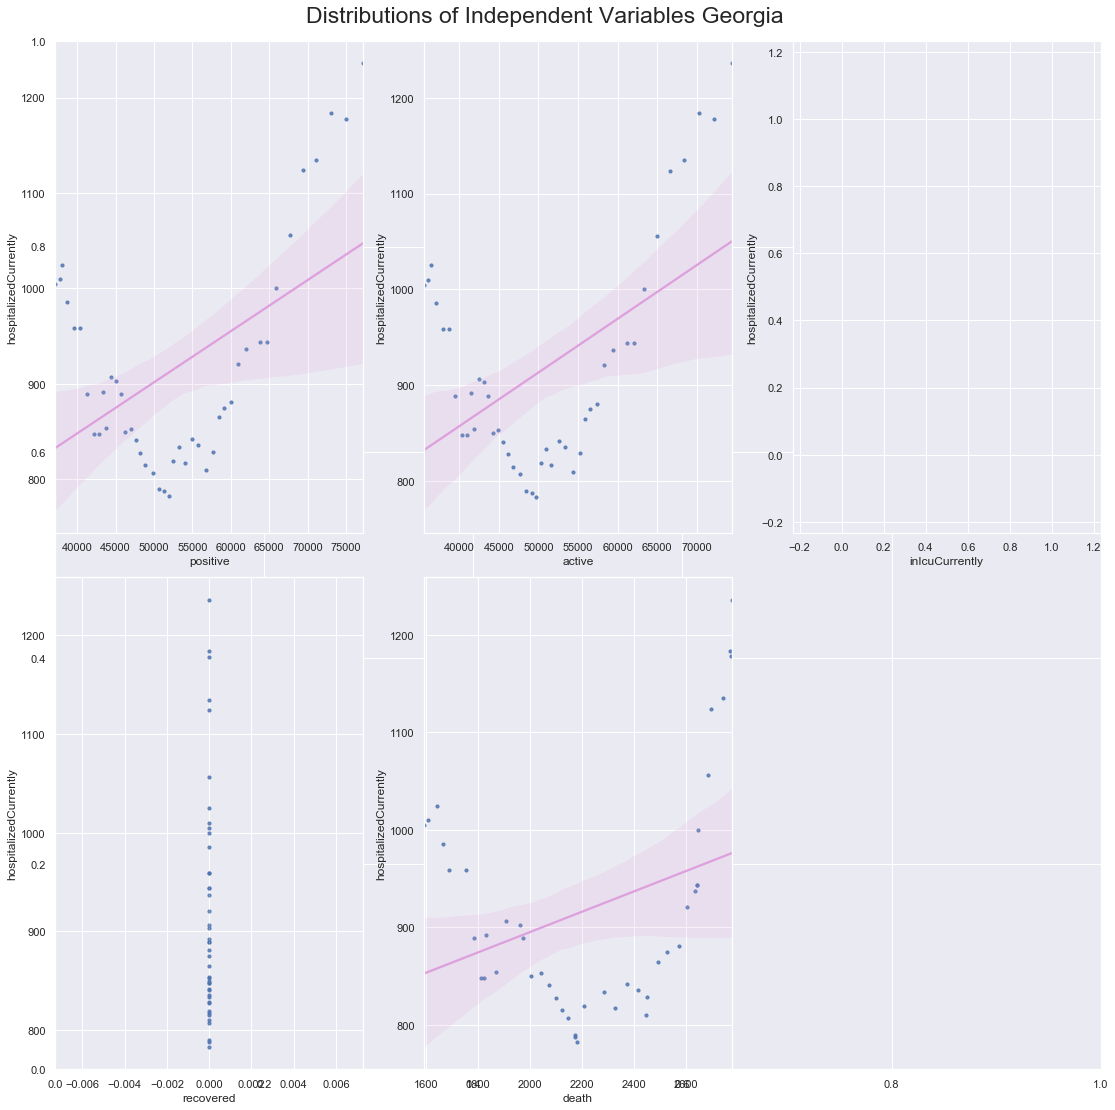

In [107]:
#hide_input
# Scatter plots GA
# Split dependent var from independent variables
target_ga = georgia.hospitalizedCurrently
indep_var_ga = georgia.drop(columns=['hospitalizedCurrently'])

fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(indep_var_ga.columns):
    ax=fig.add_subplot(2, 3, i+1) 
    sns.regplot(x=indep_var_ga[col], y=target_ga, data=indep_var_ga, label=col, scatter_kws={'s':10}, line_kws={"color": "plum"})
    plt.suptitle('Distributions of Independent Variables Georgia', fontsize=23)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

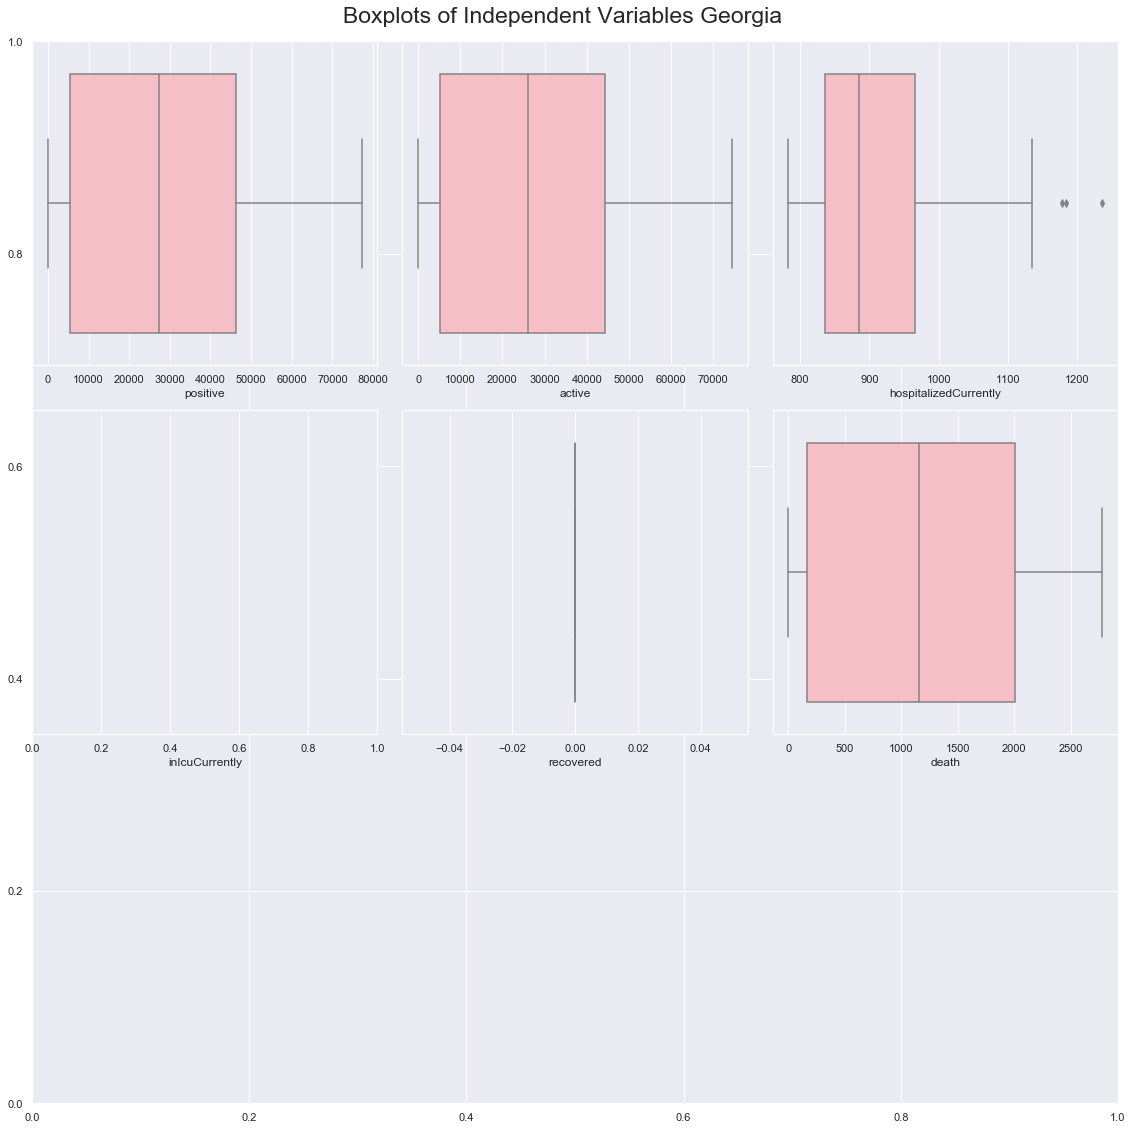

In [108]:
#hide_input
# Boxplot of GA
fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(georgia.columns):
    ax=fig.add_subplot(3, 3, i+1) 
    sns.boxplot(x=georgia[col], data=georgia, color='lightpink', showfliers=True)
    plt.suptitle('Boxplots of Independent Variables Georgia', fontsize=23)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

In [109]:
#hide_input
###endgeorgia

### South Carolina:

In [110]:
#hide_input
sc = covid_df.loc[(covid_df['abbrev'] == 'SC') & (covid_df['state']== 'South Carolina')] 


Text(0, 0.5, 'No. Patients')

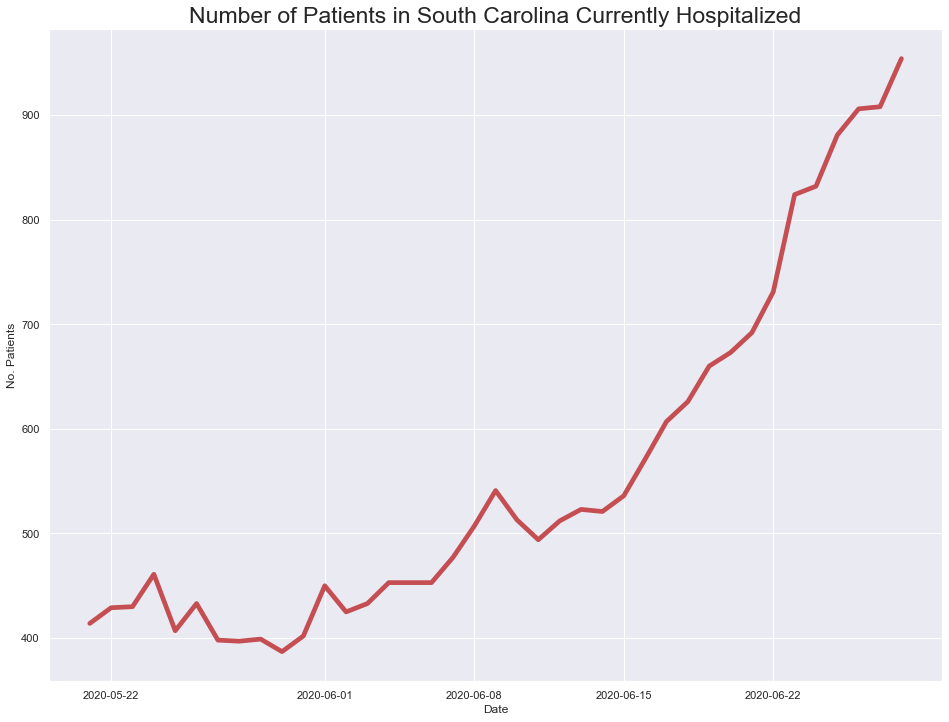

In [111]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(sc.date, sc.hospitalizedCurrently, linewidth=4.7, color='r')
plt.title('Number of Patients in South Carolina Currently Hospitalized', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, 'No. Patients')

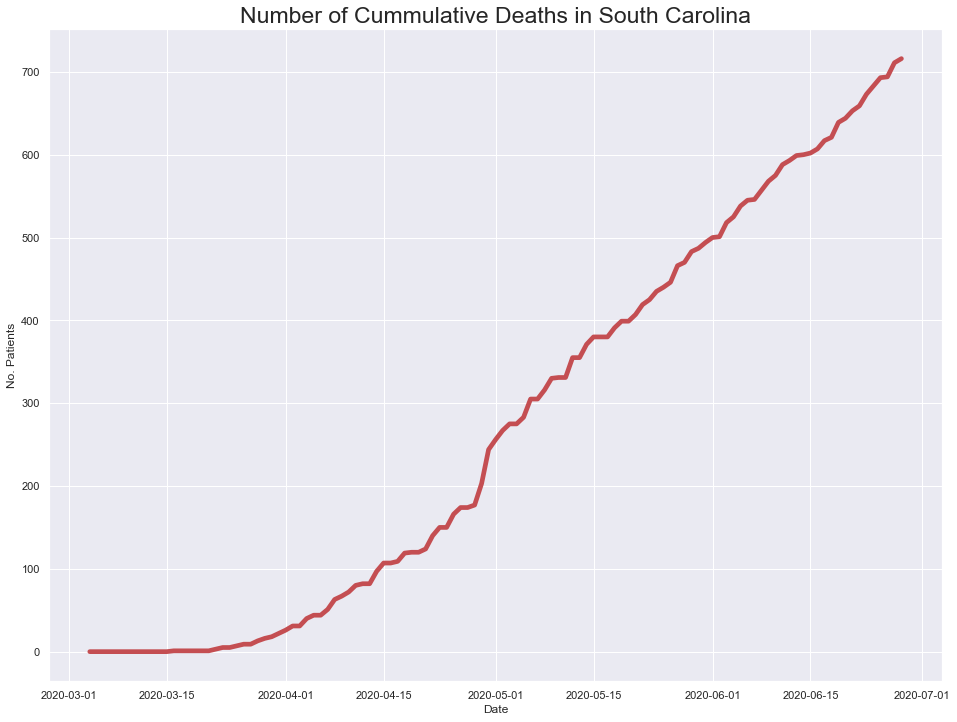

In [112]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(sc.date, sc.death, linewidth=4.7, color='r')
plt.title('Number of Cummulative Deaths in South Carolina', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, 'No. Patients')

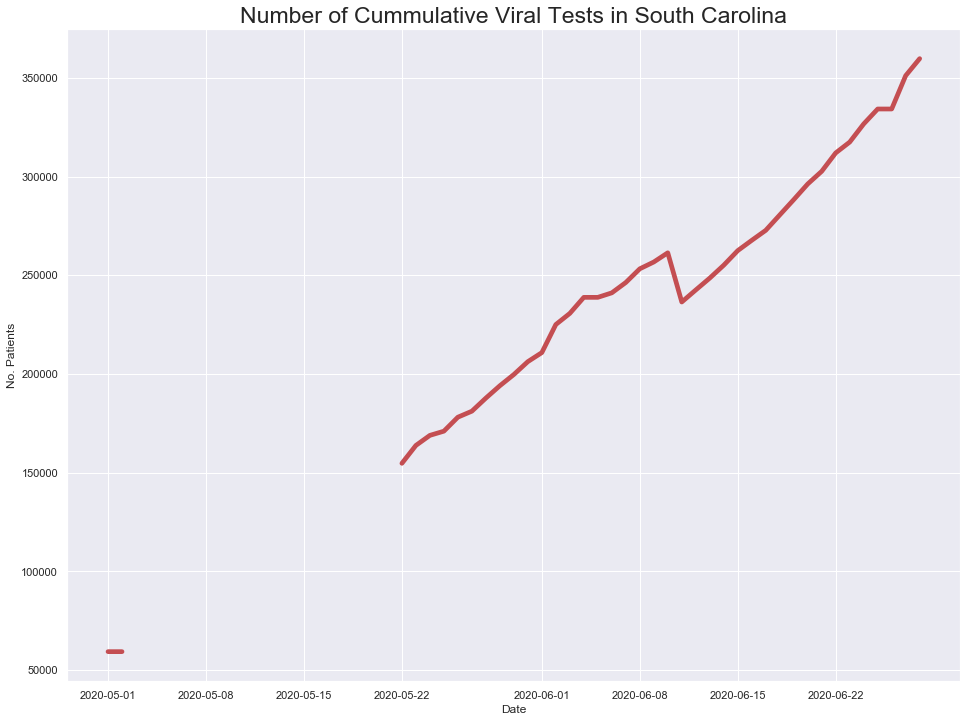

In [113]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(sc.date, sc.totalTestsViral, linewidth=4.7, color='r')
plt.title('Number of Cummulative Viral Tests in South Carolina', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, 'No. Patients')

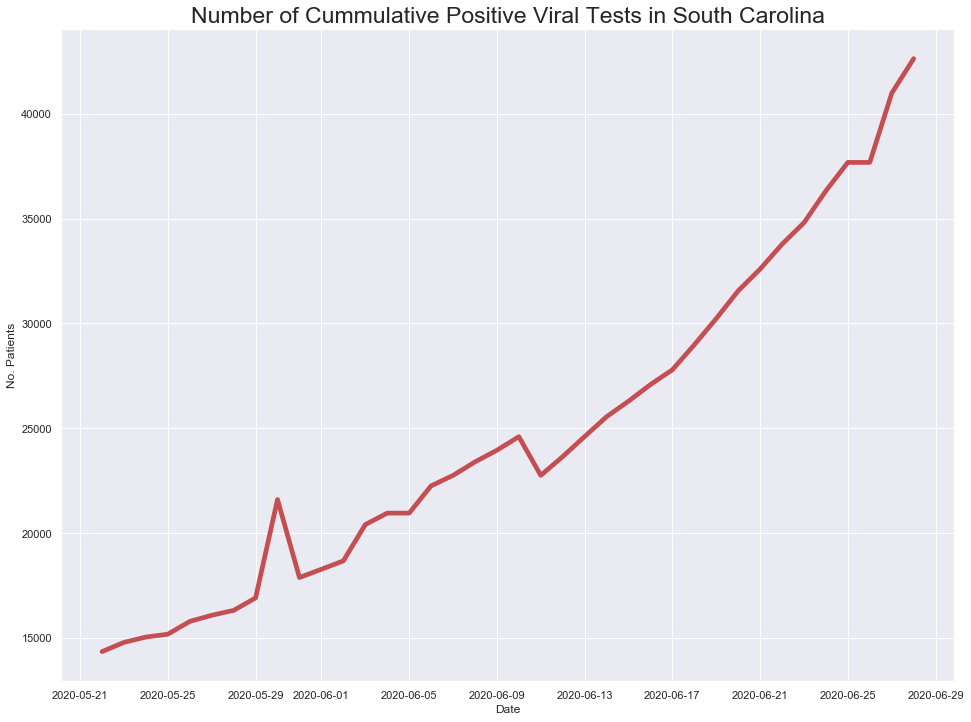

In [114]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(sc.date, sc.positiveTestsViral, linewidth=4.7, color='r')
plt.title('Number of Cummulative Positive Viral Tests in South Carolina', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, '% Infection Rate')

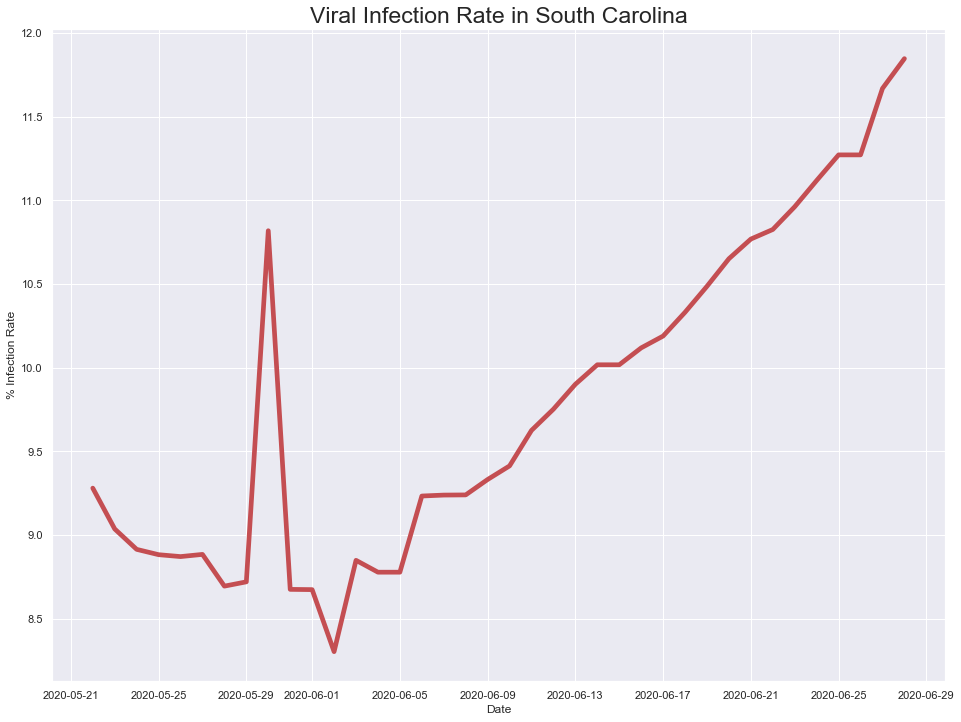

In [115]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(sc.date, sc.positiveTestsViral/sc.totalTestsViral*100, linewidth=4.7, color='r')
plt.title('Viral Infection Rate in South Carolina', fontsize=23)
plt.xlabel('Date')
plt.ylabel('% Infection Rate')

In [116]:
#hide_input
# Checking which cols have NaN values
sc[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death', 'hospitalized']]
sc.head()

# Omit the NaN cols
sc = sc[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death']]

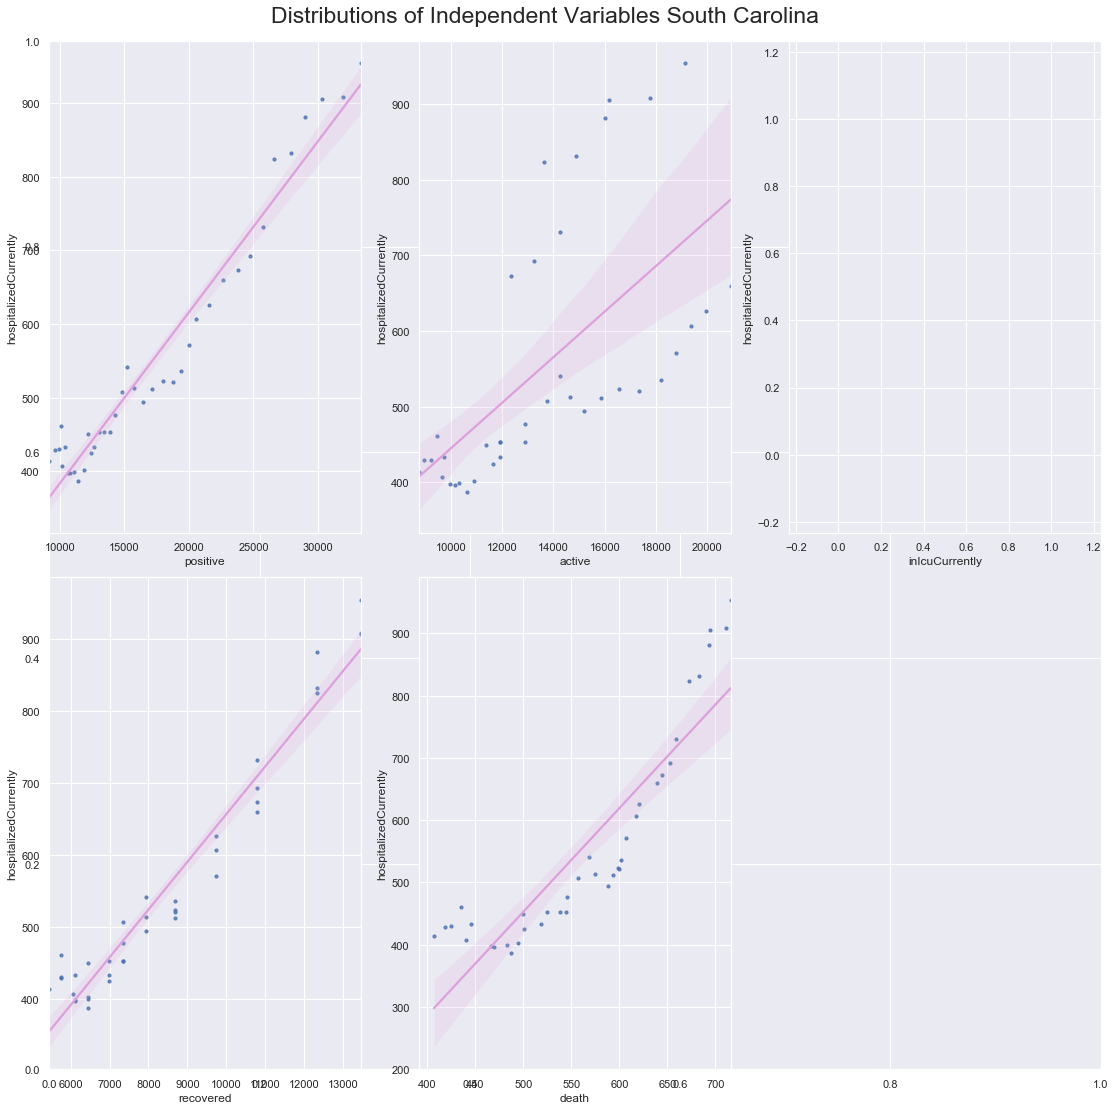

In [117]:
#hide_input
# Scatter plots SC
# Split dependent var from independent variables
target_sc = sc.hospitalizedCurrently
indep_var_sc = sc.drop(columns=['hospitalizedCurrently'])

fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(indep_var_sc.columns):
    ax=fig.add_subplot(2, 3, i+1) 
    sns.regplot(x=indep_var_sc[col], y=target_sc, data=indep_var_sc, label=col, scatter_kws={'s':10}, line_kws={"color": "plum"})
    plt.suptitle('Distributions of Independent Variables South Carolina', fontsize=23)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

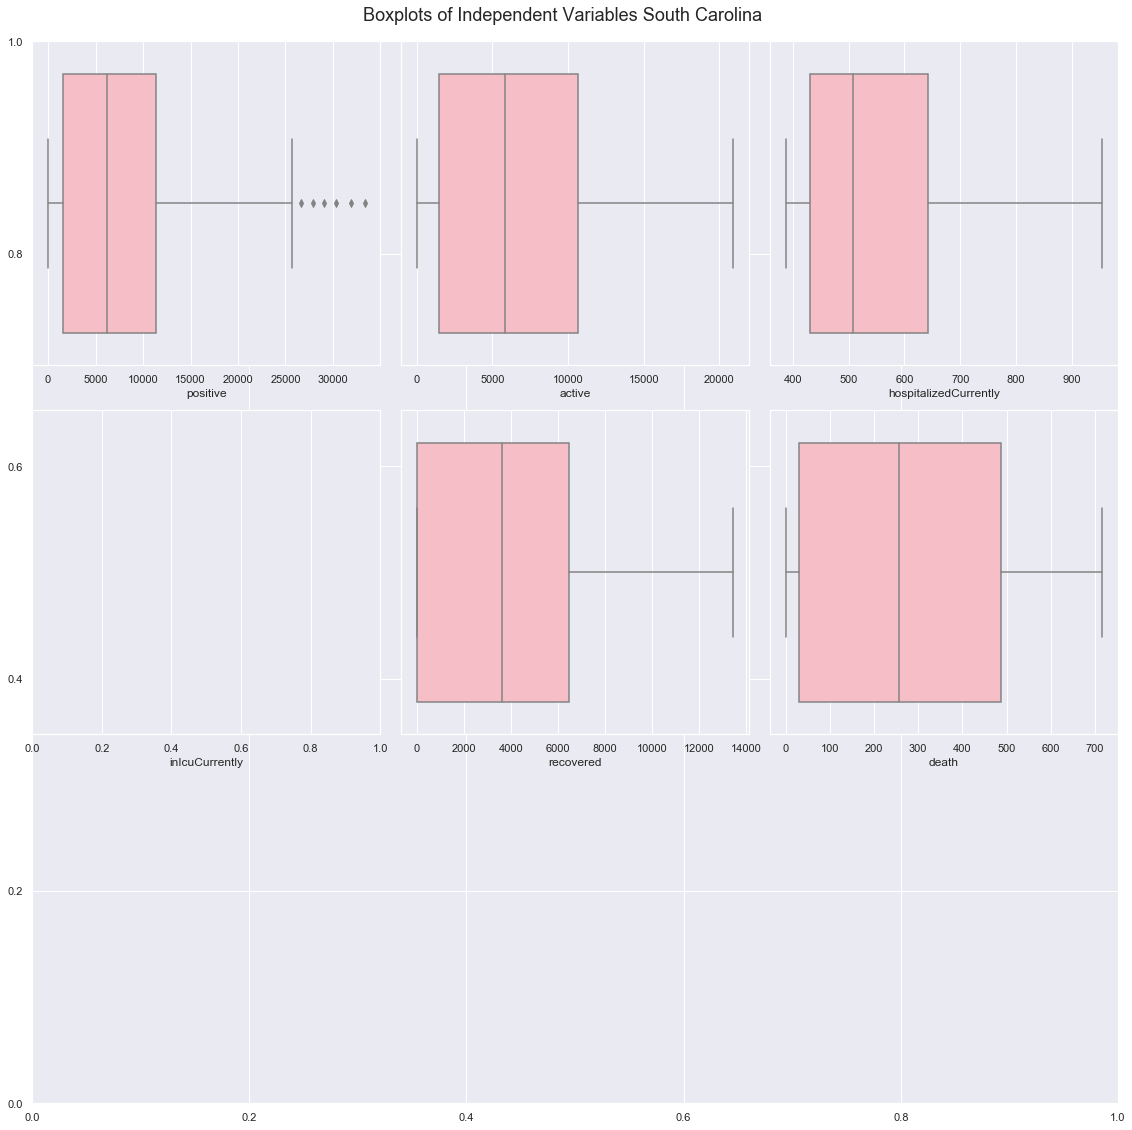

In [118]:
#hide_input
# Boxplot of SC
fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(sc.columns):
    ax=fig.add_subplot(3, 3, i+1) 
    sns.boxplot(x=sc[col], data=sc, color='lightpink', showfliers=True)
    plt.suptitle('Boxplots of Independent Variables South Carolina', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

In [119]:
#hide_input
###endsouthcarolina

### Texas:

In [120]:
#hide_input
texas = covid_df.loc[(covid_df['abbrev'] == 'TX') & (covid_df['state']== 'Texas')] 


Text(0, 0.5, 'No. Patients')

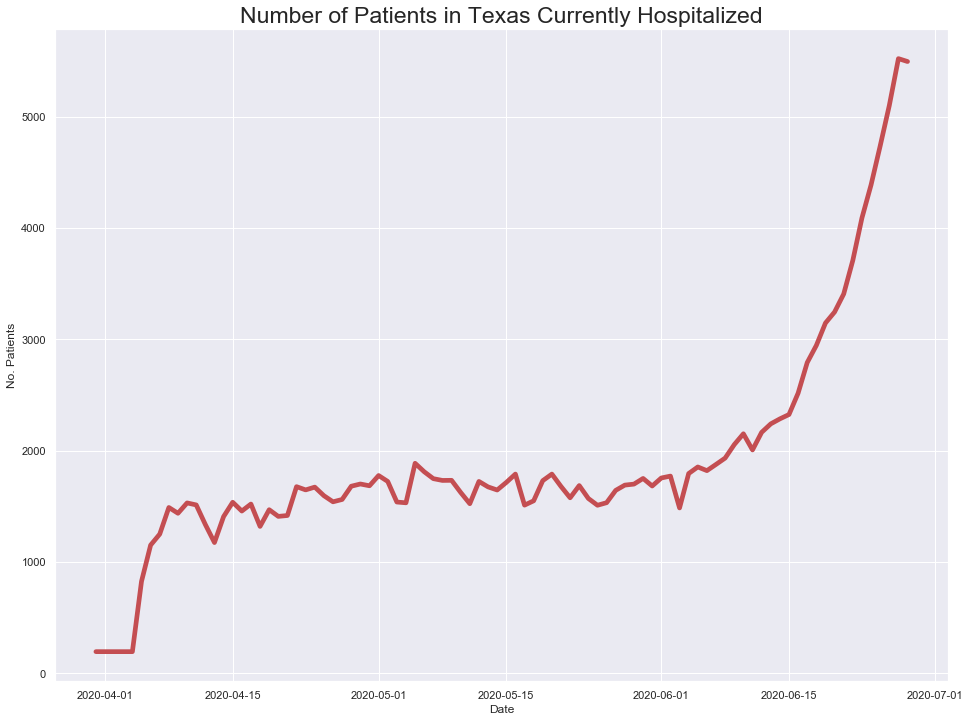

In [121]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(texas.date, texas.hospitalizedCurrently, linewidth=4.7, color='r')
plt.title('Number of Patients in Texas Currently Hospitalized', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, 'No. Patients')

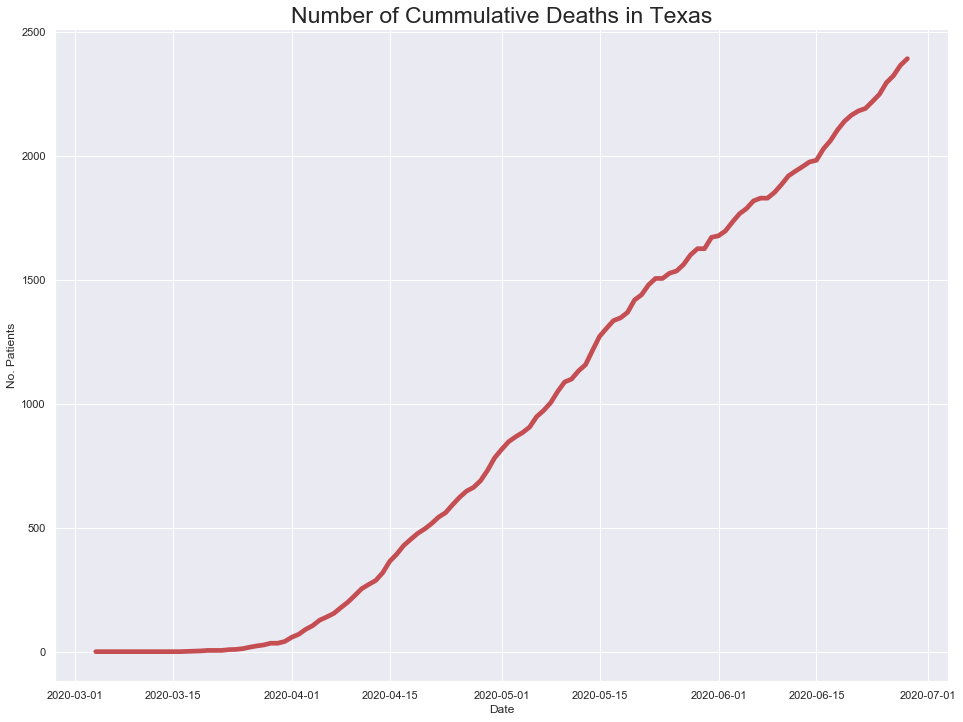

In [122]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(texas.date, texas.death, linewidth=4.7, color='r')
plt.title('Number of Cummulative Deaths in Texas', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, 'No. Patients')

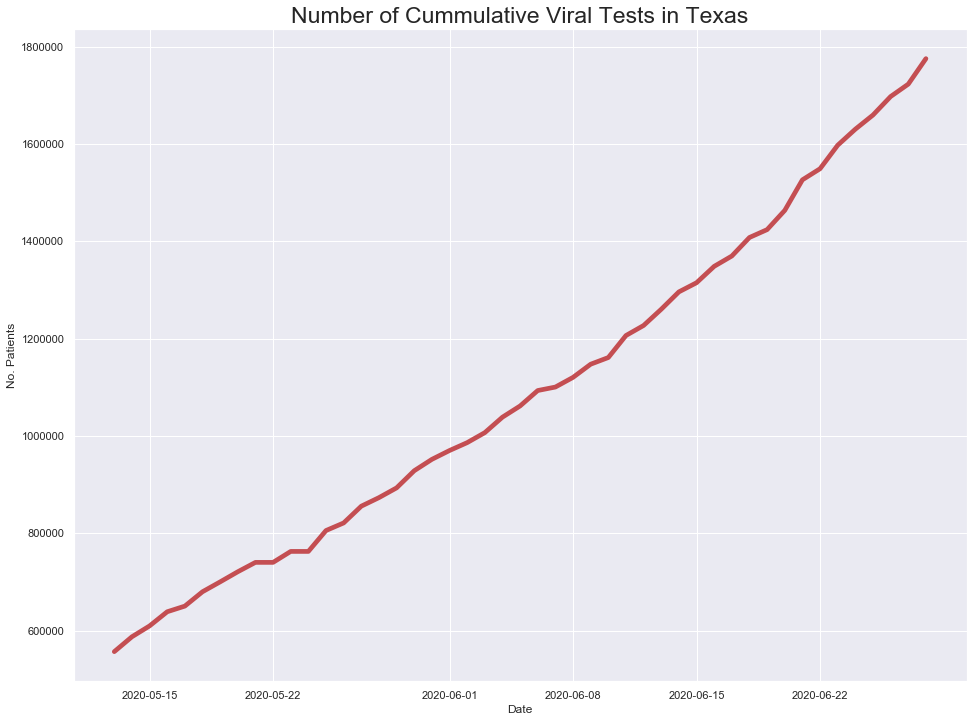

In [123]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(texas.date, texas.totalTestsViral, linewidth=4.7, color='r')
plt.title('Number of Cummulative Viral Tests in Texas', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

In [124]:
#hide_input
# Checking which cols have NaN values
texas[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death', 'hospitalized']]
texas.head()

# Omit the NaN cols
texas = texas[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death']]

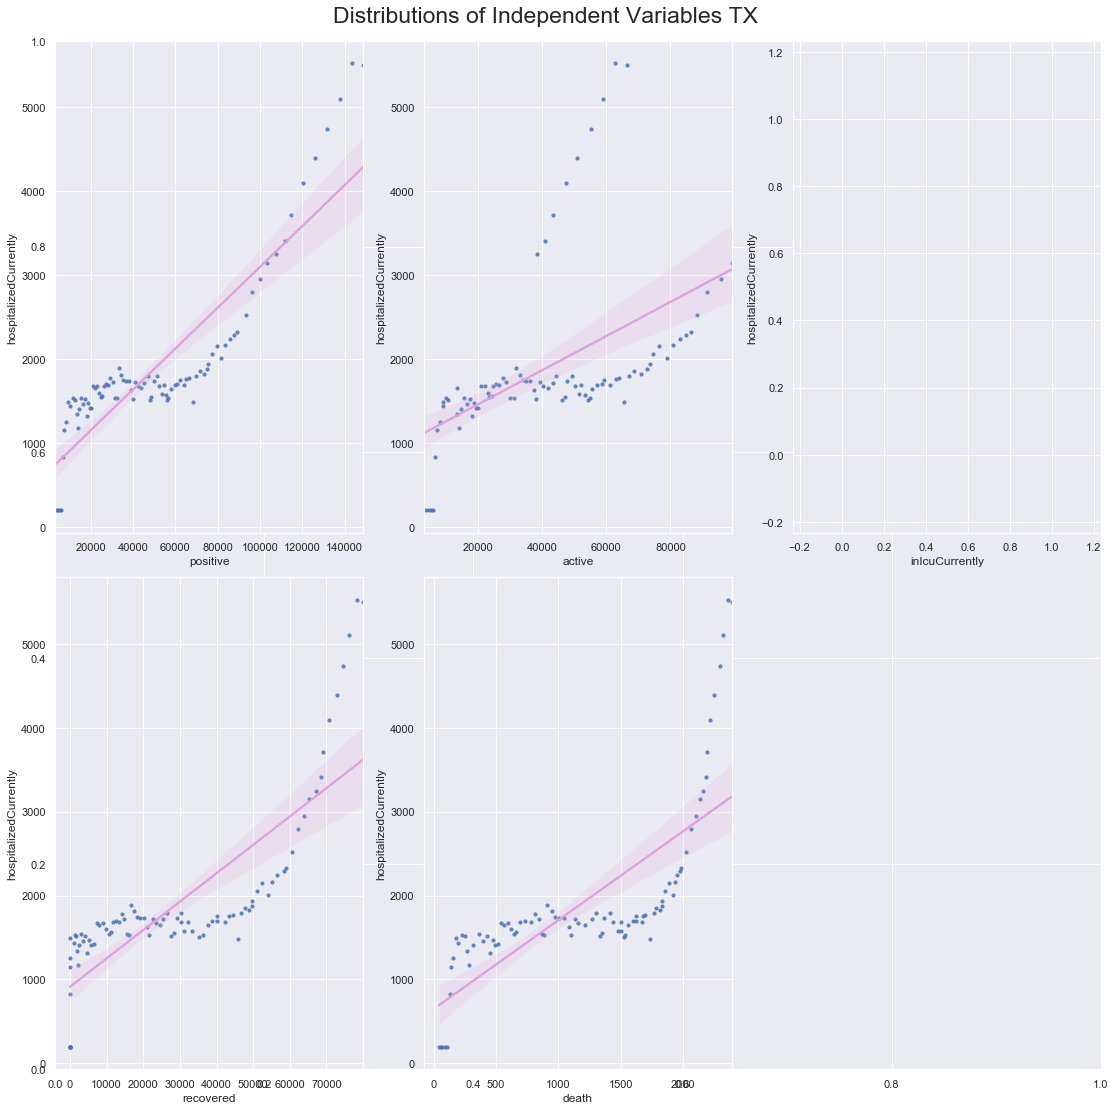

In [125]:
#hide_input
# Scatter plots TX
# Split dependent var from independent variables
target_tx = texas.hospitalizedCurrently
indep_var_tx = texas.drop(columns=['hospitalizedCurrently'])

fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(indep_var_tx.columns):
    ax=fig.add_subplot(2, 3, i+1) 
    sns.regplot(x=indep_var_tx[col], y=target_tx, data=indep_var_tx, label=col, scatter_kws={'s':10}, line_kws={"color": "plum"})
    plt.suptitle('Distributions of Independent Variables TX', fontsize=23)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

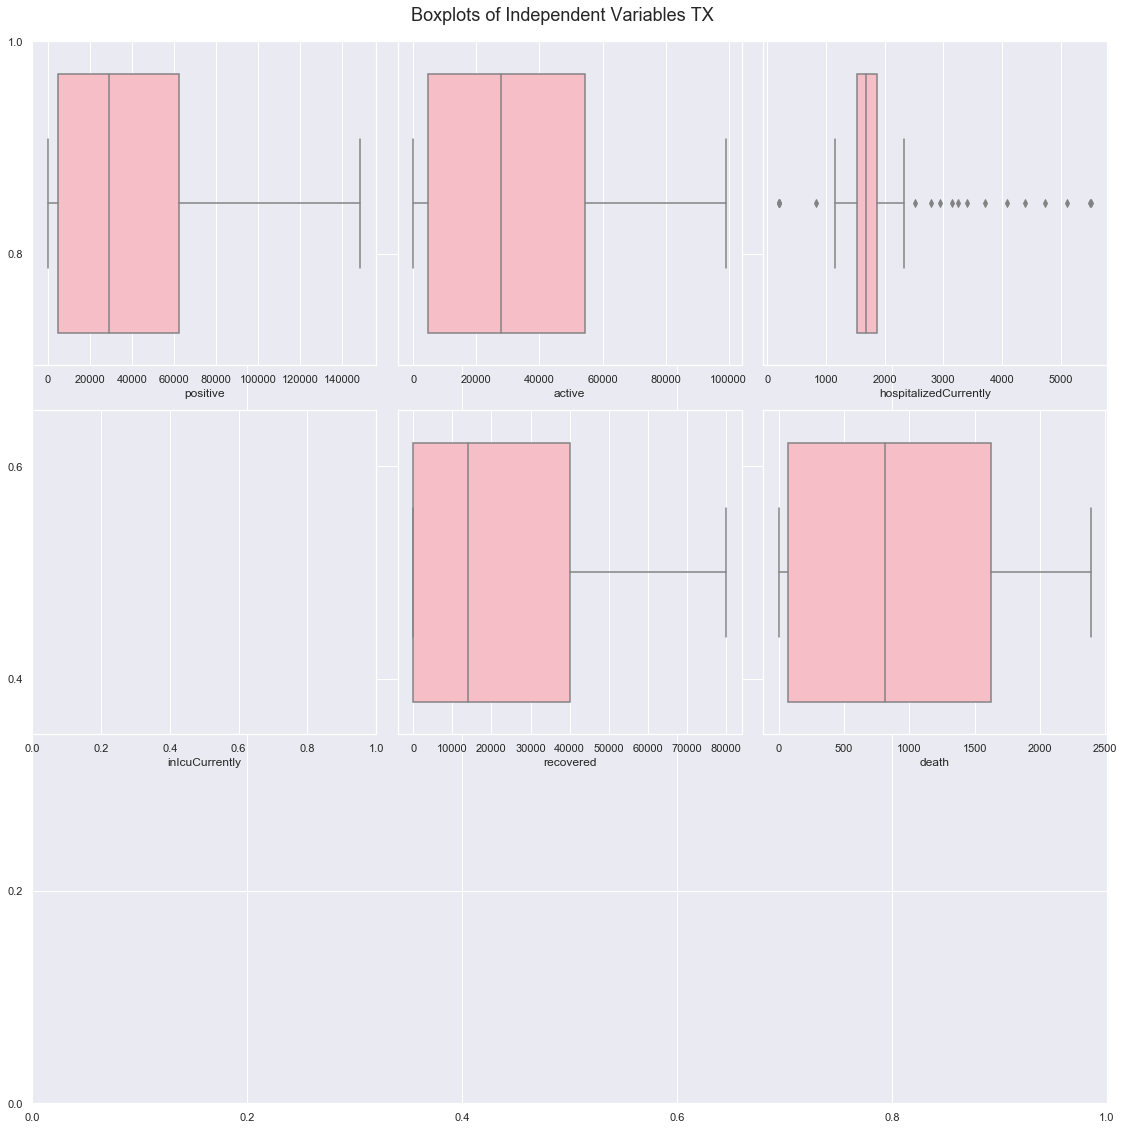

In [126]:
#hide_input
# Boxplot of TX
fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(texas.columns):
    ax=fig.add_subplot(3, 3, i+1) 
    sns.boxplot(x=texas[col], data=texas, color='lightpink', showfliers=True)
    plt.suptitle('Boxplots of Independent Variables TX', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

In [127]:
#hide_input
###endtx

### Nevada:

In [128]:
#hide_input
nevada = covid_df.loc[(covid_df['abbrev'] == 'NV') & (covid_df['state']== 'Nevada')] 


Text(0, 0.5, 'No. Patients')

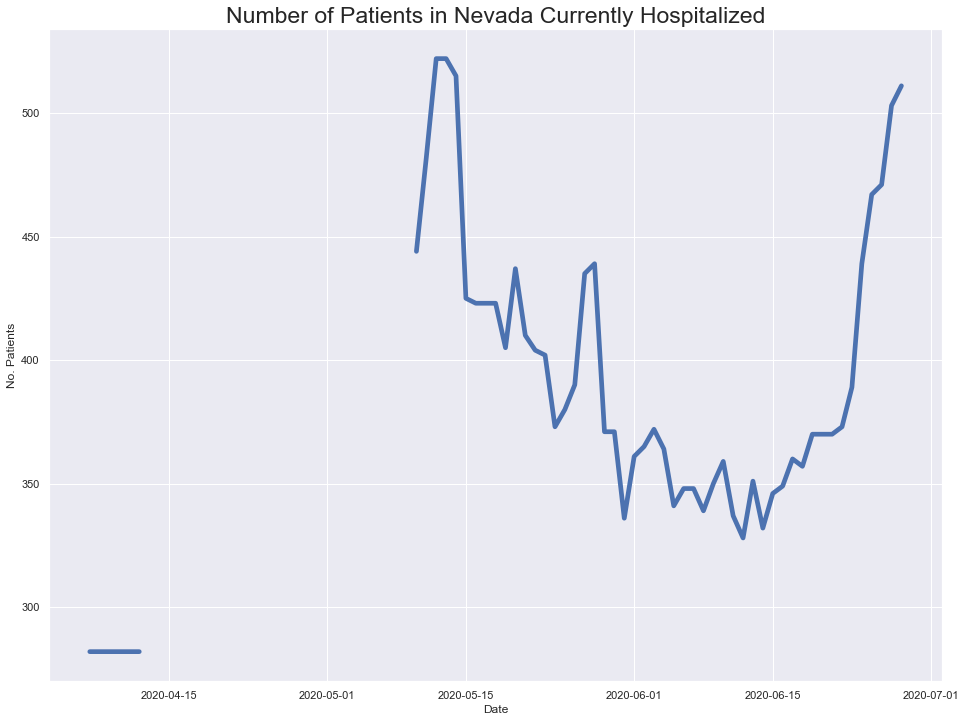

In [129]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(nevada.date, nevada.hospitalizedCurrently, linewidth=4.7)
plt.title('Number of Patients in Nevada Currently Hospitalized', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, 'No. Patients')

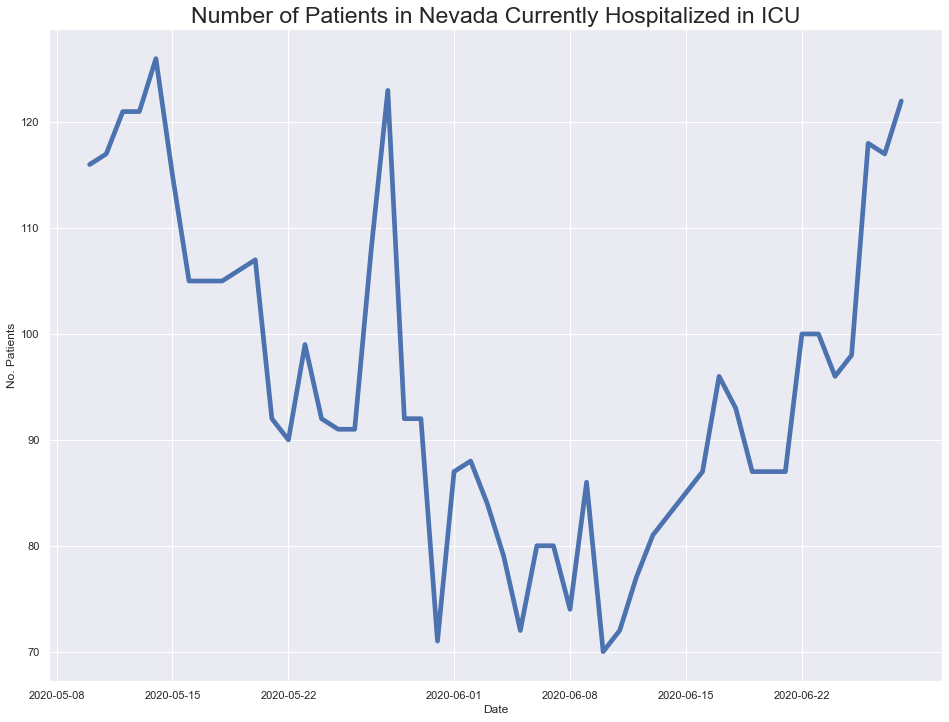

In [130]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(nevada.date, nevada.inIcuCurrently, linewidth=4.7)
plt.title('Number of Patients in Nevada Currently Hospitalized in ICU', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, 'No. Patients')

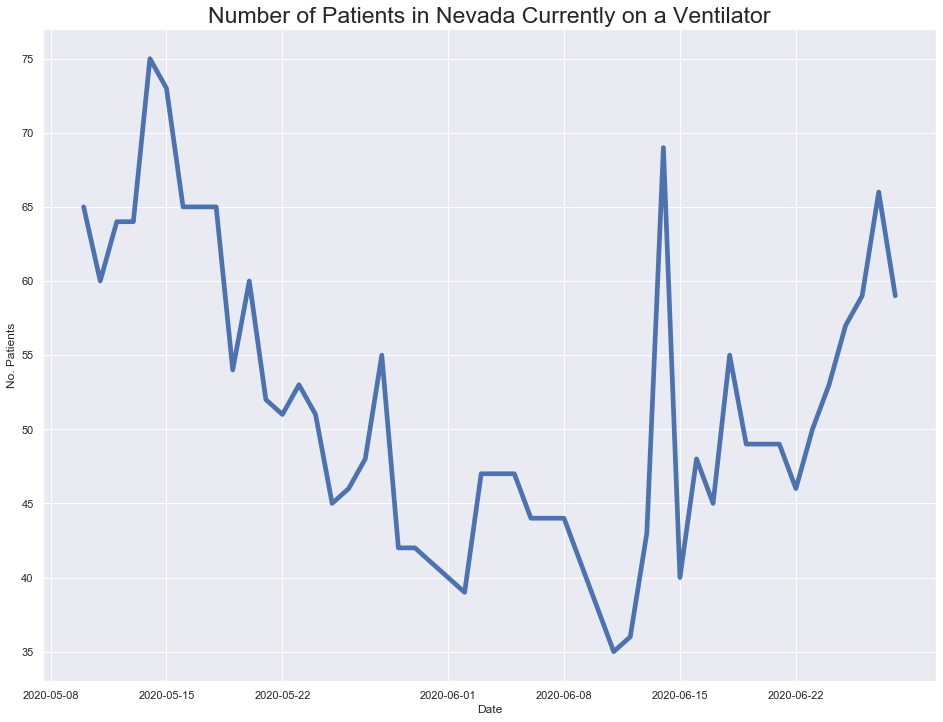

In [131]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(nevada.date, nevada.onVentilatorCurrently, linewidth=4.7)
plt.title('Number of Patients in Nevada Currently on a Ventilator', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

In [132]:
#hide_input
# Checking which cols have NaN values
nevada[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death', 'hospitalized']]
nevada.head()

# Omit the NaN cols
nevada = nevada[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death']]

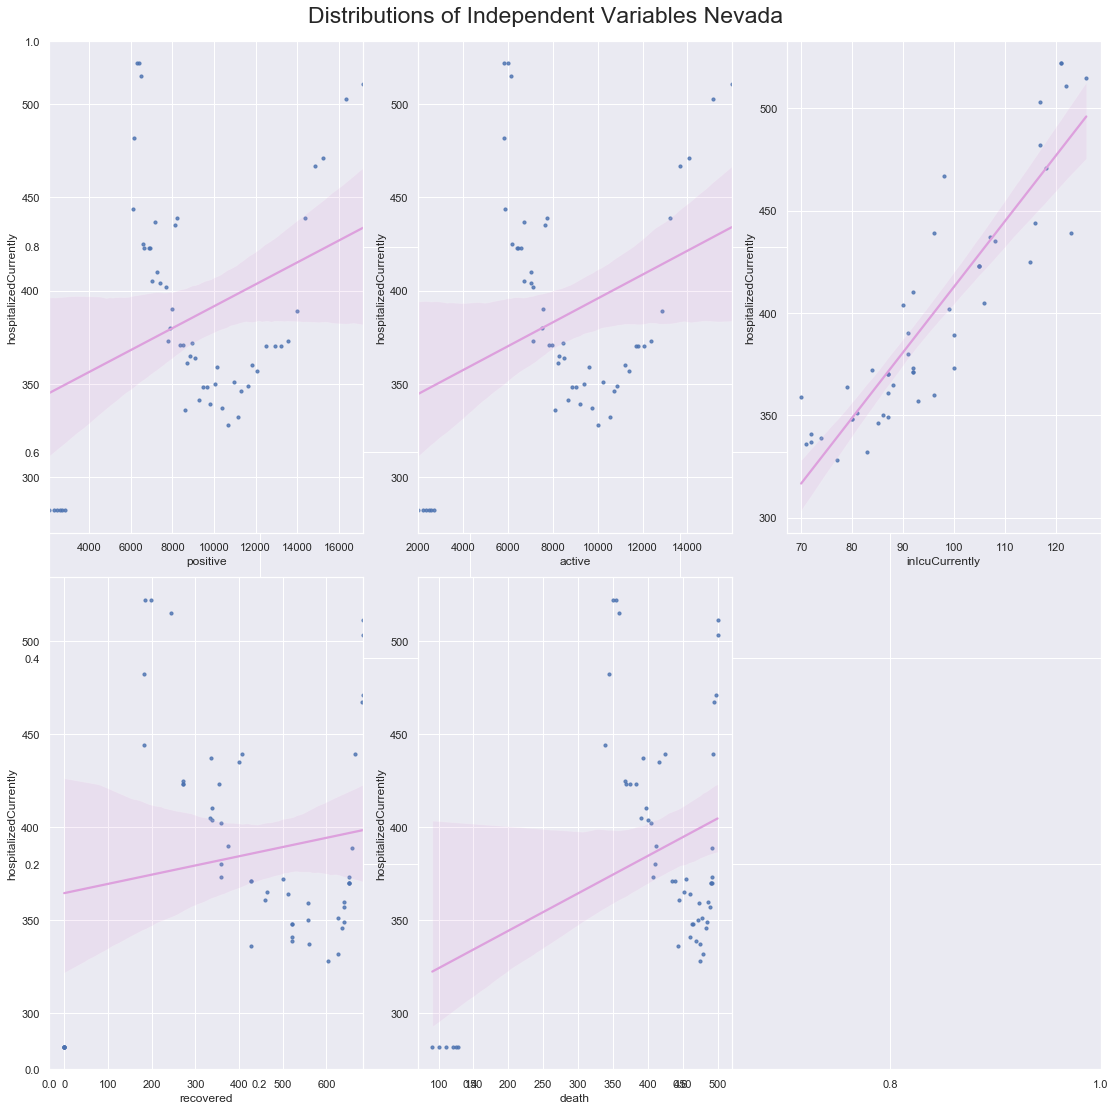

In [133]:
#hide_input
# Scatter plots NV
# Split dependent var from independent variables
target_nv = nevada.hospitalizedCurrently
indep_var_nv = nevada.drop(columns=['hospitalizedCurrently'])

fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(indep_var_nv.columns):
    ax=fig.add_subplot(2, 3, i+1) 
    sns.regplot(x=indep_var_nv[col], y=target_nv, data=indep_var_nv, label=col, scatter_kws={'s':10}, line_kws={"color": "plum"})
    plt.suptitle('Distributions of Independent Variables Nevada', fontsize=23)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

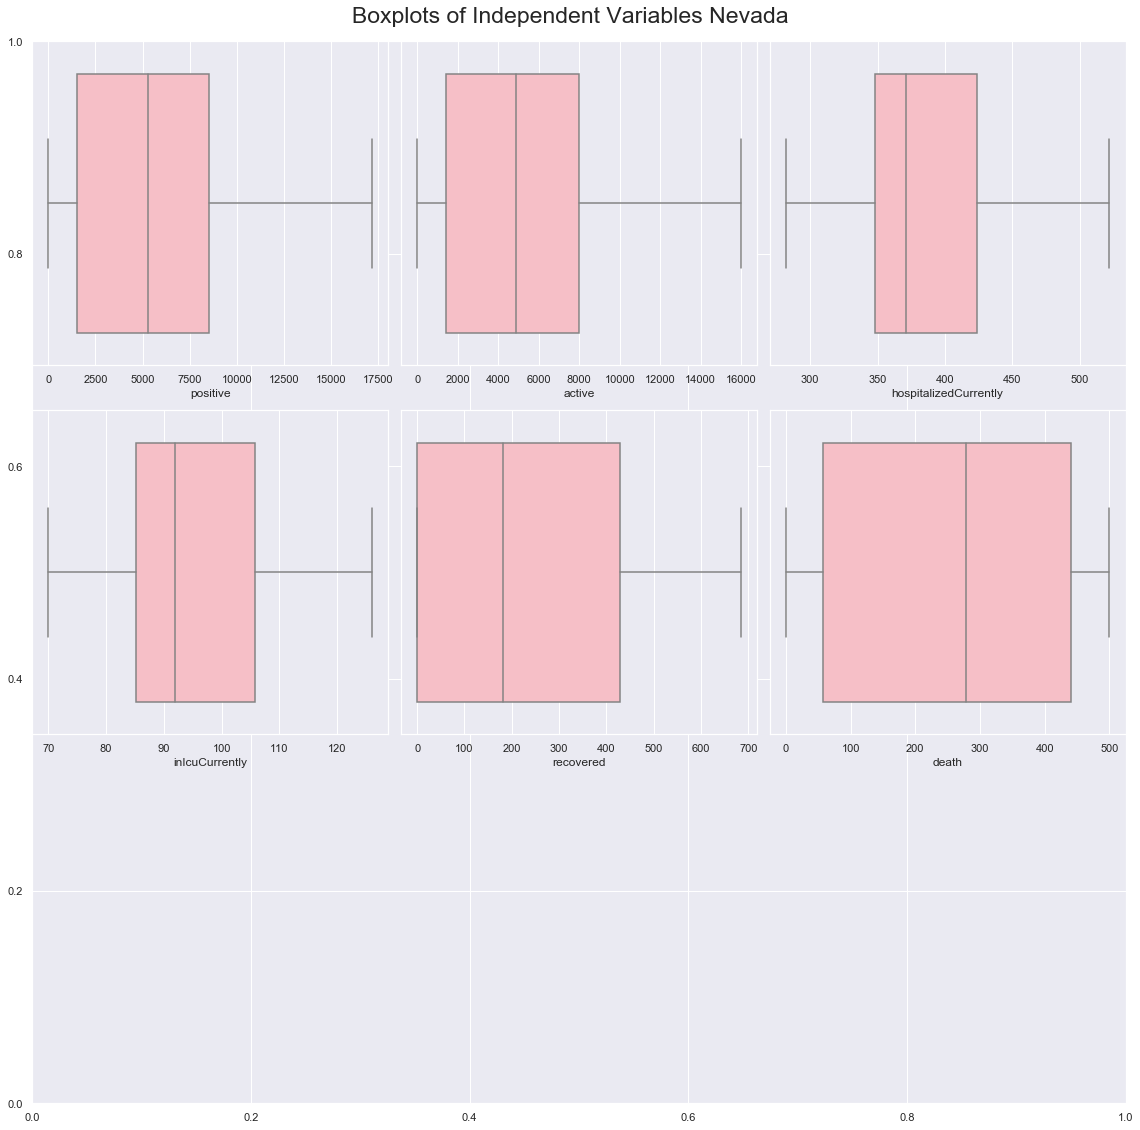

In [134]:
#hide_input
# Boxplot of NV
fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(nevada.columns):
    ax=fig.add_subplot(3, 3, i+1) 
    sns.boxplot(x=nevada[col], data=nevada, color='lightpink', showfliers=True)
    plt.suptitle('Boxplots of Independent Variables Nevada', fontsize=23)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

In [135]:
#hide_input
###endnevada

### Mississippi:

In [136]:
#hide_input
mississippi = covid_df.loc[(covid_df['abbrev'] == 'MS') & (covid_df['state']== 'Mississippi')] 


Text(0, 0.5, 'No. Patients')

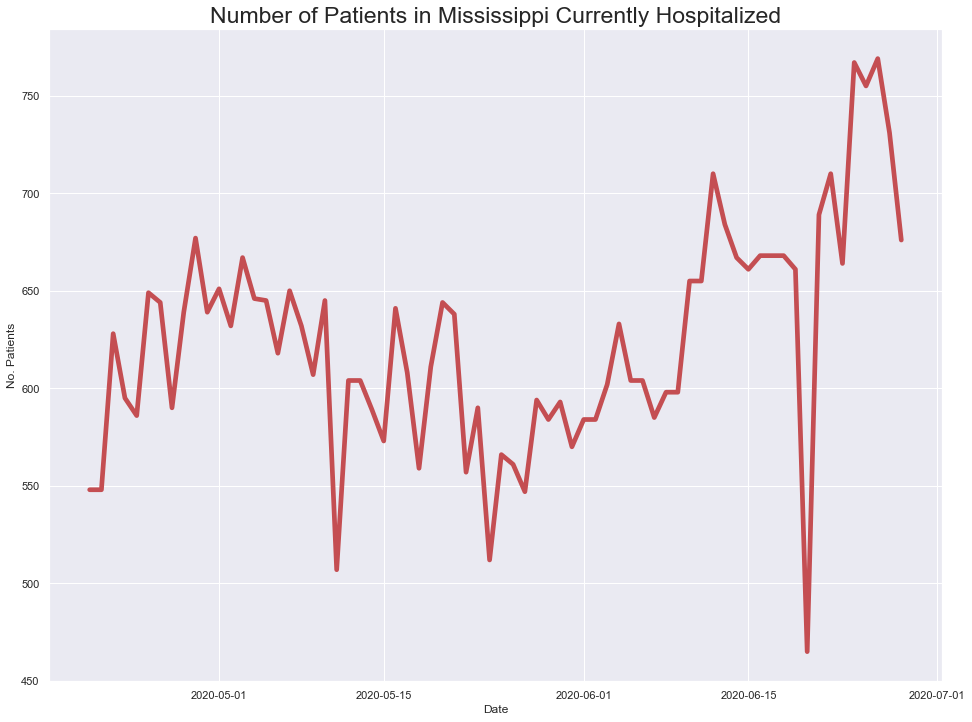

In [137]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(mississippi.date, mississippi.hospitalizedCurrently, linewidth=4.7, color='r')
plt.title('Number of Patients in Mississippi Currently Hospitalized', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, 'No. Patients')

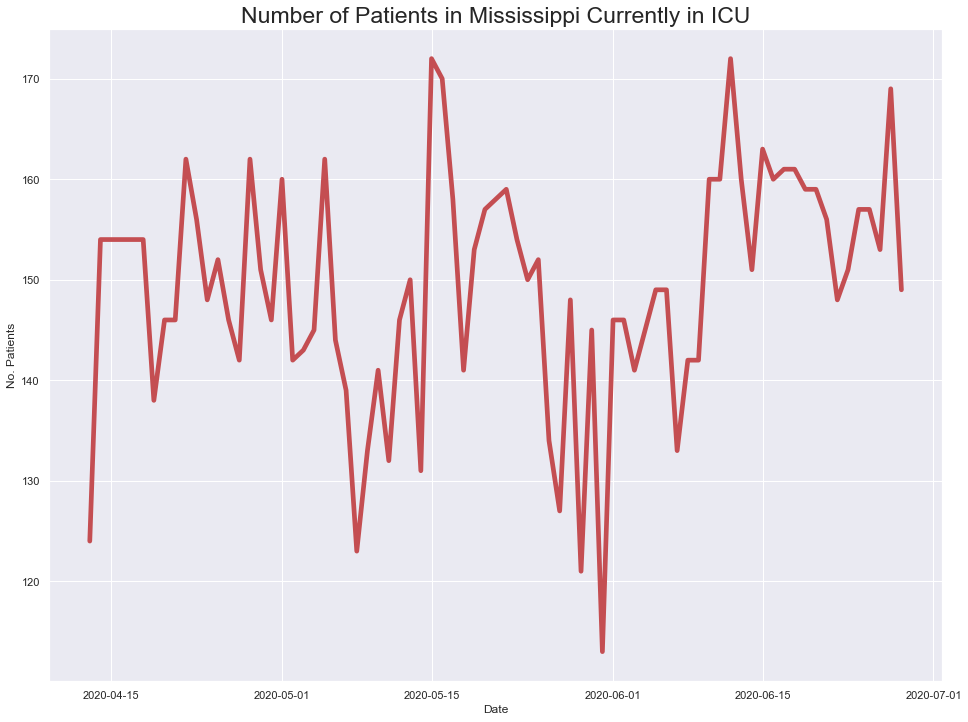

In [138]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(mississippi.date, mississippi.inIcuCurrently, linewidth=4.7, color='r')
plt.title('Number of Patients in Mississippi Currently in ICU', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, 'No. Patients')

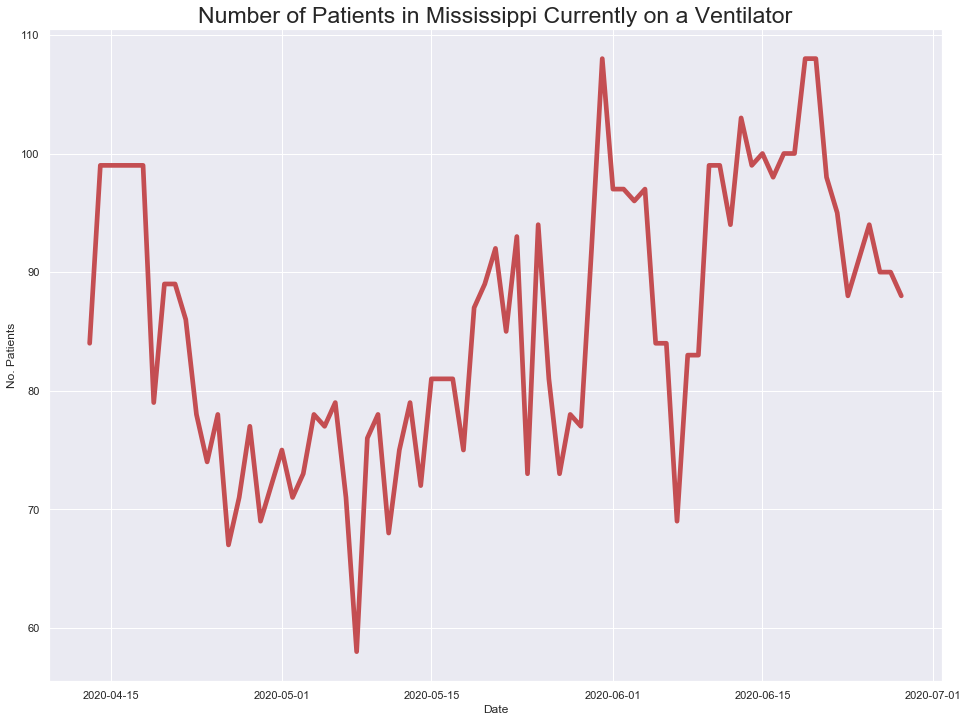

In [139]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(mississippi.date, mississippi.onVentilatorCurrently, linewidth=4.7, color='r')
plt.title('Number of Patients in Mississippi Currently on a Ventilator', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, 'No. Patients')

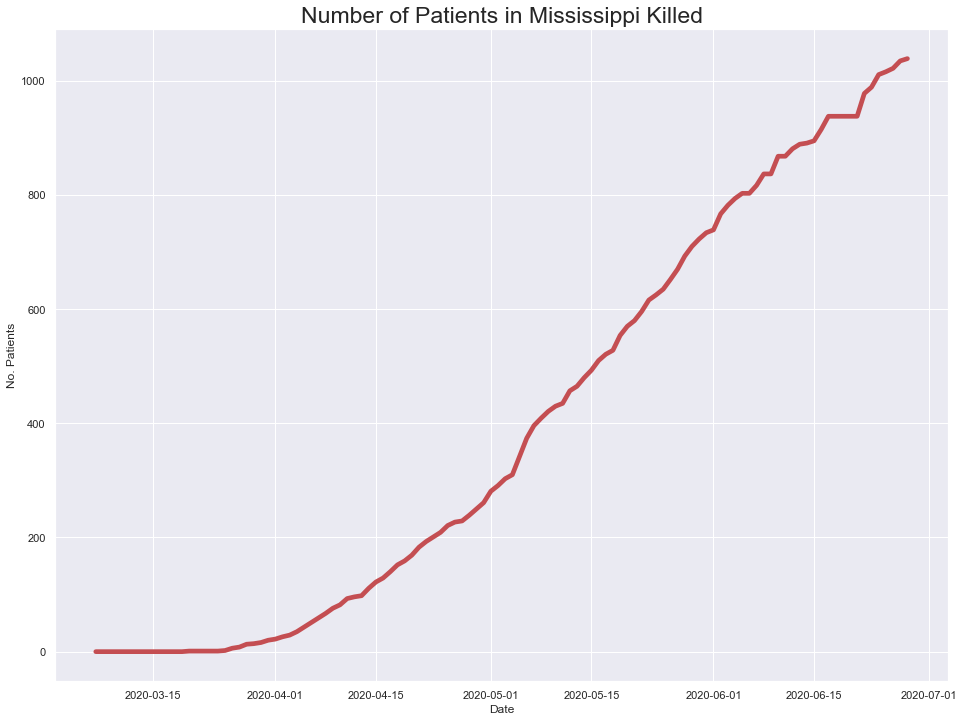

In [140]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(mississippi.date, mississippi.death, linewidth=4.7, color='r')
plt.title('Number of Patients in Mississippi Killed', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

In [141]:
#hide_input
# Checking which cols have NaN values
mississippi[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death', 'hospitalized']]
mississippi.head()

# Omit the NaN cols
mississippi = mississippi[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death']]

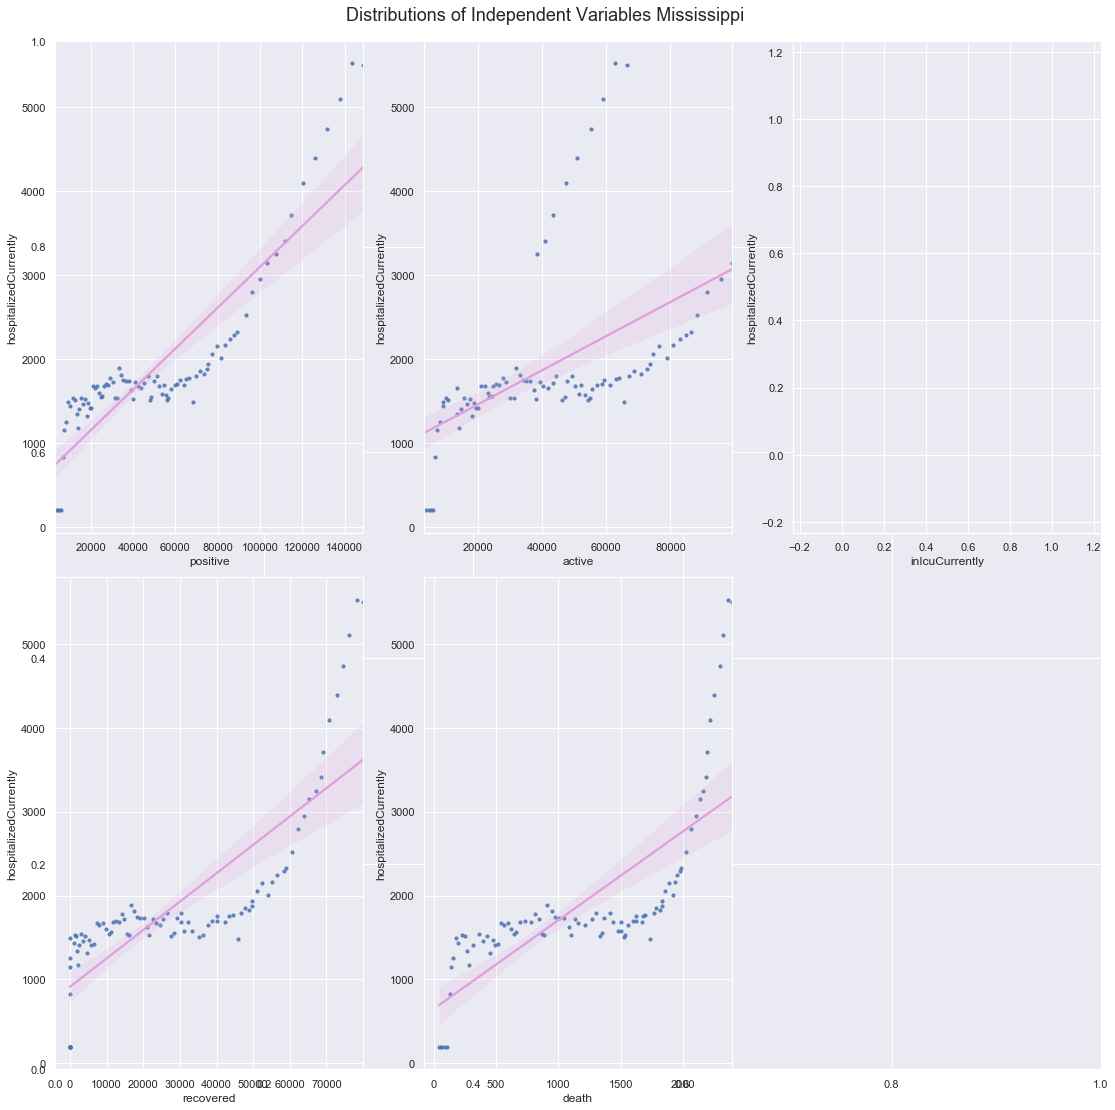

In [142]:
#hide_input
# Scatter plots MS
# Split dependent var from independent variables
target_ms = texas.hospitalizedCurrently
indep_var_ms = texas.drop(columns=['hospitalizedCurrently'])

fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(indep_var_ms.columns):
    ax=fig.add_subplot(2, 3, i+1) 
    sns.regplot(x=indep_var_ms[col], y=target_ms, data=indep_var_ms, label=col, scatter_kws={'s':10}, line_kws={"color": "plum"})
    plt.suptitle('Distributions of Independent Variables Mississippi', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

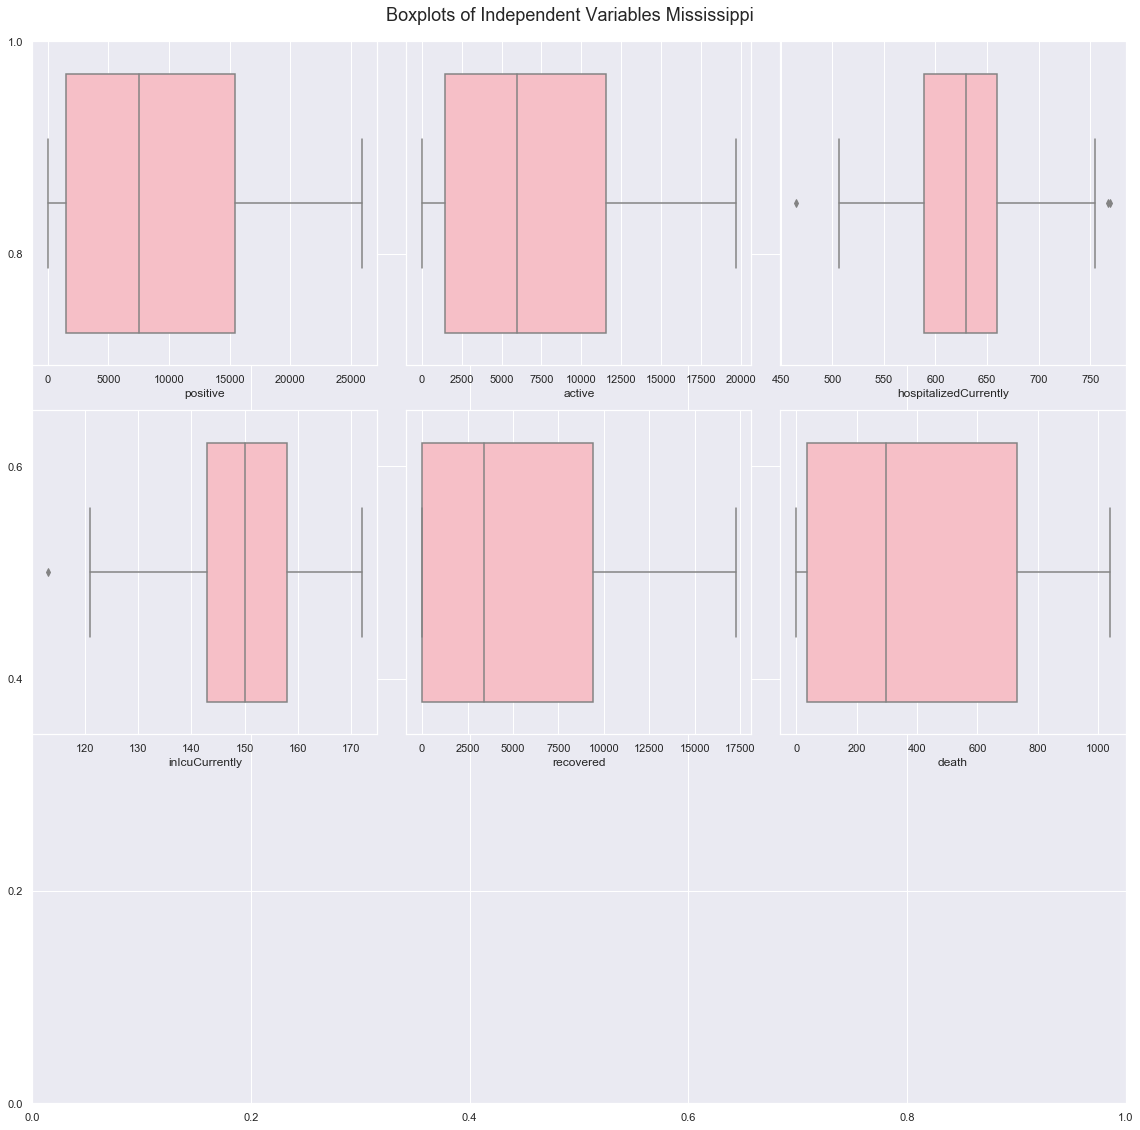

In [143]:
#hide_input
# Boxplot of MS
fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(texas.columns):
    ax=fig.add_subplot(3, 3, i+1) 
    sns.boxplot(x=mississippi[col], data=mississippi, color='lightpink', showfliers=True)
    plt.suptitle('Boxplots of Independent Variables Mississippi', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

In [144]:
#hide_input
###endmississippi

### Utah:

In [145]:
#hide_input
utah = covid_df.loc[(covid_df['abbrev'] == 'UT') & (covid_df['state']== 'Utah')] 


Text(0, 0.5, 'No. Patients')

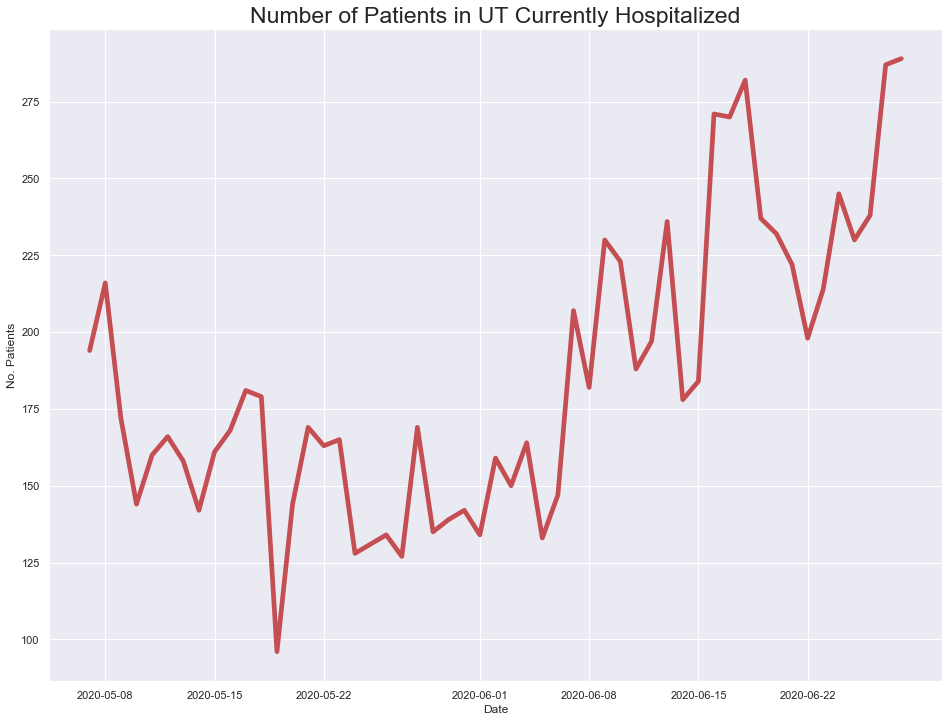

In [146]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(utah.date, utah.hospitalizedCurrently, linewidth=4.7, color='r')
plt.title('Number of Patients in UT Currently Hospitalized', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, 'No. Patients')

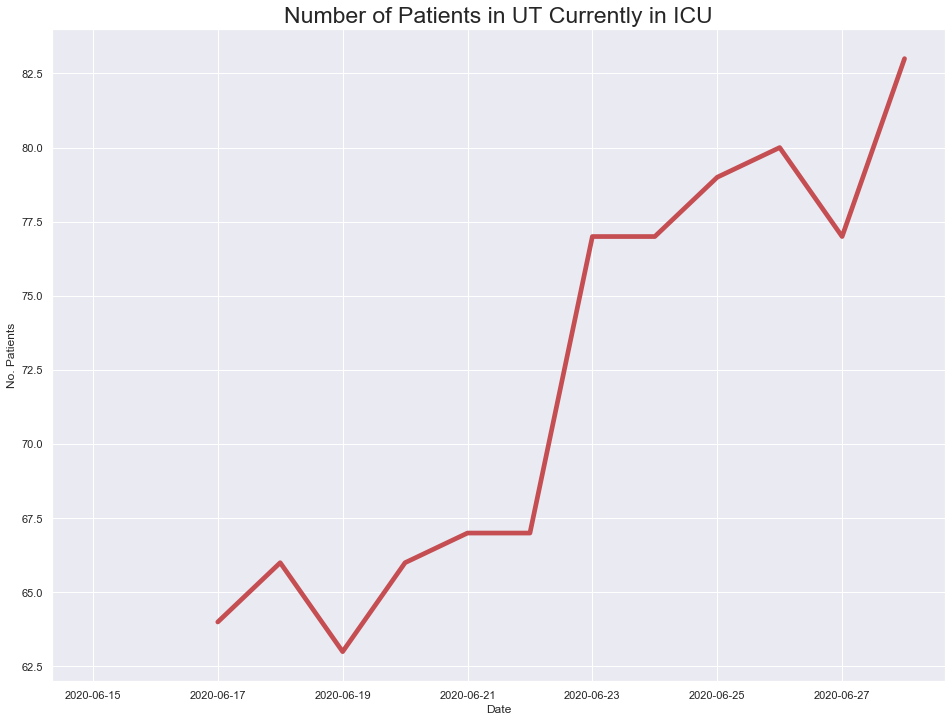

In [147]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(utah.date, utah.inIcuCurrently, linewidth=4.7, color='r')
plt.title('Number of Patients in UT Currently in ICU', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, 'No. Patients')

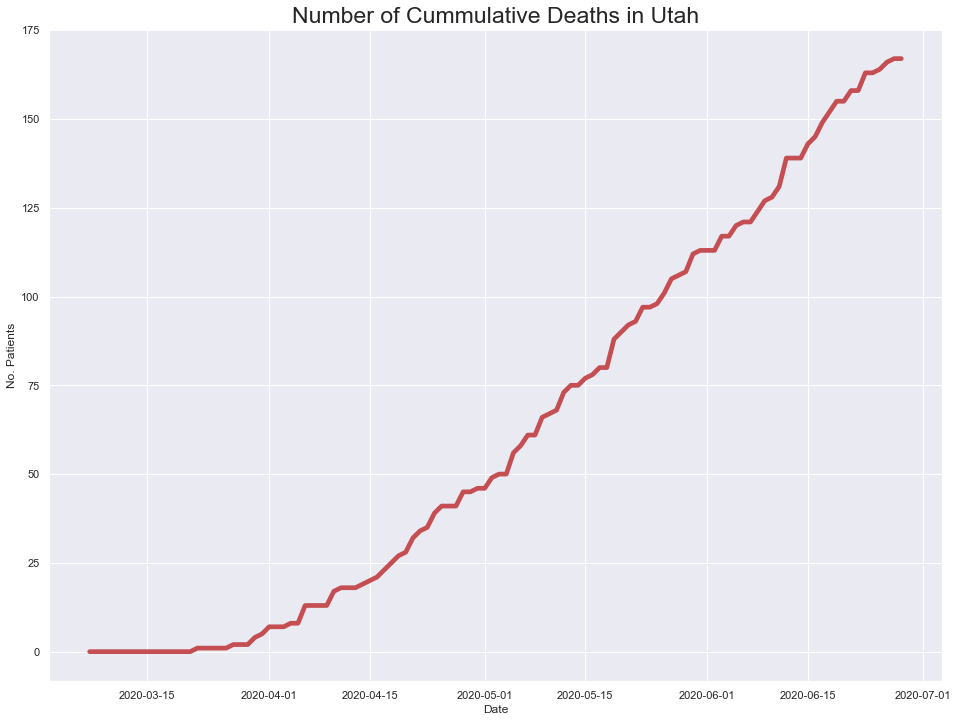

In [148]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(utah.date, utah.death, linewidth=4.7, color='r')
plt.title('Number of Cummulative Deaths in Utah', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

In [149]:
#hide_input
# Checking which cols have NaN values
utah[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death', 'hospitalized']]
utah.head()

# Omit the NaN cols
utah = utah[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death']]

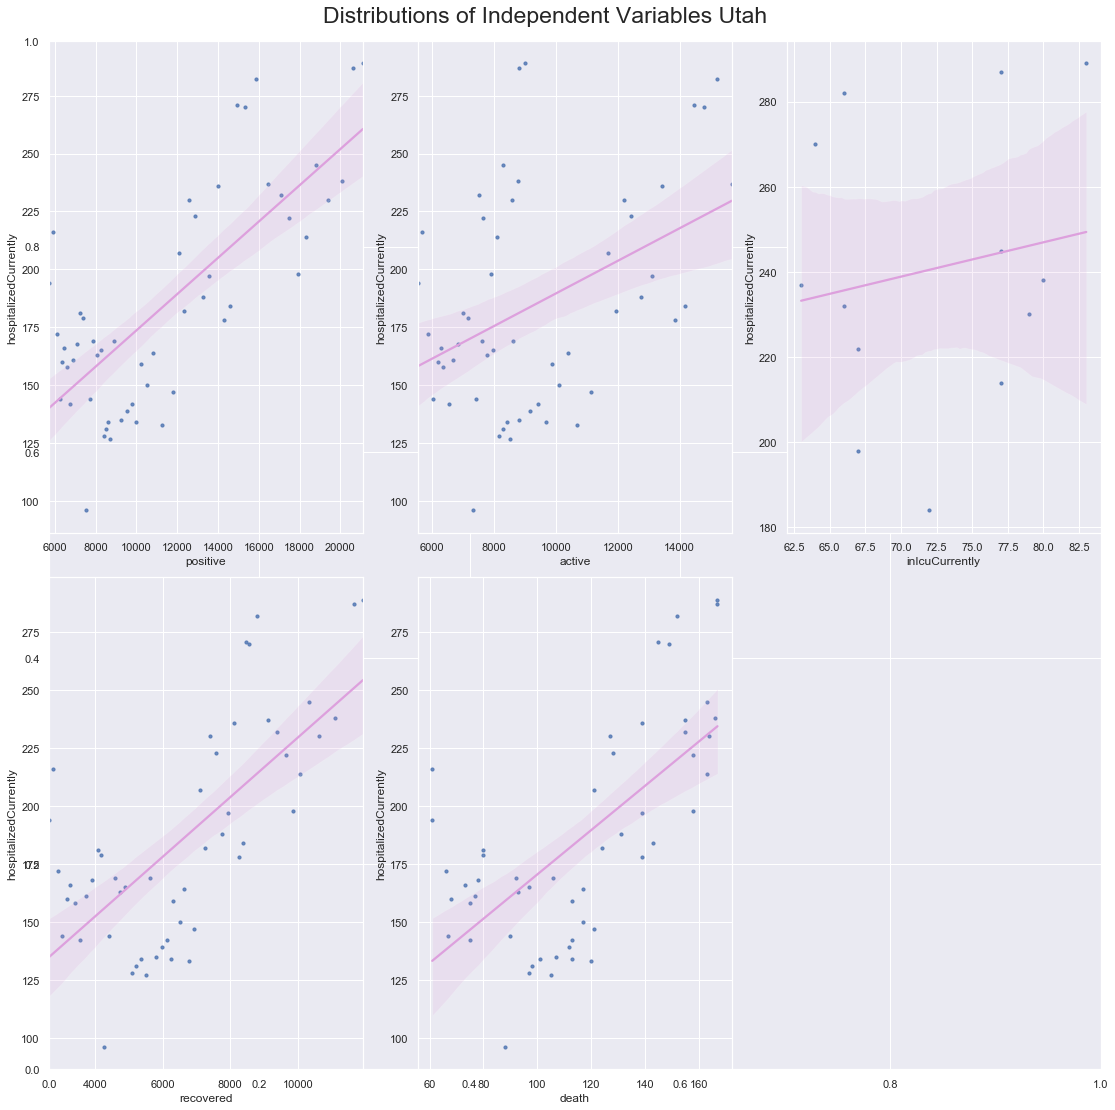

In [150]:
#hide_input
# Scatter plots UT
# Split dependent var from independent variables
target_ut = utah.hospitalizedCurrently
indep_var_ut = utah.drop(columns=['hospitalizedCurrently'])

fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(indep_var_tx.columns):
    ax=fig.add_subplot(2, 3, i+1) 
    sns.regplot(x=indep_var_ut[col], y=target_ut, data=indep_var_ut, label=col, scatter_kws={'s':10}, line_kws={"color": "plum"})
    plt.suptitle('Distributions of Independent Variables Utah', fontsize=23)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

In [151]:
#hide_input
###endutah

### Oklahoma:

In [152]:
#hide_input
oklahoma = covid_df.loc[(covid_df['abbrev'] == 'OK') & (covid_df['state']== 'Oklahoma')] 


Text(0, 0.5, 'No. Patients')

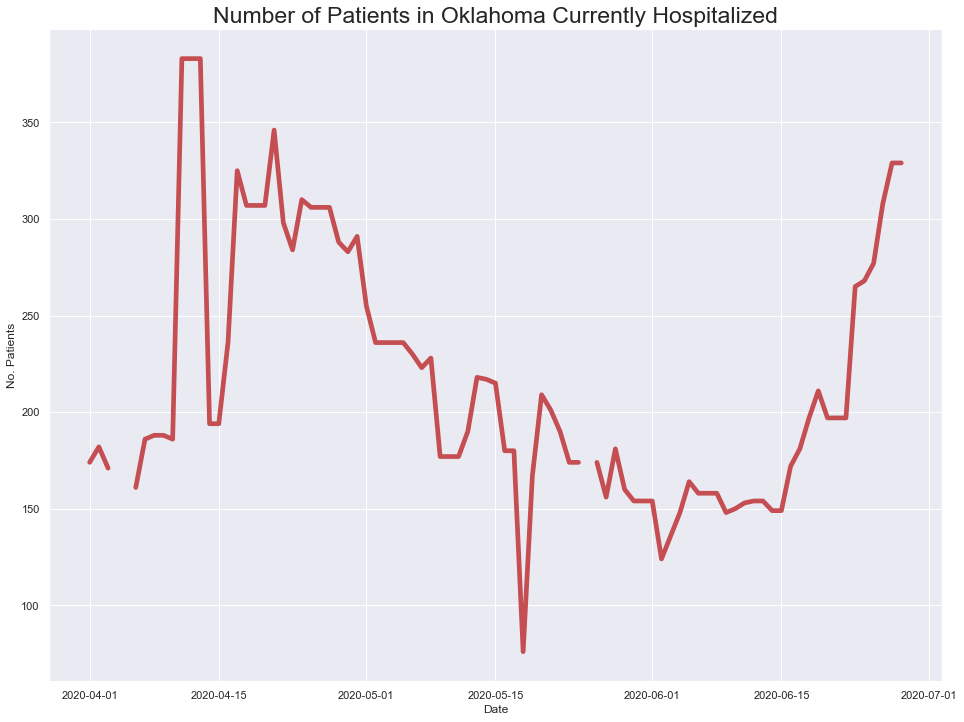

In [153]:
#hide_input
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(oklahoma.date, oklahoma.hospitalizedCurrently, linewidth=4.7, color='r')
plt.title('Number of Patients in Oklahoma Currently Hospitalized', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

In [154]:
#hide_input
# Checking which cols have NaN values
oklahoma[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death', 'hospitalized']]
oklahoma.head()

# Omit the NaN cols
oklahoma = oklahoma[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death']]

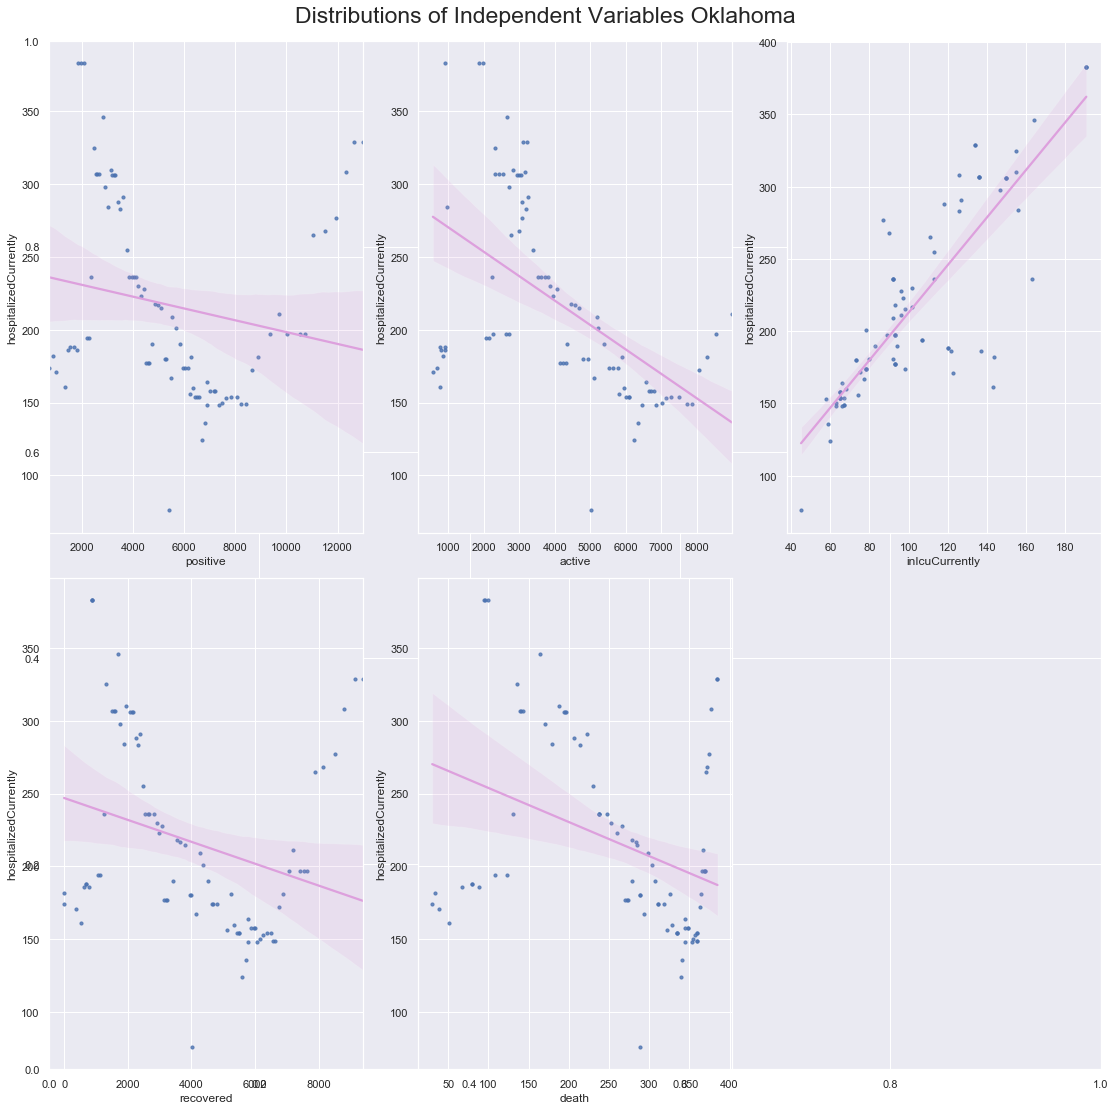

In [155]:
#hide_input
# Scatter plots OK
# Split dependent var from independent variables
target_ok = oklahoma.hospitalizedCurrently
indep_var_ok = oklahoma.drop(columns=['hospitalizedCurrently'])

fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(indep_var_ok.columns):
    ax=fig.add_subplot(2, 3, i+1) 
    sns.regplot(x=indep_var_ok[col], y=target_ok, data=indep_var_ok, label=col, scatter_kws={'s':10}, line_kws={"color": "plum"})
    plt.suptitle('Distributions of Independent Variables Oklahoma', fontsize=23)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

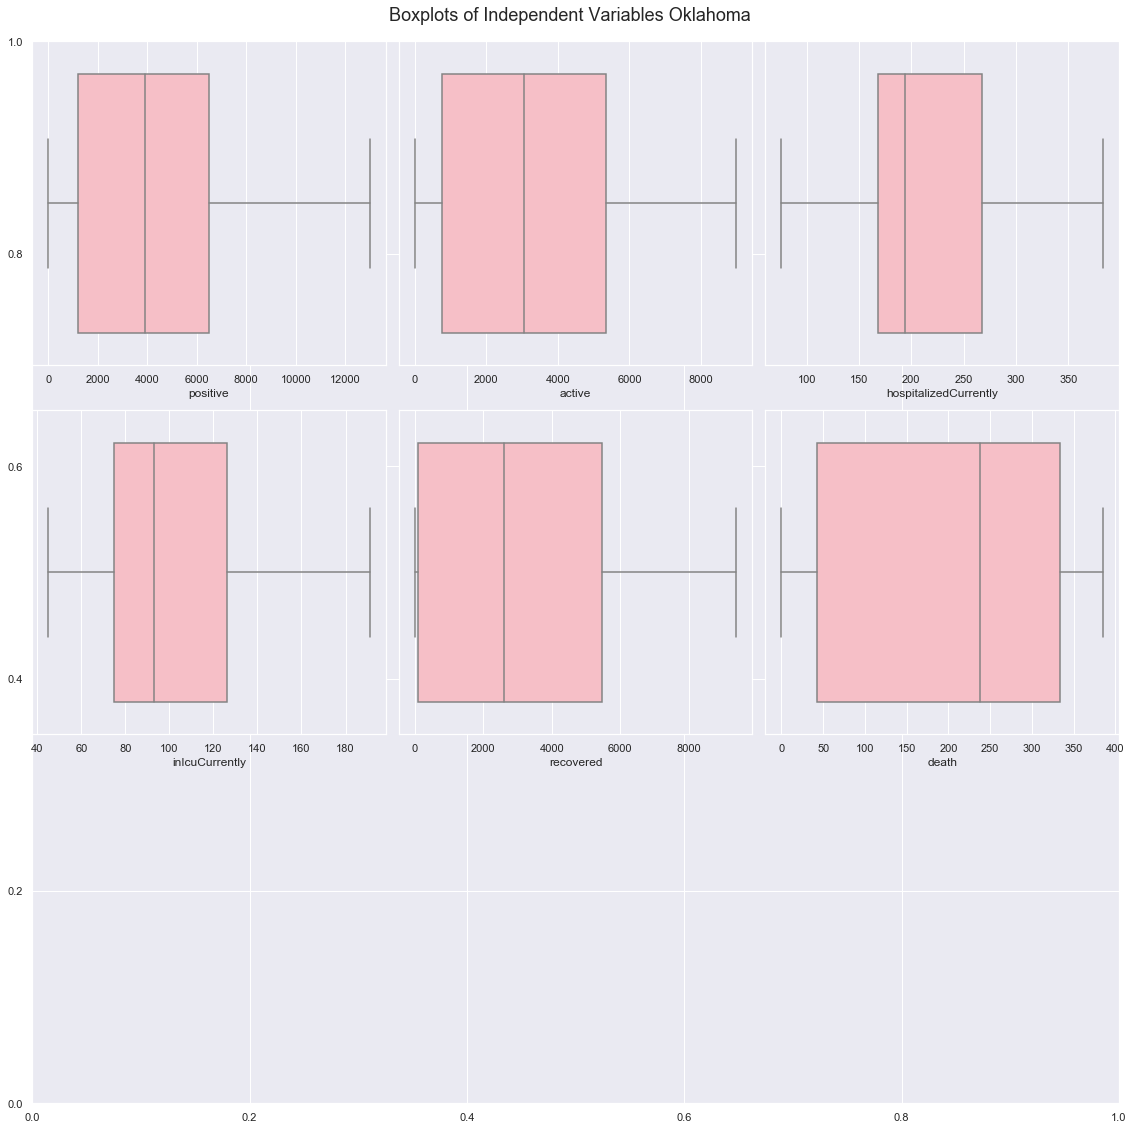

In [156]:
#hide_input
# Boxplot of OK
fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(oklahoma.columns):
    ax=fig.add_subplot(3, 3, i+1) 
    sns.boxplot(x=oklahoma[col], data=oklahoma, color='lightpink', showfliers=True)
    plt.suptitle('Boxplots of Independent Variables Oklahoma', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

In [157]:
#hide_input
###endoklahoma

## Assessing Correlation of Independent Variables

In [158]:
#hide_input
# TODO add some explanation / look more into collinear variables

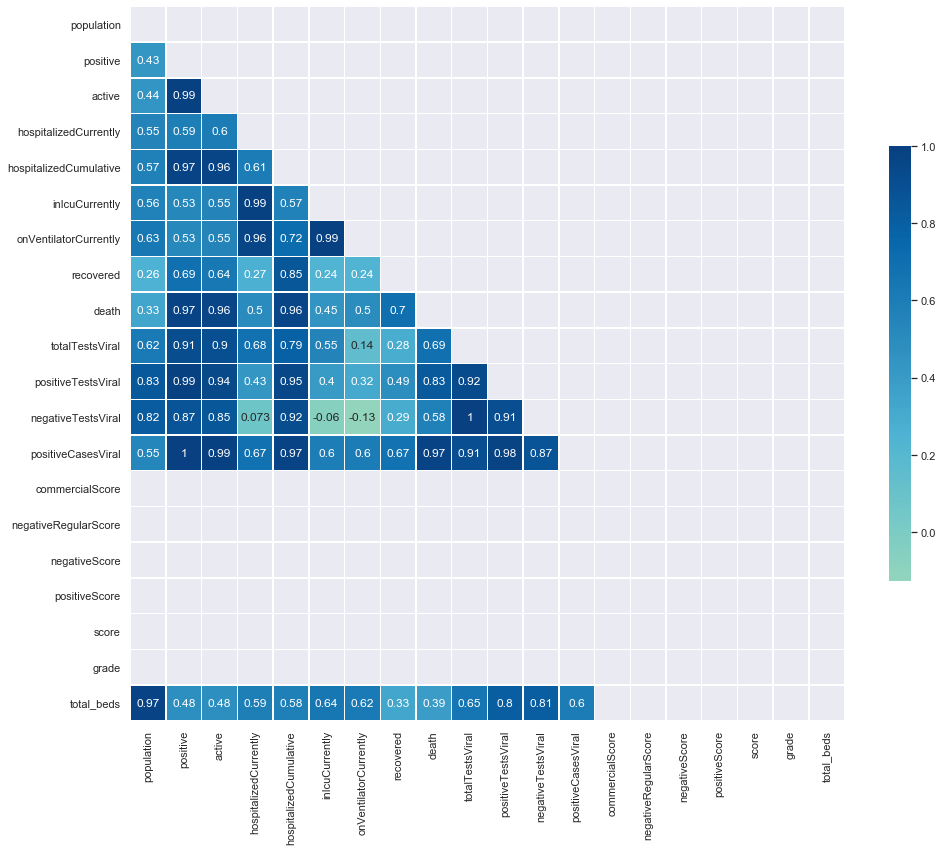

In [159]:
#hide_input
# Heatmap of correlations
# Save correlations to variable
corr = covid_cleaned.corr(method='pearson')
# We can create a mask to not show duplicate values
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(16,16))

# Generate heatmap
sns.heatmap(corr, annot=True, mask=mask, cmap='GnBu', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Build model for dependent Variable 
- To be used to predict current hospitalizations
- Having more complete variables for in ICU currently and on Ventilator Currently will allow us to predict these numbers as well.

In [160]:
#hide_input
# We compare three models:
# - Polynomial Regression
# - Linear Regression
# - ElasticNet

# Copy DFs to not mess up original one
# We will use model_df for our regression model
model_df = all_cases.copy()

# Delete redundant rows
for row in ['abbrev', 'bedsPerThousand', 'hospitalized', 
'state', 'hospitalizedCumulative', 'dataQualityGrade', 'lastUpdateEt']:
    del model_df[row]

# Drop NaN values for hospitalizedCurrently
model_df = model_df.dropna(subset=['hospitalizedCurrently'])

# Drop Values with abnormal active-hospitalised ratios (outside Conf. Interval)
model_df['ratio_hospital'] = model_df['hospitalizedCurrently'] / model_df['active']
model_df = model_df[~(model_df['ratio_hospital'] >= model_df.ratio_hospital.quantile(0.99))]

#model_df = model_df[~(model_df['ratio_hospital'] <= model_df['ratio_hospital'].median())]
del model_df['ratio_hospital']

# Get peek of model to use
model_df.describe()

population   positive     active  hospitalizedCurrently  \
count     3608.000   3608.000   3608.000               3608.000   
mean   6734094.920  31851.205  28006.326               1020.191   
std    7738225.857  56776.272  51040.791               1930.862   
min     567025.000    115.000    113.000                  1.000   
25%    1778070.000   3276.500   2835.000                117.000   
50%    4645184.000  12335.500  10087.500                399.500   
75%    8626207.000  35334.500  29969.500               1014.750   
max   39937489.000 392539.000 356899.000              18825.000   

       inIcuCurrently  onVentilatorCurrently  recovered     death  \
count        1833.000               1627.000   3608.000  3608.000   
mean          437.771                221.840   7009.118  1716.808   
std           698.186                331.324  13459.030  3599.085   
min             2.000                  0.000      0.000     0.000   
25%            80.000                 34.000      9.000    91.000   
50%           179.000                 91.000   1297.500   474.500   
75%           469.000                238.000   6266.500  1598.250   
max          5225.000               2425.000  79974.000 24835.000   

       totalTestsViral  positiveTestsViral  negativeTestsViral  \
count         1121.000             399.000             399.000   
mean        401896.592           25414.065          243476.774   
std         542128.442           26144.869          232041.192   
min           9055.000             407.000            8648.000   
25%          87459.000            4128.000           63478.000   
50%         223245.000           14135.000          168871.000   
75%         491884.000           44340.500          310173.500   
max        3955952.000           87087.000          946733.000   

       positiveCasesViral  commercialScore  negativeRegularScore  \
count            2531.000         3608.000              3608.000   
mean            36576.426            0.000                 0.000   
std             61272.107            0.000                 0.000   
min               396.000            0.000                 0.000   
25%              6439.500            0.000                 0.000   
50%             16441.000            0.000                 0.000   
75%             40708.000            0.000                 0.000   
max            392539.000            0.000                 0.000   

       negativeScore  positiveScore    score  grade  total_beds  
count       3608.000       3608.000 3608.000  0.000    3608.000  
mean           0.000          0.000    0.000    nan   16006.400  
std            0.000          0.000    0.000    nan   16508.042  
min            0.000          0.000    0.000    nan    1318.928  
25%            0.000          0.000    0.000    nan    3773.952  
50%            0.000          0.000    0.000    nan   11557.920  
75%            0.000          0.000    0.000    nan   19124.737  
max            0.000          0.000    0.000    nan   71887.480